In [1]:

import pandas as pd

from sklearn.externals import joblib
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
import numpy as np
from dateutil.parser import parse
import datetime as dt
from numba import jit

from tqdm import tqdm, tqdm_notebook

from collections import OrderedDict as od
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import random, os, csv      # random is the rng, os is the operating system, and csv handles
                            # CSV files
import matplotlib.pyplot as plt  # This is the plotter
import time                 # This allows for lots of neat tricks.
import powerlaw
import mpmath
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
import math
plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

import powerlaw
import mpmath
import pylab
pylab.rcParams['xtick.major.pad']='8'
pylab.rcParams['ytick.major.pad']='8'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(12.0)
panel_label_font.set_family("sans-serif")

def plot_basics(data, data_inst, fig, units):
    from powerlaw import plot_pdf, Fit, pdf
    annotate_coord = (-.4, .95)
    ax1 = fig.add_subplot(n_graphs,n_data,data_inst)
    x, y = pdf(data, linear_bins=True)
    ind = y>0
    y = y[ind]
    x = x[:-1]
    x = x[ind]
    ax1.scatter(x, y, color='r', s=.5)
    plot_pdf(data[data>0], ax=ax1, color='b', linewidth=2)
    from pylab import setp
    setp( ax1.get_xticklabels(), visible=False)
from pylab import setp


In [2]:
def returns(s):
    #compute log returns
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def tick_bars(df, price_column, m):
    '''
    compute tick bars
    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx
def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx]
#========================================================
def volume_bars(df, volume_column, m):
    '''
    compute volume bars
    # args
        df: pd.DataFrame()
        column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx]
#========================================================
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]
#========================================================
dataparser = lambda x: pd.datetime.strptime(x, '%M:%S.%f').time
#========================================================
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [4]:
os.getcwd()
data_dir = os.getenv('FINANCE_DATA')  # main directory referenced in all the code
data_only_drive = '/media/ak/DataOnly/'  # external date only drive
# quotes=[s for s in os.listdir(data_only_drive) if s.endswith('quotes')]
# trades=[s for s in os.listdir(data_only_drive) if s.endswith('trades')]
# TY1_trades=[s for s in os.listdir(data_only_drive) if s.startswith('TY1') and s.endswith('trades')]
# TY1_quotes=[s for s in os.listdir(data_only_drive) if s.startswith('TY1') and s.endswith('quotes')]

In [11]:
data_only_drive = '/media/ak/DataOnly/'  # external date only drive
clean_files_data = "".join((data_only_drive,'/BTCUSD.PERP.BMEX/'))
raw_crypto_data_lob = '/media/ak/DataOnly/crypto/LOB/BTCUSD.PERP.BMEX/' #btc perp data
clean_crypto_files = os.listdir(clean_files_data)
csv_files = [s for s in os.listdir(raw_crypto_data_lob) if s.endswith('.csv')]
low_memory = False

In [12]:
# cleaning first stack of crypto-data
mylist = []
fields = ['happened_at', 'BIDPRC1', 'BIDSIZE1', 'ASKPRC1', 'ASKSIZE1']

# for csv_files_idx, csv_date in enumerate(csv_files):
#     print csv_date
csv_files_idx=3
csv_loc = "/".join((raw_crypto_data_lob,csv_files[csv_files_idx]))
for chunk in pd.read_csv(csv_loc, chunksize=2000, skipinitialspace=True, usecols=fields, error_bad_lines=False, engine='python'):
    mylist.append(chunk)
    print chunk.head(4)
    big_data_df = pd.concat(mylist, axis=0)
del mylist
print df_name
# df_name = "".join((clean_files_data,csv_files_idx,".csv"))
# big_data_df.to_csv(df_name)

                        happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
0  2018-06-21 13:21:36.741000+00:00   6724.5  539818.0   6725.0  804976.0
1  2018-06-21 13:21:36.757000+00:00   6724.5  539818.0   6725.0  827476.0
2  2018-06-21 13:21:36.763000+00:00   6724.5  539818.0   6725.0  827476.0
3  2018-06-21 13:21:36.778000+00:00   6724.5  539818.0   6725.0  827476.0
                           happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  ASKSIZE1
2000  2018-06-21 13:25:27.333000+00:00   6723.0  1081387.0   6723.5  583466.0
2001  2018-06-21 13:25:27.663000+00:00   6723.0  1081387.0   6723.5  583666.0
2002  2018-06-21 13:25:27.995000+00:00   6723.0  1081387.0   6723.5  583666.0
2003  2018-06-21 13:25:28.298000+00:00   6723.0  1047559.0   6723.5  673370.0
                           happened_at  BIDPRC1   BIDSIZE1  ASKPRC1   ASKSIZE1
4000  2018-06-21 13:29:33.872000+00:00   6724.5  2006437.0   6725.0  1267530.0
4001  2018-06-21 13:29:33.879000+00:00   6724.5  2007437.0   6725.0  1267530.0
400

                            happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
44000  2018-06-21 14:24:51.257000+00:00   6714.5  899508.0   6715.0  720892.0
44001  2018-06-21 14:24:51.287000+00:00   6714.5  915508.0   6715.0  720892.0
44002  2018-06-21 14:24:51.333000+00:00   6714.5  915508.0   6715.0  710892.0
44003  2018-06-21 14:24:51.340000+00:00   6714.5  915508.0   6715.0  710892.0
                            happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
46000  2018-06-21 14:27:33.178000+00:00   6714.5  966641.0   6715.0  884464.0
46001  2018-06-21 14:27:33.285000+00:00   6714.5  966641.0   6715.0  879439.0
46002  2018-06-21 14:27:33.707000+00:00   6714.5  966641.0   6715.0  879469.0
46003  2018-06-21 14:27:33.928000+00:00   6714.5  966641.0   6715.0  884469.0
                            happened_at  BIDPRC1  BIDSIZE1  ASKPRC1   ASKSIZE1
48000  2018-06-21 14:30:24.893000+00:00   6708.0  372984.0   6708.5  1363930.0
48001  2018-06-21 14:30:24.904000+00:00   6708.0  372984.0   6

                            happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
96000  2018-06-21 15:32:18.718000+00:00   6730.0  139488.0   6730.5  544413.0
96001  2018-06-21 15:32:18.735000+00:00   6730.0  139488.0   6730.5  544413.0
96002  2018-06-21 15:32:18.784000+00:00   6730.0  139488.0   6730.5  544413.0
96003  2018-06-21 15:32:18.788000+00:00   6730.0  139488.0   6730.5  544413.0
                            happened_at  BIDPRC1  BIDSIZE1  ASKPRC1   ASKSIZE1
98000  2018-06-21 15:34:32.851000+00:00   6732.5    9218.0   6733.0  1387790.0
98001  2018-06-21 15:34:32.888000+00:00   6732.5    9218.0   6733.0  1379710.0
98002  2018-06-21 15:34:32.954000+00:00   6732.5    9618.0   6733.0  1379710.0
98003  2018-06-21 15:34:33.311000+00:00   6732.5    9618.0   6733.0  1374710.0
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
100000  2018-06-21 15:37:46.063000+00:00   6729.0  1199361.0   6729.5   
100001  2018-06-21 15:37:46.206000+00:00   6729.0  1199361.0   6729.5

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
140000  2018-06-21 16:35:30.489000+00:00   6722.0  343625.0   6722.5   
140001  2018-06-21 16:35:30.545000+00:00   6722.0  343625.0   6722.5   
140002  2018-06-21 16:35:30.609000+00:00   6722.0  343625.0   6722.5   
140003  2018-06-21 16:35:30.623000+00:00   6722.0  343625.0   6722.5   

         ASKSIZE1  
140000  1323121.0  
140001  1319760.0  
140002  1319760.0  
140003  1314098.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
142000  2018-06-21 16:38:21.492000+00:00   6714.0  194183.0   6714.5   
142001  2018-06-21 16:38:21.496000+00:00   6714.0  208391.0   6714.5   
142002  2018-06-21 16:38:21.511000+00:00   6714.0  208391.0   6714.5   
142003  2018-06-21 16:38:21.514000+00:00   6714.0  208471.0   6714.5   

         ASKSIZE1  
142000  1933718.0  
142001  1933718.0  
142002  1968718.0  
142003  1968718.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
144000

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
180000  2018-06-21 17:34:40.727000+00:00   6704.0   79031.0   6704.5   
180001  2018-06-21 17:34:40.757000+00:00   6704.0   79031.0   6704.5   
180002  2018-06-21 17:34:40.793000+00:00   6704.0   79031.0   6704.5   
180003  2018-06-21 17:34:40.819000+00:00   6704.0   79031.0   6704.5   

         ASKSIZE1  
180000  1419754.0  
180001  1419773.0  
180002  1430773.0  
180003  1430773.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
182000  2018-06-21 17:36:13.275000+00:00   6699.0  346650.0   6699.5   83485.0
182001  2018-06-21 17:36:13.280000+00:00   6699.0  366650.0   6699.5   83485.0
182002  2018-06-21 17:36:13.288000+00:00   6699.0  366650.0   6699.5   83485.0
182003  2018-06-21 17:36:13.363000+00:00   6699.0  366650.0   6699.5   83485.0
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
184000  2018-06-21 17:38:24.177000+00:00   6702.5  1230173.0   6703.0  

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
228000  2018-06-21 18:55:01.897000+00:00   6699.5    3425.0   6700.0  884852.0
228001  2018-06-21 18:55:01.909000+00:00   6699.5    4765.0   6700.0  924852.0
228002  2018-06-21 18:55:01.920000+00:00   6699.5    4765.0   6700.0  944878.0
228003  2018-06-21 18:55:01.931000+00:00   6699.5   24880.0   6700.0  941379.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
230000  2018-06-21 18:56:55.984000+00:00   6695.5  523465.0   6696.0  332682.0
230001  2018-06-21 18:56:56.094000+00:00   6695.5  523465.0   6696.0  332682.0
230002  2018-06-21 18:56:56.127000+00:00   6695.5  523465.0   6696.0  336030.0
230003  2018-06-21 18:56:56.162000+00:00   6695.5  523465.0   6696.0  337102.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
232000  2018-06-21 18:59:35.173000+00:00   6699.5  809836.0   6700.0    3188.0
232001  2018-06-21 18:59:35.183000+00:00   6699.5  8

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
270000  2018-06-21 20:01:44.182000+00:00   6712.5  156070.0   6713.0   
270001  2018-06-21 20:01:44.196000+00:00   6712.5  156615.0   6713.0   
270002  2018-06-21 20:01:44.225000+00:00   6712.5  158245.0   6713.0   
270003  2018-06-21 20:01:44.256000+00:00   6712.5  158245.0   6713.0   

         ASKSIZE1  
270000  1543406.0  
270001  1543406.0  
270002  1543406.0  
270003  1543406.0  
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
272000  2018-06-21 20:06:20.233000+00:00   6714.0  1554899.0   6714.5   
272001  2018-06-21 20:06:20.584000+00:00   6714.5    35500.0   6715.0   
272002  2018-06-21 20:06:20.596000+00:00   6714.5   230541.0   6715.0   
272003  2018-06-21 20:06:20.607000+00:00   6714.5   291541.0   6715.0   

        ASKSIZE1  
272000    2884.0  
272001  170553.0  
272002  170578.0  
272003  170578.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
274000

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
308000  2018-06-21 21:07:57.321000+00:00   6724.5  629214.0   6725.0  793621.0
308001  2018-06-21 21:07:57.636000+00:00   6724.5  629214.0   6725.0  763621.0
308002  2018-06-21 21:07:57.653000+00:00   6724.5  629214.0   6725.0  763621.0
308003  2018-06-21 21:07:57.676000+00:00   6724.5  629214.0   6725.0  673917.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
310000  2018-06-21 21:10:47.360000+00:00   6721.5   27990.0   6722.0   56264.0
310001  2018-06-21 21:10:47.370000+00:00   6721.5   27990.0   6722.0  210757.0
310002  2018-06-21 21:10:47.377000+00:00   6721.5   27990.0   6722.0  210757.0
310003  2018-06-21 21:10:47.384000+00:00   6721.5   27990.0   6722.0  210788.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
312000  2018-06-21 21:14:09.160000+00:00   6719.5   34895.0   6720.0   
312001  2018-06-21 21:14:09.452000+00:00   6719.5   34890.0   6720

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
354000  2018-06-21 22:28:57.428000+00:00   6714.5  151000.0   6715.0   11889.0
354001  2018-06-21 22:28:57.453000+00:00   6714.5  151000.0   6715.0   11889.0
354002  2018-06-21 22:28:57.482000+00:00   6714.5  151000.0   6715.0   11889.0
354003  2018-06-21 22:28:57.498000+00:00   6714.5  212135.0   6715.0   11889.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
356000  2018-06-21 22:30:15.881000+00:00   6716.5  374762.0   6717.0    4767.0
356001  2018-06-21 22:30:15.889000+00:00   6716.5  374762.0   6717.0    4767.0
356002  2018-06-21 22:30:15.923000+00:00   6716.5  374762.0   6717.0    4767.0
356003  2018-06-21 22:30:15.956000+00:00   6716.5  374762.0   6717.0    4767.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
358000  2018-06-21 22:33:31.006000+00:00   6716.5  608053.0   6717.0  906745.0
358001  2018-06-21 22:33:31.189000+00:00   6716.5  6

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
394000  2018-06-21 23:28:53.430000+00:00   6714.5  584991.0   6715.0  221213.0
394001  2018-06-21 23:28:53.592000+00:00   6714.5  584991.0   6715.0  221213.0
394002  2018-06-21 23:28:53.618000+00:00   6714.5  584991.0   6715.0  221213.0
394003  2018-06-21 23:28:53.638000+00:00   6714.5  584991.0   6715.0  221213.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
396000  2018-06-21 23:33:39.195000+00:00   6715.0  519399.0   6715.5  924042.0
396001  2018-06-21 23:33:39.395000+00:00   6715.0  519399.0   6715.5  934042.0
396002  2018-06-21 23:33:39.835000+00:00   6715.0  519399.0   6715.5  937819.0
396003  2018-06-21 23:33:40.163000+00:00   6715.0  516042.0   6715.5  937819.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
398000  2018-06-21 23:39:01.399000+00:00   6715.0  919652.0   6715.5  930026.0
398001  2018-06-21 23:39:01.432000+00:00   6715.0  9

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
434000  2018-06-22 00:44:50.291000+00:00   6716.5  462469.0   6717.0  624541.0
434001  2018-06-22 00:44:50.300000+00:00   6716.5  512838.0   6717.0  624541.0
434002  2018-06-22 00:44:50.321000+00:00   6716.5  512839.0   6717.0  624541.0
434003  2018-06-22 00:44:50.335000+00:00   6716.5  516139.0   6717.0  624541.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
436000  2018-06-22 00:48:28.651000+00:00   6716.5  763507.0   6717.0   
436001  2018-06-22 00:48:28.686000+00:00   6716.5  766307.0   6717.0   
436002  2018-06-22 00:48:28.769000+00:00   6716.5  766307.0   6717.0   
436003  2018-06-22 00:48:28.798000+00:00   6716.5  766307.0   6717.0   

         ASKSIZE1  
436000  2056598.0  
436001  2055898.0  
436002  2055898.0  
436003  2015898.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
438000  2018-06-22 00:52:41.163000+00:00   6714.5   18942.0   6715.0   


                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
480000  2018-06-22 01:56:12.922000+00:00   6637.5   31148.0   6638.0  949675.0
480001  2018-06-22 01:56:12.943000+00:00   6637.5   31168.0   6638.0  949675.0
480002  2018-06-22 01:56:12.970000+00:00   6637.5   31168.0   6638.0  951675.0
480003  2018-06-22 01:56:12.991000+00:00   6637.5   11701.0   6638.0  951675.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
482000  2018-06-22 01:57:44.783000+00:00   6640.5  991510.0   6641.0   67666.0
482001  2018-06-22 01:57:44.794000+00:00   6640.5  985534.0   6641.0   67666.0
482002  2018-06-22 01:57:44.799000+00:00   6640.5  987534.0   6641.0   67666.0
482003  2018-06-22 01:57:44.807000+00:00   6640.5  987534.0   6641.0   67139.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
484000  2018-06-22 01:59:31.698000+00:00   6637.5   72821.0   6638.0   
484001  2018-06-22 01:59:31.714000+00:00   6637.5   72821.0   6638

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
518000  2018-06-22 02:43:55.171000+00:00   6641.5  750219.0   6642.0  706554.0
518001  2018-06-22 02:43:55.432000+00:00   6641.5  750219.0   6642.0  726554.0
518002  2018-06-22 02:43:55.482000+00:00   6641.5  750219.0   6642.0  738547.0
518003  2018-06-22 02:43:55.507000+00:00   6641.5  750219.0   6642.0  768547.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
520000  2018-06-22 02:47:47.903000+00:00   6644.5   91098.0   6645.0   92297.0
520001  2018-06-22 02:47:47.916000+00:00   6644.5   94098.0   6645.0   92297.0
520002  2018-06-22 02:47:47.929000+00:00   6644.5  124598.0   6645.0   92297.0
520003  2018-06-22 02:47:47.940000+00:00   6644.5  163375.0   6645.0   92297.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
522000  2018-06-22 02:51:13.280000+00:00   6648.0  924986.0   6648.5  131177.0
522001  2018-06-22 02:51:14.236000+00:00   6648.0  9

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
560000  2018-06-22 03:50:56.885000+00:00   6668.5   41907.0   6669.0   
560001  2018-06-22 03:50:56.978000+00:00   6668.5   41907.0   6669.0   
560002  2018-06-22 03:50:57.450000+00:00   6668.5   41907.0   6669.0   
560003  2018-06-22 03:50:57.893000+00:00   6668.5   41907.0   6669.0   

         ASKSIZE1  
560000  1441482.0  
560001  1441507.0  
560002  1441507.0  
560003  1441507.0  
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
562000  2018-06-22 03:53:43.603000+00:00   6667.5   857416.0   6668.0   
562001  2018-06-22 03:53:43.716000+00:00   6667.5   964232.0   6668.0   
562002  2018-06-22 03:53:43.904000+00:00   6667.5  1154861.0   6668.0   
562003  2018-06-22 03:53:44.018000+00:00   6667.5  1260960.0   6668.0   

        ASKSIZE1  
562000  136122.0  
562001  136122.0  
562002  136122.0  
562003  136147.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
564000

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
600000  2018-06-22 04:53:16.889000+00:00   6657.0  244204.0   6657.5   
600001  2018-06-22 04:53:16.992000+00:00   6657.0  264204.0   6657.5   
600002  2018-06-22 04:53:17.006000+00:00   6657.0  264204.0   6657.5   
600003  2018-06-22 04:53:17.066000+00:00   6657.0  264205.0   6657.5   

         ASKSIZE1  
600000  1271314.0  
600001  1271314.0  
600002  1274642.0  
600003  1274642.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
602000  2018-06-22 04:57:07.122000+00:00   6658.5  955643.0   6659.0  121309.0
602001  2018-06-22 04:57:07.158000+00:00   6658.5  973043.0   6659.0  121309.0
602002  2018-06-22 04:57:07.201000+00:00   6658.5  865939.0   6659.0  104309.0
602003  2018-06-22 04:57:07.243000+00:00   6658.5  865839.0   6659.0  104334.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
604000  2018-06-22 05:00:38.921000+00:00   6659.5  857325.0   6660.0   


                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
642000  2018-06-22 06:12:35.768000+00:00   6659.5  1453649.0   6660.0   
642001  2018-06-22 06:12:35.843000+00:00   6659.5  1453649.0   6660.0   
642002  2018-06-22 06:12:35.896000+00:00   6659.5  1453649.0   6660.0   
642003  2018-06-22 06:12:36.173000+00:00   6659.5  1453649.0   6660.0   

        ASKSIZE1  
642000  291533.0  
642001  296533.0  
642002  296533.0  
642003  296433.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
644000  2018-06-22 06:17:04.279000+00:00   6661.5  271828.0   6662.0   
644001  2018-06-22 06:17:04.497000+00:00   6661.5  271828.0   6662.0   
644002  2018-06-22 06:17:04.516000+00:00   6661.5  271828.0   6662.0   
644003  2018-06-22 06:17:04.680000+00:00   6661.5  271853.0   6662.0   

         ASKSIZE1  
644000  1497197.0  
644001  1498997.0  
644002  1498997.0  
644003  1498997.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
646000

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
682000  2018-06-22 07:12:13.085000+00:00   6500.0  268376.0   6500.5  105391.0
682001  2018-06-22 07:12:13.116000+00:00   6500.0  268376.0   6500.5  175799.0
682002  2018-06-22 07:12:13.136000+00:00   6500.0  268376.0   6500.5  175259.0
682003  2018-06-22 07:12:13.173000+00:00   6500.0  268376.0   6500.5  123079.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
684000  2018-06-22 07:14:03.572000+00:00   6505.0  346525.0   6505.5  842197.0
684001  2018-06-22 07:14:03.655000+00:00   6505.0  362788.0   6505.5  940947.0
684002  2018-06-22 07:14:03.704000+00:00   6505.0  362788.0   6505.5  938447.0
684003  2018-06-22 07:14:03.737000+00:00   6505.0  362788.0   6505.5  938414.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
686000  2018-06-22 07:15:52.321000+00:00   6525.5  701323.0   6526.0  555501.0
686001  2018-06-22 07:15:52.323000+00:00   6525.5  7

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
722000  2018-06-22 07:51:42.108000+00:00   6484.0  442870.0   6484.5   
722001  2018-06-22 07:51:42.197000+00:00   6484.0  442895.0   6484.5   
722002  2018-06-22 07:51:42.229000+00:00   6484.0  442895.0   6484.5   
722003  2018-06-22 07:51:42.332000+00:00   6484.0  442920.0   6484.5   

         ASKSIZE1  
722000  1013890.0  
722001  1014890.0  
722002  1005804.0  
722003  1005804.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
724000  2018-06-22 07:53:59.908000+00:00   6489.5  185592.0   6490.0   
724001  2018-06-22 07:54:00.004000+00:00   6489.5  185592.0   6490.0   
724002  2018-06-22 07:54:00.012000+00:00   6489.5  185592.0   6490.0   
724003  2018-06-22 07:54:01.294000+00:00   6489.5  185592.0   6490.0   

         ASKSIZE1  
724000   877770.0  
724001   954461.0  
724002   954481.0  
724003  1080081.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
726000

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
762000  2018-06-22 08:38:59.484000+00:00   6389.5  611317.0   6390.0  333407.0
762001  2018-06-22 08:38:59.491000+00:00   6389.5  611317.0   6390.0  346187.0
762002  2018-06-22 08:38:59.506000+00:00   6389.5  611317.0   6390.0  346187.0
762003  2018-06-22 08:38:59.532000+00:00   6389.5  611317.0   6390.0  346187.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
764000  2018-06-22 08:40:31.940000+00:00   6391.0  828192.0   6391.5   15009.0
764001  2018-06-22 08:40:31.965000+00:00   6391.0  928192.0   6391.5   15009.0
764002  2018-06-22 08:40:31.995000+00:00   6391.5  165051.0   6392.0   25345.0
764003  2018-06-22 08:40:32.013000+00:00   6391.5  165051.0   6392.0   25345.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
766000  2018-06-22 08:42:18.609000+00:00   6396.0  315526.0   6396.5   
766001  2018-06-22 08:42:18.619000+00:00   6396.0  315526.0   6396

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
802000  2018-06-22 09:17:53.062000+00:00   6376.0  869388.0   6376.5   27382.0
802001  2018-06-22 09:17:53.116000+00:00   6376.0  943888.0   6376.5   27382.0
802002  2018-06-22 09:17:53.223000+00:00   6376.0  979959.0   6376.5   27382.0
802003  2018-06-22 09:17:53.314000+00:00   6376.0  979959.0   6376.5   27382.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
804000  2018-06-22 09:21:36.855000+00:00   6379.5  778697.0   6380.0   
804001  2018-06-22 09:21:37.354000+00:00   6379.5  778697.0   6380.0   
804002  2018-06-22 09:21:37.396000+00:00   6379.5  788697.0   6380.0   
804003  2018-06-22 09:21:37.509000+00:00   6379.5  788697.0   6380.0   

         ASKSIZE1  
804000  1827887.0  
804001  1827887.0  
804002  1827887.0  
804003  1827887.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
806000  2018-06-22 09:24:13.177000+00:00   6375.0  661606.0   637

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
842000  2018-06-22 10:09:34.994000+00:00   6331.0  182430.0   6331.5  434148.0
842001  2018-06-22 10:09:35.844000+00:00   6331.0  182430.0   6331.5  464148.0
842002  2018-06-22 10:09:35.870000+00:00   6331.0  182430.0   6331.5  569148.0
842003  2018-06-22 10:09:35.903000+00:00   6331.0  182430.0   6331.5  570148.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
844000  2018-06-22 10:12:15.983000+00:00   6329.5   57209.0   6330.0  978313.0
844001  2018-06-22 10:12:16.148000+00:00   6329.5   57209.0   6330.0  958313.0
844002  2018-06-22 10:12:16.183000+00:00   6329.5   57209.0   6330.0  970313.0
844003  2018-06-22 10:12:16.227000+00:00   6329.5   57209.0   6330.0  970313.0
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
846000  2018-06-22 10:15:03.940000+00:00   6327.0  1623376.0   6327.5   
846001  2018-06-22 10:15:04.088000+00:00   6327.0  1623881.0   6

                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
882000  2018-06-22 10:58:08.141000+00:00   6363.0  1296346.0   6363.5   
882001  2018-06-22 10:58:08.165000+00:00   6363.0  1331846.0   6363.5   
882002  2018-06-22 10:58:08.213000+00:00   6363.0  1275108.0   6363.5   
882003  2018-06-22 10:58:08.215000+00:00   6363.0  1275108.0   6363.5   

        ASKSIZE1  
882000  367550.0  
882001  367550.0  
882002  367550.0  
882003  367550.0  
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
884000  2018-06-22 11:00:16.169000+00:00   6362.0  1081825.0   6362.5   
884001  2018-06-22 11:00:16.175000+00:00   6362.0  1081825.0   6362.5   
884002  2018-06-22 11:00:16.181000+00:00   6362.0  1100935.0   6362.5   
884003  2018-06-22 11:00:16.223000+00:00   6362.0  1040935.0   6362.5   

        ASKSIZE1  
884000  712938.0  
884001  699944.0  
884002  699944.0  
884003  699944.0  
                             happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
88600

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
922000  2018-06-22 11:49:29.159000+00:00   6350.0  201061.0   6350.5  209957.0
922001  2018-06-22 11:49:29.223000+00:00   6350.0  222336.0   6350.5  209957.0
922002  2018-06-22 11:49:29.308000+00:00   6350.0  245790.0   6350.5  209957.0
922003  2018-06-22 11:49:29.337000+00:00   6350.0  246781.0   6350.5  209957.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
924000  2018-06-22 11:52:47.384000+00:00   6351.0  307765.0   6351.5  771379.0
924001  2018-06-22 11:52:47.401000+00:00   6351.0  307759.0   6351.5  776379.0
924002  2018-06-22 11:52:47.887000+00:00   6351.0  307759.0   6351.5  776379.0
924003  2018-06-22 11:52:48.205000+00:00   6351.0  307759.0   6351.5  776479.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
926000  2018-06-22 11:55:39.032000+00:00   6350.5   70692.0   6351.0  194947.0
926001  2018-06-22 11:55:39.122000+00:00   6350.5   

                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
962000  2018-06-22 12:48:24.494000+00:00   6352.0   10800.0   6352.5   
962001  2018-06-22 12:48:24.625000+00:00   6352.0   10800.0   6352.5   
962002  2018-06-22 12:48:24.672000+00:00   6352.0   10780.0   6352.5   
962003  2018-06-22 12:48:24.818000+00:00   6352.0   10780.0   6352.5   

         ASKSIZE1  
962000  1760108.0  
962001  1760108.0  
962002  1760109.0  
962003  1720109.0  
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
964000  2018-06-22 12:50:47.260000+00:00   6348.0   11586.0   6348.5  886078.0
964001  2018-06-22 12:50:47.340000+00:00   6348.0   11586.0   6348.5  938410.0
964002  2018-06-22 12:50:47.407000+00:00   6348.0   11586.0   6348.5  938359.0
964003  2018-06-22 12:50:47.434000+00:00   6348.0   11586.0   6348.5  938359.0
                             happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  ASKSIZE1
966000  2018-06-22 12:52:54.700000+00:00   6335.5  798294.0   633

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1002000  2018-06-22 13:33:42.598000+00:00   6092.0   94963.0   6092.5   
1002001  2018-06-22 13:33:42.615000+00:00   6092.0   94963.0   6092.5   
1002002  2018-06-22 13:33:42.715000+00:00   6092.0   94963.0   6092.5   
1002003  2018-06-22 13:33:42.734000+00:00   6092.0   94963.0   6092.5   

          ASKSIZE1  
1002000  6477580.0  
1002001  6477080.0  
1002002  6467080.0  
1002003  6465080.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1004000  2018-06-22 13:35:53.720000+00:00   6106.0   30691.0   6110.0   
1004001  2018-06-22 13:35:53.846000+00:00   6106.0   30691.0   6110.0   
1004002  2018-06-22 13:35:53.852000+00:00   6106.0   22691.0   6110.0   
1004003  2018-06-22 13:35:53.897000+00:00   6106.0   22691.0   6110.0   

         ASKSIZE1  
1004000    4087.0  
1004001    3987.0  
1004002    3987.0  
1004003    3987.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1038000  2018-06-22 14:13:08.736000+00:00   6155.5  986163.0   6156.0   
1038001  2018-06-22 14:13:08.801000+00:00   6155.5  983163.0   6156.0   
1038002  2018-06-22 14:13:08.883000+00:00   6155.5  987079.0   6156.0   
1038003  2018-06-22 14:13:08.892000+00:00   6155.5  987054.0   6156.0   

         ASKSIZE1  
1038000  223234.0  
1038001  223234.0  
1038002  223234.0  
1038003  223234.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1040000  2018-06-22 14:15:07.111000+00:00   6156.0  1381286.0   6156.5   
1040001  2018-06-22 14:15:07.144000+00:00   6156.0  1381224.0   6156.5   
1040002  2018-06-22 14:15:07.147000+00:00   6156.0  1376624.0   6156.5   
1040003  2018-06-22 14:15:07.224000+00:00   6156.0  1376324.0   6156.5   

         ASKSIZE1  
1040000   75262.0  
1040001   99262.0  
1040002   99262.0  
1040003   99262.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1074000  2018-06-22 14:47:37.438000+00:00   6176.0  302682.0   6176.5   
1074001  2018-06-22 14:47:37.459000+00:00   6176.0  302682.0   6176.5   
1074002  2018-06-22 14:47:37.472000+00:00   6176.0  302682.0   6176.5   
1074003  2018-06-22 14:47:37.522000+00:00   6176.0  302682.0   6176.5   

         ASKSIZE1  
1074000  984301.0  
1074001  984301.0  
1074002  984301.0  
1074003  979801.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1076000  2018-06-22 14:49:45.975000+00:00   6160.0   62550.0   6160.5   
1076001  2018-06-22 14:49:46.033000+00:00   6160.0   62550.0   6160.5   
1076002  2018-06-22 14:49:46.061000+00:00   6160.0   62550.0   6160.5   
1076003  2018-06-22 14:49:46.113000+00:00   6160.0   62550.0   6160.5   

         ASKSIZE1  
1076000  849690.0  
1076001  470871.0  
1076002  509543.0  
1076003  509543.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1110000  2018-06-22 15:28:21.581000+00:00   6156.0  1253146.0   6156.5   
1110001  2018-06-22 15:28:21.735000+00:00   6156.0  1253146.0   6156.5   
1110002  2018-06-22 15:28:21.741000+00:00   6156.0  1253146.0   6156.5   
1110003  2018-06-22 15:28:22.219000+00:00   6156.0  1253146.0   6156.5   

         ASKSIZE1  
1110000   56382.0  
1110001   56382.0  
1110002   55182.0  
1110003   55182.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1112000  2018-06-22 15:31:11.655000+00:00   6160.0  155329.0   6160.5   
1112001  2018-06-22 15:31:11.660000+00:00   6160.0  155329.0   6160.5   
1112002  2018-06-22 15:31:11.687000+00:00   6160.0  155329.0   6160.5   
1112003  2018-06-22 15:31:11.714000+00:00   6160.0  155329.0   6160.5   

         ASKSIZE1  
1112000  633684.0  
1112001  633684.0  
1112002  633687.0  
1112003  633687.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1146000  2018-06-22 16:06:53.551000+00:00   6138.0  428777.0   6138.5   
1146001  2018-06-22 16:06:53.565000+00:00   6138.0  448777.0   6138.5   
1146002  2018-06-22 16:06:53.570000+00:00   6138.0  448777.0   6138.5   
1146003  2018-06-22 16:06:53.579000+00:00   6138.0  449277.0   6138.5   

         ASKSIZE1  
1146000   96609.0  
1146001   96609.0  
1146002   96609.0  
1146003   96609.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1148000  2018-06-22 16:09:21.172000+00:00   6142.0   18254.0   6142.5   
1148001  2018-06-22 16:09:21.195000+00:00   6142.0   18254.0   6142.5   
1148002  2018-06-22 16:09:21.219000+00:00   6142.0   13987.0   6142.5   
1148003  2018-06-22 16:09:21.233000+00:00   6142.0   14410.0   6142.5   

          ASKSIZE1  
1148000  1692251.0  
1148001  1692251.0  
1148002  1692251.0  
1148003  1692251.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1182000  2018-06-22 16:44:23.356000+00:00   6157.5  729343.0   6158.0   
1182001  2018-06-22 16:44:23.561000+00:00   6157.5  729343.0   6158.0   
1182002  2018-06-22 16:44:23.605000+00:00   6157.5  729340.0   6158.0   
1182003  2018-06-22 16:44:23.844000+00:00   6157.5  733978.0   6158.0   

          ASKSIZE1  
1182000  1162986.0  
1182001  1162986.0  
1182002  1162976.0  
1182003  1146801.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1184000  2018-06-22 16:46:57.890000+00:00   6160.0  1211948.0   6160.5   
1184001  2018-06-22 16:46:57.914000+00:00   6160.0  1211948.0   6160.5   
1184002  2018-06-22 16:46:57.933000+00:00   6160.0  1191948.0   6160.5   
1184003  2018-06-22 16:46:57.958000+00:00   6160.0  1239948.0   6160.5   

         ASKSIZE1  
1184000  324832.0  
1184001  324832.0  
1184002  324832.0  
1184003  324832.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1218000  2018-06-22 17:31:11.151000+00:00   6146.0  623211.0   6146.5   
1218001  2018-06-22 17:31:11.161000+00:00   6146.0  613211.0   6146.5   
1218002  2018-06-22 17:31:11.172000+00:00   6146.0  613211.0   6146.5   
1218003  2018-06-22 17:31:11.202000+00:00   6146.0  613211.0   6146.5   

          ASKSIZE1  
1218000  1844261.0  
1218001  1844261.0  
1218002  1854261.0  
1218003  1854253.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1220000  2018-06-22 17:33:25.528000+00:00   6138.0  167127.0   6138.5   
1220001  2018-06-22 17:33:25.534000+00:00   6138.0  207127.0   6138.5   
1220002  2018-06-22 17:33:25.556000+00:00   6138.0  207127.0   6138.5   
1220003  2018-06-22 17:33:25.571000+00:00   6138.0  207158.0   6138.5   

         ASKSIZE1  
1220000   18788.0  
1220001   18788.0  
1220002   18788.0  
1220003   18788.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1254000  2018-06-22 18:24:16.420000+00:00   6153.5  1259283.0   6154.0   
1254001  2018-06-22 18:24:16.462000+00:00   6153.5  1259283.0   6154.0   
1254002  2018-06-22 18:24:16.472000+00:00   6153.5  1259283.0   6154.0   
1254003  2018-06-22 18:24:16.568000+00:00   6153.5  1259283.0   6154.0   

         ASKSIZE1  
1254000  209140.0  
1254001  209140.0  
1254002  209140.0  
1254003  209140.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1256000  2018-06-22 18:26:41.945000+00:00   6156.5  124256.0   6157.0   
1256001  2018-06-22 18:26:41.953000+00:00   6156.5  124256.0   6157.0   
1256002  2018-06-22 18:26:41.957000+00:00   6156.5  124256.0   6157.0   
1256003  2018-06-22 18:26:41.976000+00:00   6156.5  124256.0   6157.0   

         ASKSIZE1  
1256000  543153.0  
1256001  561630.0  
1256002  580107.0  
1256003  601638.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1290000  2018-06-22 19:05:32.372000+00:00   6206.0    9615.0   6206.5   
1290001  2018-06-22 19:05:32.497000+00:00   6206.0    9615.0   6206.5   
1290002  2018-06-22 19:05:33.218000+00:00   6206.0    9615.0   6206.5   
1290003  2018-06-22 19:05:33.223000+00:00   6206.0    9615.0   6206.5   

         ASKSIZE1  
1290000   84163.0  
1290001   84163.0  
1290002   87940.0  
1290003  122940.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1292000  2018-06-22 19:07:42.395000+00:00   6189.0   68701.0   6189.5   
1292001  2018-06-22 19:07:42.431000+00:00   6189.0   68701.0   6189.5   
1292002  2018-06-22 19:07:42.465000+00:00   6189.0   68701.0   6189.5   
1292003  2018-06-22 19:07:42.520000+00:00   6189.0   68701.0   6191.0   

         ASKSIZE1  
1292000    3500.0  
1292001    3482.0  
1292002    3482.0  
1292003     641.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1326000  2018-06-22 19:46:48.294000+00:00   6204.0   97905.0   6204.5   
1326001  2018-06-22 19:46:48.406000+00:00   6204.0   97905.0   6204.5   
1326002  2018-06-22 19:46:48.494000+00:00   6204.0   99905.0   6204.5   
1326003  2018-06-22 19:46:48.903000+00:00   6204.0   99905.0   6204.5   

          ASKSIZE1  
1326000  1221352.0  
1326001  1221352.0  
1326002  1221352.0  
1326003  1222353.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1328000  2018-06-22 19:49:16.162000+00:00   6200.5  1044544.0   6201.0   
1328001  2018-06-22 19:49:16.165000+00:00   6200.5  1044855.0   6201.0   
1328002  2018-06-22 19:49:16.201000+00:00   6200.5  1044855.0   6201.0   
1328003  2018-06-22 19:49:16.221000+00:00   6200.5  1044902.0   6201.0   

         ASKSIZE1  
1328000    1025.0  
1328001    1025.0  
1328002    2025.0  
1328003    2525.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1362000  2018-06-22 20:28:14.418000+00:00   6073.0  312538.0   6073.5   
1362001  2018-06-22 20:28:14.442000+00:00   6073.0  312538.0   6073.5   
1362002  2018-06-22 20:28:14.452000+00:00   6073.0  312538.0   6073.5   
1362003  2018-06-22 20:28:14.455000+00:00   6073.0  312538.0   6073.5   

         ASKSIZE1  
1362000  221617.0  
1362001  221617.0  
1362002  221617.0  
1362003  221617.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1364000  2018-06-22 20:30:27.364000+00:00   6037.5    3501.0   6038.0   
1364001  2018-06-22 20:30:27.391000+00:00   6037.5    3501.0   6039.0   
1364002  2018-06-22 20:30:27.429000+00:00   6037.5    3501.0   6039.0   
1364003  2018-06-22 20:30:27.444000+00:00   6037.0  111722.0   6039.0   

         ASKSIZE1  
1364000    3000.0  
1364001  608916.0  
1364002  598916.0  
1364003  598916.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1398000  2018-06-22 21:04:23.599000+00:00   6025.5  579100.0   6026.0   
1398001  2018-06-22 21:04:23.608000+00:00   6025.5  573100.0   6026.0   
1398002  2018-06-22 21:04:23.623000+00:00   6025.5  571600.0   6026.0   
1398003  2018-06-22 21:04:23.652000+00:00   6025.5  571100.0   6026.0   

         ASKSIZE1  
1398000  369945.0  
1398001  366945.0  
1398002  366945.0  
1398003  366945.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1400000  2018-06-22 21:06:54.289000+00:00   5923.5   91056.0   5928.5   
1400001  2018-06-22 21:06:54.331000+00:00   5923.5   90916.0   5928.5   
1400002  2018-06-22 21:06:54.520000+00:00   5923.5   88416.0   5928.5   
1400003  2018-06-22 21:06:54.539000+00:00   5923.5   80707.0   5928.5   

         ASKSIZE1  
1400000   30000.0  
1400001   30000.0  
1400002   30000.0  
1400003   30000.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1434000  2018-06-22 21:43:57.222000+00:00   5994.5  147225.0   5995.0   
1434001  2018-06-22 21:43:57.226000+00:00   5994.5  147225.0   5995.0   
1434002  2018-06-22 21:43:57.235000+00:00   5994.5  147225.0   5995.0   
1434003  2018-06-22 21:43:57.246000+00:00   5994.5  147225.0   5995.0   

         ASKSIZE1  
1434000  115716.0  
1434001  115771.0  
1434002  115771.0  
1434003  115771.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1436000  2018-06-22 21:46:17.817000+00:00   5988.0  366026.0   5988.5   
1436001  2018-06-22 21:46:17.824000+00:00   5988.0  366026.0   5988.5   
1436002  2018-06-22 21:46:17.886000+00:00   5988.0  366026.0   5988.5   
1436003  2018-06-22 21:46:17.898000+00:00   5988.0  366026.0   5988.5   

         ASKSIZE1  
1436000  363108.0  
1436001  393108.0  
1436002  393108.0  
1436003  394868.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1472000  2018-06-22 22:23:16.305000+00:00   6004.5  811581.0   6005.0   
1472001  2018-06-22 22:23:16.310000+00:00   6004.5  811581.0   6005.0   
1472002  2018-06-22 22:23:16.315000+00:00   6004.5  811581.0   6005.0   
1472003  2018-06-22 22:23:16.324000+00:00   6004.5  811847.0   6005.0   

         ASKSIZE1  
1472000   68754.0  
1472001   65454.0  
1472002   65454.0  
1472003   65454.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1474000  2018-06-22 22:25:29.700000+00:00   6011.0  1042447.0   6011.5   
1474001  2018-06-22 22:25:29.930000+00:00   6011.0  1042447.0   6011.5   
1474002  2018-06-22 22:25:30.491000+00:00   6011.0  1042715.0   6011.5   
1474003  2018-06-22 22:25:30.493000+00:00   6011.0  1042715.0   6011.5   

         ASKSIZE1  
1474000   56207.0  
1474001   56207.0  
1474002   56207.0  
1474003    6207.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1508000  2018-06-22 23:00:01.950000+00:00   6067.5    2934.0   6068.0   
1508001  2018-06-22 23:00:02.003000+00:00   6067.5    2934.0   6068.0   
1508002  2018-06-22 23:00:02.023000+00:00   6067.5    2934.0   6068.0   
1508003  2018-06-22 23:00:02.263000+00:00   6067.5    2934.0   6068.0   

          ASKSIZE1  
1508000  1424169.0  
1508001  1424503.0  
1508002  1423503.0  
1508003  1422503.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1510000  2018-06-22 23:02:06.796000+00:00   6056.5  225819.0   6057.0   
1510001  2018-06-22 23:02:06.809000+00:00   6056.5  225819.0   6057.0   
1510002  2018-06-22 23:02:06.813000+00:00   6056.5  225819.0   6057.0   
1510003  2018-06-22 23:02:06.818000+00:00   6056.5  225819.0   6057.0   

         ASKSIZE1  
1510000  668565.0  
1510001  658565.0  
1510002  658565.0  
1510003  658565.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1544000  2018-06-22 23:39:40.975000+00:00   6045.0  719973.0   6045.5   
1544001  2018-06-22 23:39:41.023000+00:00   6045.0  734973.0   6045.5   
1544002  2018-06-22 23:39:41.058000+00:00   6045.0  737935.0   6045.5   
1544003  2018-06-22 23:39:41.065000+00:00   6045.0  761340.0   6045.5   

         ASKSIZE1  
1544000   66878.0  
1544001   66878.0  
1544002   66878.0  
1544003   66878.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1546000  2018-06-22 23:41:53.158000+00:00   6040.0  856047.0   6040.5   
1546001  2018-06-22 23:41:53.170000+00:00   6040.0  854291.0   6040.5   
1546002  2018-06-22 23:41:53.348000+00:00   6040.0  854291.0   6040.5   
1546003  2018-06-22 23:41:53.393000+00:00   6040.0  854291.0   6040.5   

         ASKSIZE1  
1546000  770903.0  
1546001  770903.0  
1546002  772903.0  
1546003  858011.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1580000  2018-06-23 00:22:43.956000+00:00   6042.0  129970.0   6042.5   
1580001  2018-06-23 00:22:44.008000+00:00   6042.0  128770.0   6042.5   
1580002  2018-06-23 00:22:44.014000+00:00   6042.0  128770.0   6042.5   
1580003  2018-06-23 00:22:44.131000+00:00   6042.0  126770.0   6042.5   

          ASKSIZE1  
1580000  1412360.0  
1580001  1412360.0  
1580002  1412360.0  
1580003  1412410.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1582000  2018-06-23 00:24:57.556000+00:00   6044.0  771761.0   6044.5   
1582001  2018-06-23 00:24:57.700000+00:00   6044.0  771761.0   6044.5   
1582002  2018-06-23 00:24:57.966000+00:00   6044.0  771761.0   6044.5   
1582003  2018-06-23 00:24:58.003000+00:00   6044.0  771761.0   6044.5   

         ASKSIZE1  
1582000  116337.0  
1582001  116288.0  
1582002  116238.0  
1582003  116238.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1618000  2018-06-23 01:02:21.297000+00:00   6128.5  153759.0   6129.0   
1618001  2018-06-23 01:02:21.306000+00:00   6128.5  153759.0   6129.0   
1618002  2018-06-23 01:02:21.382000+00:00   6128.5  153759.0   6129.0   
1618003  2018-06-23 01:02:21.404000+00:00   6128.5  153759.0   6129.0   

          ASKSIZE1  
1618000  2304531.0  
1618001  2304531.0  
1618002  2304618.0  
1618003  2309618.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1620000  2018-06-23 01:04:19.351000+00:00   6125.5  1130965.0   6126.0   
1620001  2018-06-23 01:04:19.354000+00:00   6125.5  1130965.0   6126.0   
1620002  2018-06-23 01:04:19.392000+00:00   6125.5  1115965.0   6126.0   
1620003  2018-06-23 01:04:19.399000+00:00   6125.5  1115965.0   6126.0   

         ASKSIZE1  
1620000   55022.0  
1620001   73457.0  
1620002   75117.0  
1620003   75117.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1654000  2018-06-23 01:48:19.248000+00:00   6148.5  981794.0   6149.0   
1654001  2018-06-23 01:48:19.300000+00:00   6148.5  981794.0   6149.0   
1654002  2018-06-23 01:48:19.320000+00:00   6148.5  981795.0   6149.0   
1654003  2018-06-23 01:48:19.326000+00:00   6148.5  981795.0   6149.0   

         ASKSIZE1  
1654000   99377.0  
1654001   99377.0  
1654002   94301.0  
1654003   94151.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1656000  2018-06-23 01:51:21.407000+00:00   6138.0   63200.0   6138.5   
1656001  2018-06-23 01:51:21.411000+00:00   6138.0   64200.0   6138.5   
1656002  2018-06-23 01:51:21.418000+00:00   6138.0   65200.0   6138.5   
1656003  2018-06-23 01:51:21.429000+00:00   6138.0   66200.0   6138.5   

          ASKSIZE1  
1656000  1000314.0  
1656001  1000314.0  
1656002  1000314.0  
1656003  1000314.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1690000  2018-06-23 02:40:07.665000+00:00   6137.5   68962.0   6138.0   
1690001  2018-06-23 02:40:07.681000+00:00   6137.5   68962.0   6138.0   
1690002  2018-06-23 02:40:07.698000+00:00   6137.5   68962.0   6138.0   
1690003  2018-06-23 02:40:07.817000+00:00   6137.5   68962.0   6138.0   

          ASKSIZE1  
1690000  1082109.0  
1690001  1082109.0  
1690002  1084109.0  
1690003  1084109.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1692000  2018-06-23 02:43:11.272000+00:00   6133.0  319796.0   6133.5   
1692001  2018-06-23 02:43:11.275000+00:00   6133.0  319796.0   6133.5   
1692002  2018-06-23 02:43:11.301000+00:00   6133.0  319796.0   6133.5   
1692003  2018-06-23 02:43:11.335000+00:00   6133.0  319796.0   6133.5   

         ASKSIZE1  
1692000  297442.0  
1692001  297442.0  
1692002  332442.0  
1692003  332442.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1728000  2018-06-23 03:29:03.431000+00:00   6094.0   32960.0   6094.5   
1728001  2018-06-23 03:29:03.433000+00:00   6094.0   32960.0   6094.5   
1728002  2018-06-23 03:29:03.441000+00:00   6094.0   32960.0   6094.5   
1728003  2018-06-23 03:29:03.444000+00:00   6094.0   32960.0   6094.5   

         ASKSIZE1  
1728000  395599.0  
1728001  395599.0  
1728002  395599.0  
1728003  395599.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1730000  2018-06-23 03:30:39.549000+00:00   6111.5   34300.0   6112.0   
1730001  2018-06-23 03:30:39.576000+00:00   6111.5   34300.0   6112.0   
1730002  2018-06-23 03:30:39.632000+00:00   6111.5   34300.0   6112.0   
1730003  2018-06-23 03:30:39.688000+00:00   6110.5  103772.0   6112.0   

          ASKSIZE1  
1730000  1735565.0  
1730001  1736565.0  
1730002  1736665.0  
1730003  1736665.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1764000  2018-06-23 04:16:04.012000+00:00   6104.5  327431.0   6105.0   
1764001  2018-06-23 04:16:04.186000+00:00   6104.5  396031.0   6105.0   
1764002  2018-06-23 04:16:04.284000+00:00   6104.5  453513.0   6105.0   
1764003  2018-06-23 04:16:04.344000+00:00   6104.5  502269.0   6105.0   

         ASKSIZE1  
1764000   84982.0  
1764001   84982.0  
1764002   84982.0  
1764003   84982.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1766000  2018-06-23 04:18:47.502000+00:00   6114.5  263297.0   6115.5   
1766001  2018-06-23 04:18:47.509000+00:00   6114.5  283297.0   6115.5   
1766002  2018-06-23 04:18:47.999000+00:00   6115.0    4000.0   6115.5   
1766003  2018-06-23 04:18:48.020000+00:00   6115.0    4000.0   6115.5   

         ASKSIZE1  
1766000   29145.0  
1766001   29145.0  
1766002   29145.0  
1766003   29145.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1800000  2018-06-23 05:03:48.117000+00:00   6114.5  1132365.0   6115.0   
1800001  2018-06-23 05:03:48.207000+00:00   6114.5  1139809.0   6115.0   
1800002  2018-06-23 05:03:48.326000+00:00   6114.5  1139809.0   6115.0   
1800003  2018-06-23 05:03:48.483000+00:00   6114.5  1121809.0   6115.0   

         ASKSIZE1  
1800000  133916.0  
1800001  133916.0  
1800002  125916.0  
1800003  125916.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1802000  2018-06-23 05:07:04.205000+00:00   6114.5  1623671.0   6115.0   
1802001  2018-06-23 05:07:04.212000+00:00   6114.5  1649958.0   6115.0   
1802002  2018-06-23 05:07:04.218000+00:00   6114.5  1672666.0   6115.0   
1802003  2018-06-23 05:07:04.222000+00:00   6114.5  1684636.0   6115.0   

         ASKSIZE1  
1802000   58694.0  
1802001   58694.0  
1802002   58694.0  
1802003   58694.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1836000  2018-06-23 05:55:05.712000+00:00   6086.5   46612.0   6087.0   
1836001  2018-06-23 05:55:05.719000+00:00   6086.5   46612.0   6087.0   
1836002  2018-06-23 05:55:05.732000+00:00   6086.5   49612.0   6087.0   
1836003  2018-06-23 05:55:05.735000+00:00   6086.5   49612.0   6087.0   

         ASKSIZE1  
1836000  694955.0  
1836001  694235.0  
1836002  694235.0  
1836003  693735.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1838000  2018-06-23 05:56:39.725000+00:00   6090.5  874413.0   6091.0   
1838001  2018-06-23 05:56:39.732000+00:00   6090.5  874413.0   6091.0   
1838002  2018-06-23 05:56:39.755000+00:00   6090.5  874413.0   6091.0   
1838003  2018-06-23 05:56:39.774000+00:00   6090.5  874413.0   6091.0   

         ASKSIZE1  
1838000   11060.0  
1838001   11060.0  
1838002   11060.0  
1838003   11060.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1874000  2018-06-23 06:31:44.737000+00:00   6040.5  565955.0   6041.0   
1874001  2018-06-23 06:31:44.756000+00:00   6040.5  565955.0   6041.0   
1874002  2018-06-23 06:31:44.794000+00:00   6040.5  565955.0   6041.0   
1874003  2018-06-23 06:31:44.844000+00:00   6040.5  565955.0   6041.0   

         ASKSIZE1  
1874000  588409.0  
1874001  579100.0  
1874002  590254.0  
1874003  579100.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1876000  2018-06-23 06:33:41.577000+00:00   6042.5  488460.0   6043.0   
1876001  2018-06-23 06:33:41.594000+00:00   6042.5  488460.0   6043.0   
1876002  2018-06-23 06:33:41.878000+00:00   6042.5  489460.0   6043.0   
1876003  2018-06-23 06:33:42.036000+00:00   6042.5  486087.0   6043.0   

         ASKSIZE1  
1876000  630184.0  
1876001  630185.0  
1876002  630185.0  
1876003  630202.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
1910000  2018-06-23 07:11:04.723000+00:00   6074.5  1472016.0   6075.0   
1910001  2018-06-23 07:11:04.734000+00:00   6074.5  1457504.0   6075.0   
1910002  2018-06-23 07:11:04.738000+00:00   6074.5  1446771.0   6075.0   
1910003  2018-06-23 07:11:04.747000+00:00   6074.5  1412119.0   6075.0   

         ASKSIZE1  
1910000  330018.0  
1910001  330018.0  
1910002  330018.0  
1910003  330018.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1912000  2018-06-23 07:12:46.164000+00:00   6073.5  519518.0   6074.0   
1912001  2018-06-23 07:12:46.190000+00:00   6073.5  519518.0   6074.0   
1912002  2018-06-23 07:12:46.229000+00:00   6073.5  520518.0   6074.0   
1912003  2018-06-23 07:12:46.396000+00:00   6073.5  519518.0   6074.0   

         ASKSIZE1  
1912000  628515.0  
1912001  628515.0  
1912002  628515.0  
1912003  628515.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1946000  2018-06-23 07:49:12.164000+00:00   6096.0  241418.0   6096.5   
1946001  2018-06-23 07:49:12.191000+00:00   6096.0  241418.0   6096.5   
1946002  2018-06-23 07:49:12.272000+00:00   6096.0  241418.0   6096.5   
1946003  2018-06-23 07:49:12.289000+00:00   6096.0  241418.0   6096.5   

         ASKSIZE1  
1946000  635797.0  
1946001  635797.0  
1946002  635797.0  
1946003  635797.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1948000  2018-06-23 07:51:17.961000+00:00   6096.0  730425.0   6096.5   
1948001  2018-06-23 07:51:17.965000+00:00   6096.0  730425.0   6096.5   
1948002  2018-06-23 07:51:17.993000+00:00   6096.0  730425.0   6096.5   
1948003  2018-06-23 07:51:18.018000+00:00   6096.0  730425.0   6096.5   

          ASKSIZE1  
1948000  1336937.0  
1948001  1336937.0  
1948002  1336937.0  
1948003  1336937.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1982000  2018-06-23 08:28:46.367000+00:00   6100.0  289058.0   6100.5   
1982001  2018-06-23 08:28:46.396000+00:00   6100.0  289058.0   6100.5   
1982002  2018-06-23 08:28:46.399000+00:00   6100.0  289198.0   6100.5   
1982003  2018-06-23 08:28:46.419000+00:00   6100.0  289230.0   6100.5   

          ASKSIZE1  
1982000  1126989.0  
1982001  1126989.0  
1982002  1126989.0  
1982003  1132989.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
1984000  2018-06-23 08:30:33.995000+00:00   6123.5   30768.0   6124.0   
1984001  2018-06-23 08:30:34.014000+00:00   6123.5   30768.0   6124.0   
1984002  2018-06-23 08:30:34.065000+00:00   6123.5   30768.0   6124.0   
1984003  2018-06-23 08:30:34.153000+00:00   6123.5   30768.0   6124.0   

         ASKSIZE1  
1984000  404051.0  
1984001  404051.0  
1984002  404051.0  
1984003  404051.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2018000  2018-06-23 09:08:29.331000+00:00   6099.0   76521.0   6099.5   
2018001  2018-06-23 09:08:29.578000+00:00   6099.0   76521.0   6099.5   
2018002  2018-06-23 09:08:29.590000+00:00   6099.0   76521.0   6099.5   
2018003  2018-06-23 09:08:29.627000+00:00   6099.0   76521.0   6099.5   

          ASKSIZE1  
2018000  1026687.0  
2018001  1026687.0  
2018002  1026687.0  
2018003  1026687.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2020000  2018-06-23 09:11:10.972000+00:00   6100.0   24187.0   6100.5   
2020001  2018-06-23 09:11:11.157000+00:00   6100.0   24187.0   6100.5   
2020002  2018-06-23 09:11:11.315000+00:00   6100.0   21237.0   6100.5   
2020003  2018-06-23 09:11:11.348000+00:00   6100.0   24537.0   6100.5   

          ASKSIZE1  
2020000  1603915.0  
2020001  1601915.0  
2020002  1601915.0  
2020003  1601915.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2054000  2018-06-23 09:50:52.758000+00:00   6131.0  1011136.0   6131.5   
2054001  2018-06-23 09:50:52.773000+00:00   6131.0  1011136.0   6131.5   
2054002  2018-06-23 09:50:52.783000+00:00   6131.0  1011136.0   6131.5   
2054003  2018-06-23 09:50:52.785000+00:00   6131.0   851050.0   6131.5   

         ASKSIZE1  
2054000   59564.0  
2054001   59564.0  
2054002   59564.0  
2054003   59564.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2056000  2018-06-23 09:53:14.359000+00:00   6133.0  744220.0   6133.5   
2056001  2018-06-23 09:53:14.361000+00:00   6133.0  744247.0   6133.5   
2056002  2018-06-23 09:53:14.375000+00:00   6133.0  744247.0   6133.5   
2056003  2018-06-23 09:53:14.394000+00:00   6133.0  762640.0   6133.5   

         ASKSIZE1  
2056000   41930.0  
2056001   41930.0  
2056002   43395.0  
2056003   43395.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2090000  2018-06-23 10:31:27.823000+00:00   6148.0  463161.0   6148.5   
2090001  2018-06-23 10:31:27.950000+00:00   6148.0  456384.0   6148.5   
2090002  2018-06-23 10:31:27.966000+00:00   6148.0  455884.0   6148.5   
2090003  2018-06-23 10:31:27.982000+00:00   6148.0  455409.0   6148.5   

         ASKSIZE1  
2090000  597929.0  
2090001  597929.0  
2090002  597929.0  
2090003  597929.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2092000  2018-06-23 10:33:19.276000+00:00   6144.0  161709.0   6144.5   
2092001  2018-06-23 10:33:19.457000+00:00   6144.0  161709.0   6144.5   
2092002  2018-06-23 10:33:19.503000+00:00   6144.0  161709.0   6144.5   
2092003  2018-06-23 10:33:19.505000+00:00   6144.0  161709.0   6144.5   

         ASKSIZE1  
2092000  830954.0  
2092001  830954.0  
2092002  830954.0  
2092003  830974.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2126000  2018-06-23 11:11:40.156000+00:00   6155.0   28453.0   6155.5   
2126001  2018-06-23 11:11:40.166000+00:00   6155.0   28453.0   6155.5   
2126002  2018-06-23 11:11:40.175000+00:00   6155.0   28453.0   6155.5   
2126003  2018-06-23 11:11:40.178000+00:00   6155.0   28453.0   6155.5   

          ASKSIZE1  
2126000  1353669.0  
2126001  1376931.0  
2126002  1385495.0  
2126003  1385495.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2128000  2018-06-23 11:13:14.529000+00:00   6143.0  1336664.0   6143.5   
2128001  2018-06-23 11:13:14.538000+00:00   6143.0  1318233.0   6143.5   
2128002  2018-06-23 11:13:14.566000+00:00   6143.0  1295265.0   6143.5   
2128003  2018-06-23 11:13:14.600000+00:00   6143.0  1295265.0   6143.5   

         ASKSIZE1  
2128000  301907.0  
2128001  301907.0  
2128002  301907.0  
2128003  300407.0  
                              happened_at  BIDPRC1   BIDSI

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2162000  2018-06-23 11:50:56.235000+00:00   6153.5  233201.0   6154.0   
2162001  2018-06-23 11:50:56.301000+00:00   6153.5  233201.0   6154.0   
2162002  2018-06-23 11:50:56.346000+00:00   6153.5  233201.0   6154.0   
2162003  2018-06-23 11:50:56.392000+00:00   6153.5  233201.0   6154.0   

          ASKSIZE1  
2162000  1302688.0  
2162001  1302689.0  
2162002  1295304.0  
2162003  1295388.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2164000  2018-06-23 11:53:53.067000+00:00   6156.0  1604131.0   6156.5   
2164001  2018-06-23 11:53:53.351000+00:00   6156.0  1604131.0   6156.5   
2164002  2018-06-23 11:53:53.581000+00:00   6156.0  1604131.0   6156.5   
2164003  2018-06-23 11:53:53.799000+00:00   6156.0  1604131.0   6156.5   

         ASKSIZE1  
2164000  106260.0  
2164001  206260.0  
2164002  206260.0  
2164003  206260.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2198000  2018-06-23 12:15:48.792000+00:00   6120.0   79980.0   6120.5   
2198001  2018-06-23 12:15:48.810000+00:00   6120.0  119980.0   6120.5   
2198002  2018-06-23 12:15:48.920000+00:00   6120.0  119980.0   6120.5   
2198003  2018-06-23 12:15:48.922000+00:00   6120.0  119980.0   6120.5   

         ASKSIZE1  
2198000  528464.0  
2198001  528464.0  
2198002  528464.0  
2198003  574469.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2200000  2018-06-23 12:17:05.321000+00:00   6114.5  913711.0   6115.0   
2200001  2018-06-23 12:17:05.340000+00:00   6114.5  914137.0   6115.0   
2200002  2018-06-23 12:17:05.343000+00:00   6114.5  914137.0   6115.0   
2200003  2018-06-23 12:17:05.349000+00:00   6114.5  914137.0   6115.0   

         ASKSIZE1  
2200000  119567.0  
2200001  119567.0  
2200002  119568.0  
2200003  119568.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2234000  2018-06-23 12:43:13.959000+00:00   6122.0   34605.0   6122.5   
2234001  2018-06-23 12:43:13.968000+00:00   6122.0   34605.0   6122.5   
2234002  2018-06-23 12:43:13.974000+00:00   6122.0   34605.0   6122.5   
2234003  2018-06-23 12:43:13.977000+00:00   6122.0   34605.0   6122.5   

         ASKSIZE1  
2234000  491407.0  
2234001  473134.0  
2234002  461392.0  
2234003  441617.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2236000  2018-06-23 12:44:43.729000+00:00   6125.0  716332.0   6125.5   
2236001  2018-06-23 12:44:43.806000+00:00   6125.0  716332.0   6125.5   
2236002  2018-06-23 12:44:44.160000+00:00   6125.0  715432.0   6125.5   
2236003  2018-06-23 12:44:44.215000+00:00   6125.0  715432.0   6125.5   

         ASKSIZE1  
2236000  348443.0  
2236001  348143.0  
2236002  348143.0  
2236003  348143.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2270000  2018-06-23 13:10:32.112000+00:00   6128.5   75105.0   6129.0   
2270001  2018-06-23 13:10:32.118000+00:00   6128.5   75105.0   6129.0   
2270002  2018-06-23 13:10:32.138000+00:00   6128.5   78105.0   6129.0   
2270003  2018-06-23 13:10:32.176000+00:00   6128.5   78105.0   6129.0   

          ASKSIZE1  
2270000  1276517.0  
2270001  1276518.0  
2270002  1276518.0  
2270003  1276518.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2272000  2018-06-23 13:12:26.759000+00:00   6125.5  462280.0   6126.0   
2272001  2018-06-23 13:12:26.783000+00:00   6125.5  472280.0   6126.0   
2272002  2018-06-23 13:12:26.904000+00:00   6125.5  472280.0   6126.0   
2272003  2018-06-23 13:12:27.012000+00:00   6125.5  469218.0   6126.0   

         ASKSIZE1  
2272000  589468.0  
2272001  589468.0  
2272002  589468.0  
2272003  589468.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2306000  2018-06-23 13:38:26.866000+00:00   6121.0     246.0   6121.5   
2306001  2018-06-23 13:38:26.873000+00:00   6121.0     246.0   6121.5   
2306002  2018-06-23 13:38:26.881000+00:00   6121.0     246.0   6121.5   
2306003  2018-06-23 13:38:26.885000+00:00   6121.0     246.0   6121.5   

         ASKSIZE1  
2306000   94272.0  
2306001   94272.0  
2306002   94272.0  
2306003   94772.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2308000  2018-06-23 13:40:27.108000+00:00   6121.5  331010.0   6122.0   
2308001  2018-06-23 13:40:27.116000+00:00   6121.5  331010.0   6122.0   
2308002  2018-06-23 13:40:27.123000+00:00   6121.5  352356.0   6122.0   
2308003  2018-06-23 13:40:27.153000+00:00   6121.5  356133.0   6122.0   

         ASKSIZE1  
2308000   26532.0  
2308001   26532.0  
2308002   26532.0  
2308003   26532.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2342000  2018-06-23 14:07:49.420000+00:00   6129.5  1296498.0   6130.0   
2342001  2018-06-23 14:07:49.425000+00:00   6129.5  1296498.0   6130.0   
2342002  2018-06-23 14:07:49.435000+00:00   6129.5  1296816.0   6130.0   
2342003  2018-06-23 14:07:49.569000+00:00   6129.5  1296816.0   6130.0   

         ASKSIZE1  
2342000  778156.0  
2342001  778156.0  
2342002  778156.0  
2342003  778156.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2344000  2018-06-23 14:10:14.980000+00:00   6122.5   43700.0   6123.0   
2344001  2018-06-23 14:10:15.016000+00:00   6122.5   43746.0   6123.0   
2344002  2018-06-23 14:10:15.942000+00:00   6122.5   15658.0   6123.0   
2344003  2018-06-23 14:10:16.098000+00:00   6122.5   15658.0   6123.0   

         ASKSIZE1  
2344000  374884.0  
2344001  374884.0  
2344002  374884.0  
2344003  375604.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2378000  2018-06-23 14:36:13.166000+00:00   6134.0  380329.0   6134.5   
2378001  2018-06-23 14:36:13.720000+00:00   6134.0  377829.0   6134.5   
2378002  2018-06-23 14:36:13.751000+00:00   6134.0  375829.0   6134.5   
2378003  2018-06-23 14:36:13.790000+00:00   6134.0  375829.0   6134.5   

          ASKSIZE1  
2378000  1048387.0  
2378001  1048387.0  
2378002  1048387.0  
2378003  1048487.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2380000  2018-06-23 14:37:39.655000+00:00   6131.5  933350.0   6132.0   
2380001  2018-06-23 14:37:39.698000+00:00   6131.5  933350.0   6132.0   
2380002  2018-06-23 14:37:39.920000+00:00   6131.5  933389.0   6132.0   
2380003  2018-06-23 14:37:40.140000+00:00   6131.5  901231.0   6132.0   

         ASKSIZE1  
2380000  104194.0  
2380001  104194.0  
2380002  104194.0  
2380003  104194.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2414000  2018-06-23 15:06:24.448000+00:00   6116.0  401949.0   6116.5   
2414001  2018-06-23 15:06:24.488000+00:00   6116.0  401949.0   6116.5   
2414002  2018-06-23 15:06:24.504000+00:00   6116.0  401949.0   6116.5   
2414003  2018-06-23 15:06:24.514000+00:00   6116.0  401949.0   6116.5   

         ASKSIZE1  
2414000  332853.0  
2414001  332853.0  
2414002  332853.0  
2414003  332953.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2416000  2018-06-23 15:08:17.373000+00:00   6115.0  698064.0   6115.5   
2416001  2018-06-23 15:08:17.395000+00:00   6115.0  698064.0   6115.5   
2416002  2018-06-23 15:08:17.401000+00:00   6115.0  689639.0   6115.5   
2416003  2018-06-23 15:08:17.413000+00:00   6115.0  686339.0   6115.5   

         ASKSIZE1  
2416000  367412.0  
2416001  367414.0  
2416002  367414.0  
2416003  367414.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2450000  2018-06-23 15:34:56.172000+00:00   6118.0  1045112.0   6118.5   
2450001  2018-06-23 15:34:56.212000+00:00   6118.0  1045112.0   6118.5   
2450002  2018-06-23 15:34:56.239000+00:00   6118.0  1048112.0   6118.5   
2450003  2018-06-23 15:34:56.266000+00:00   6118.0  1049112.0   6118.5   

         ASKSIZE1  
2450000  335357.0  
2450001  327357.0  
2450002  327357.0  
2450003  327357.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2452000  2018-06-23 15:36:23.630000+00:00   6125.0  206561.0   6125.5   
2452001  2018-06-23 15:36:23.646000+00:00   6125.0  206561.0   6125.5   
2452002  2018-06-23 15:36:23.666000+00:00   6125.0  206561.0   6125.5   
2452003  2018-06-23 15:36:23.675000+00:00   6125.0  206561.0   6125.5   

          ASKSIZE1  
2452000  1026905.0  
2452001  1041337.0  
2452002  1052629.0  
2452003  1212629.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2486000  2018-06-23 16:06:18.590000+00:00   6131.0  746697.0   6131.5   
2486001  2018-06-23 16:06:18.609000+00:00   6131.0  745697.0   6131.5   
2486002  2018-06-23 16:06:18.640000+00:00   6131.0  725697.0   6131.5   
2486003  2018-06-23 16:06:18.665000+00:00   6131.0  739246.0   6131.5   

         ASKSIZE1  
2486000  448017.0  
2486001  448017.0  
2486002  448017.0  
2486003  448017.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2488000  2018-06-23 16:07:34.877000+00:00   6138.0   30882.0   6138.5   
2488001  2018-06-23 16:07:34.889000+00:00   6138.0   30882.0   6138.5   
2488002  2018-06-23 16:07:34.899000+00:00   6138.0   30882.0   6138.5   
2488003  2018-06-23 16:07:34.931000+00:00   6138.0   30882.0   6138.5   

         ASKSIZE1  
2488000     720.0  
2488001     720.0  
2488002     720.0  
2488003     720.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2522000  2018-06-23 16:42:03.743000+00:00   6127.5  639972.0   6128.0   
2522001  2018-06-23 16:42:03.809000+00:00   6127.5  639972.0   6128.0   
2522002  2018-06-23 16:42:03.821000+00:00   6127.5  639972.0   6128.0   
2522003  2018-06-23 16:42:03.823000+00:00   6127.5  639972.0   6128.0   

         ASKSIZE1  
2522000  316485.0  
2522001  316486.0  
2522002  316486.0  
2522003  316486.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2524000  2018-06-23 16:45:17.028000+00:00   6127.5   88501.0   6128.0   
2524001  2018-06-23 16:45:17.101000+00:00   6127.5   88501.0   6128.0   
2524002  2018-06-23 16:45:17.104000+00:00   6127.5   88501.0   6128.0   
2524003  2018-06-23 16:45:17.241000+00:00   6127.5   88501.0   6128.0   

          ASKSIZE1  
2524000  1873853.0  
2524001  1873853.0  
2524002  1873853.0  
2524003  1873853.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2558000  2018-06-23 17:19:42.790000+00:00   6125.0  1322267.0   6125.5   
2558001  2018-06-23 17:19:42.792000+00:00   6125.0  1323267.0   6125.5   
2558002  2018-06-23 17:19:42.798000+00:00   6125.0  1324267.0   6125.5   
2558003  2018-06-23 17:19:42.800000+00:00   6125.0  1325267.0   6125.5   

         ASKSIZE1  
2558000  191646.0  
2558001  191646.0  
2558002  191646.0  
2558003  191646.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2560000  2018-06-23 17:21:38.777000+00:00   6126.0   30480.0   6126.5   
2560001  2018-06-23 17:21:38.780000+00:00   6126.0   30480.0   6126.5   
2560002  2018-06-23 17:21:38.783000+00:00   6126.0   30480.0   6126.5   
2560003  2018-06-23 17:21:38.805000+00:00   6126.0   30480.0   6126.5   

         ASKSIZE1  
2560000   61475.0  
2560001   61475.0  
2560002   72280.0  
2560003   90423.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2594000  2018-06-23 17:58:06.952000+00:00   6146.0  442251.0   6146.5   
2594001  2018-06-23 17:58:06.993000+00:00   6146.0  442251.0   6146.5   
2594002  2018-06-23 17:58:07.090000+00:00   6146.0  442251.0   6146.5   
2594003  2018-06-23 17:58:07.114000+00:00   6146.0  442276.0   6146.5   

         ASKSIZE1  
2594000  432751.0  
2594001  432158.0  
2594002  432183.0  
2594003  432183.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2596000  2018-06-23 17:59:39.204000+00:00   6143.0  503344.0   6143.5   
2596001  2018-06-23 17:59:39.229000+00:00   6143.0  509487.0   6143.5   
2596002  2018-06-23 17:59:39.363000+00:00   6143.0  509487.0   6143.5   
2596003  2018-06-23 17:59:39.381000+00:00   6143.0  489196.0   6143.5   

         ASKSIZE1  
2596000  522899.0  
2596001  522899.0  
2596002  525358.0  
2596003  525258.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2630000  2018-06-23 18:38:56.350000+00:00   6141.5    1576.0   6142.0   
2630001  2018-06-23 18:38:56.365000+00:00   6141.5    1576.0   6142.0   
2630002  2018-06-23 18:38:56.368000+00:00   6141.5    1576.0   6142.0   
2630003  2018-06-23 18:38:56.421000+00:00   6141.5    1576.0   6142.0   

         ASKSIZE1  
2630000   38160.0  
2630001   38160.0  
2630002   38160.0  
2630003   38160.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2632000  2018-06-23 18:40:37.898000+00:00   6140.0  385738.0   6140.5   
2632001  2018-06-23 18:40:37.905000+00:00   6140.0  385738.0   6140.5   
2632002  2018-06-23 18:40:37.969000+00:00   6140.0  385738.0   6140.5   
2632003  2018-06-23 18:40:38.024000+00:00   6140.0  385738.0   6140.5   

          ASKSIZE1  
2632000  1154349.0  
2632001  1154349.0  
2632002  1154430.0  
2632003  1154430.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2666000  2018-06-23 19:11:04.370000+00:00   6134.5  415613.0   6135.0   
2666001  2018-06-23 19:11:04.392000+00:00   6134.5  415613.0   6135.0   
2666002  2018-06-23 19:11:04.401000+00:00   6134.5  415613.0   6135.0   
2666003  2018-06-23 19:11:04.404000+00:00   6134.5  415613.0   6135.0   

         ASKSIZE1  
2666000  296095.0  
2666001  299599.0  
2666002  299599.0  
2666003  299099.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2668000  2018-06-23 19:12:44.176000+00:00   6135.0  1612336.0   6135.5   
2668001  2018-06-23 19:12:44.244000+00:00   6135.0  1612336.0   6135.5   
2668002  2018-06-23 19:12:44.247000+00:00   6135.0  1612836.0   6135.5   
2668003  2018-06-23 19:12:44.425000+00:00   6135.0  1607836.0   6135.5   

         ASKSIZE1  
2668000   37362.0  
2668001   43497.0  
2668002   43497.0  
2668003   43497.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2702000  2018-06-23 19:35:43.638000+00:00   6148.5  913214.0   6149.0   
2702001  2018-06-23 19:35:43.666000+00:00   6148.5  913214.0   6149.0   
2702002  2018-06-23 19:35:43.678000+00:00   6148.5  913214.0   6149.0   
2702003  2018-06-23 19:35:43.741000+00:00   6148.5  913214.0   6149.0   

         ASKSIZE1  
2702000   50135.0  
2702001   50135.0  
2702002   50135.0  
2702003   50135.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2704000  2018-06-23 19:38:16.432000+00:00   6150.0  1982623.0   6150.5   
2704001  2018-06-23 19:38:16.534000+00:00   6150.0  1982623.0   6150.5   
2704002  2018-06-23 19:38:16.990000+00:00   6150.0  1982623.0   6150.5   
2704003  2018-06-23 19:38:17.022000+00:00   6150.0  1982623.0   6150.5   

         ASKSIZE1  
2704000  269067.0  
2704001  269067.0  
2704002  269067.0  
2704003  269067.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2738000  2018-06-23 20:12:15.986000+00:00   6137.5  968349.0   6138.0   
2738001  2018-06-23 20:12:15.994000+00:00   6137.5  968349.0   6138.0   
2738002  2018-06-23 20:12:15.997000+00:00   6137.5  968349.0   6138.0   
2738003  2018-06-23 20:12:16.002000+00:00   6137.5  968349.0   6138.0   

         ASKSIZE1  
2738000  806597.0  
2738001  800440.0  
2738002  794283.0  
2738003  794283.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2740000  2018-06-23 20:14:01.544000+00:00   6136.5   83390.0   6137.0   
2740001  2018-06-23 20:14:01.547000+00:00   6136.5   83390.0   6137.0   
2740002  2018-06-23 20:14:01.550000+00:00   6136.5   83390.0   6137.0   
2740003  2018-06-23 20:14:01.554000+00:00   6136.5   83390.0   6137.0   

          ASKSIZE1  
2740000  1834837.0  
2740001  1834637.0  
2740002  1839637.0  
2740003  1839172.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2774000  2018-06-23 20:51:33.327000+00:00   6139.0  264938.0   6139.5   
2774001  2018-06-23 20:51:33.351000+00:00   6139.0  264938.0   6139.5   
2774002  2018-06-23 20:51:33.399000+00:00   6139.0  264938.0   6139.5   
2774003  2018-06-23 20:51:33.403000+00:00   6139.0  264939.0   6139.5   

         ASKSIZE1  
2774000  529112.0  
2774001  529174.0  
2774002  514174.0  
2774003  514174.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2776000  2018-06-23 20:54:48.291000+00:00   6138.5  587460.0   6139.0   
2776001  2018-06-23 20:54:48.299000+00:00   6138.5  587461.0   6139.0   
2776002  2018-06-23 20:54:48.307000+00:00   6138.5  587461.0   6139.0   
2776003  2018-06-23 20:54:48.361000+00:00   6138.5  591961.0   6139.0   

         ASKSIZE1  
2776000  477164.0  
2776001  477164.0  
2776002  477164.0  
2776003  477164.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2810000  2018-06-23 21:38:29.287000+00:00   6150.5  826432.0   6151.0   
2810001  2018-06-23 21:38:29.340000+00:00   6150.5  823357.0   6151.0   
2810002  2018-06-23 21:38:29.383000+00:00   6150.5  823357.0   6151.0   
2810003  2018-06-23 21:38:29.501000+00:00   6150.5  823907.0   6151.0   

         ASKSIZE1  
2810000   22330.0  
2810001   22330.0  
2810002   25330.0  
2810003   25330.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2812000  2018-06-23 21:39:49.202000+00:00   6153.0  1236005.0   6153.5   
2812001  2018-06-23 21:39:49.392000+00:00   6153.0  1236005.0   6153.5   
2812002  2018-06-23 21:39:49.437000+00:00   6153.0  1236030.0   6153.5   
2812003  2018-06-23 21:39:49.756000+00:00   6153.0  1236030.0   6153.5   

         ASKSIZE1  
2812000   17206.0  
2812001   17306.0  
2812002   17306.0  
2812003   17306.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
2846000  2018-06-23 22:08:47.244000+00:00   6223.5  1509843.0   6224.0   
2846001  2018-06-23 22:08:47.320000+00:00   6223.5  1504843.0   6224.0   
2846002  2018-06-23 22:08:47.381000+00:00   6223.5  1504743.0   6224.0   
2846003  2018-06-23 22:08:47.400000+00:00   6223.5  1504743.0   6224.0   

         ASKSIZE1  
2846000  425530.0  
2846001  425530.0  
2846002  425530.0  
2846003  422530.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2848000  2018-06-23 22:09:40.497000+00:00   6218.5   71488.0   6219.0   
2848001  2018-06-23 22:09:40.509000+00:00   6218.5   71488.0   6219.0   
2848002  2018-06-23 22:09:40.510000+00:00   6218.5   71488.0   6219.0   
2848003  2018-06-23 22:09:40.512000+00:00   6218.5   71488.0   6219.0   

         ASKSIZE1  
2848000  393275.0  
2848001  393275.0  
2848002  393275.0  
2848003  393275.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2882000  2018-06-23 22:35:46.399000+00:00   6205.0   26673.0   6205.5   
2882001  2018-06-23 22:35:46.404000+00:00   6205.0   26673.0   6205.5   
2882002  2018-06-23 22:35:46.412000+00:00   6205.0   26673.0   6205.5   
2882003  2018-06-23 22:35:46.415000+00:00   6205.0   26673.0   6205.5   

         ASKSIZE1  
2882000   57163.0  
2882001   60940.0  
2882002   63940.0  
2882003   63940.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2884000  2018-06-23 22:36:53.652000+00:00   6201.5   53405.0   6202.0   
2884001  2018-06-23 22:36:53.655000+00:00   6201.5   53405.0   6202.0   
2884002  2018-06-23 22:36:53.657000+00:00   6201.5   53405.0   6202.0   
2884003  2018-06-23 22:36:53.666000+00:00   6201.5   53405.0   6202.0   

          ASKSIZE1  
2884000   910291.0  
2884001   910351.0  
2884002  1060351.0  
2884003  1060351.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2918000  2018-06-23 23:09:36.364000+00:00   6195.5  134389.0   6196.0   
2918001  2018-06-23 23:09:36.372000+00:00   6195.5  134389.0   6196.0   
2918002  2018-06-23 23:09:36.468000+00:00   6195.5  134389.0   6196.0   
2918003  2018-06-23 23:09:36.539000+00:00   6195.5  142189.0   6196.0   

          ASKSIZE1  
2918000  1398750.0  
2918001  1398775.0  
2918002  1400164.0  
2918003  1400164.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2920000  2018-06-23 23:11:45.323000+00:00   6192.5    5611.0   6193.0   
2920001  2018-06-23 23:11:45.651000+00:00   6192.5    5611.0   6193.0   
2920002  2018-06-23 23:11:45.674000+00:00   6192.5    5611.0   6193.0   
2920003  2018-06-23 23:11:45.677000+00:00   6192.5    5611.0   6193.0   

          ASKSIZE1  
2920000  1371270.0  
2920001  1371253.0  
2920002  1371253.0  
2920003  1371253.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2954000  2018-06-23 23:37:54.173000+00:00   6161.5  247491.0   6162.0   
2954001  2018-06-23 23:37:54.178000+00:00   6161.5  247491.0   6162.0   
2954002  2018-06-23 23:37:54.184000+00:00   6161.5  247491.0   6162.0   
2954003  2018-06-23 23:37:54.193000+00:00   6161.5  241946.0   6162.0   

         ASKSIZE1  
2954000   65477.0  
2954001   65477.0  
2954002   65477.0  
2954003   65477.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2956000  2018-06-23 23:39:22.721000+00:00   6163.5  815482.0   6164.0   
2956001  2018-06-23 23:39:22.768000+00:00   6163.5  815482.0   6164.0   
2956002  2018-06-23 23:39:22.831000+00:00   6163.5  815474.0   6164.0   
2956003  2018-06-23 23:39:22.838000+00:00   6163.5  815474.0   6164.0   

         ASKSIZE1  
2956000  532874.0  
2956001  516690.0  
2956002  516690.0  
2956003  516630.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2990000  2018-06-24 00:12:31.881000+00:00   6144.0   54660.0   6144.5   
2990001  2018-06-24 00:12:31.940000+00:00   6144.0   54660.0   6144.5   
2990002  2018-06-24 00:12:31.998000+00:00   6144.0   54660.0   6144.5   
2990003  2018-06-24 00:12:32.049000+00:00   6144.0   54660.0   6144.5   

         ASKSIZE1  
2990000  898504.0  
2990001  879504.0  
2990002  879554.0  
2990003  879554.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
2992000  2018-06-24 00:14:49.696000+00:00   6143.5   54198.0   6144.0   
2992001  2018-06-24 00:14:49.720000+00:00   6143.5   54198.0   6144.0   
2992002  2018-06-24 00:14:49.749000+00:00   6143.5   51698.0   6144.0   
2992003  2018-06-24 00:14:49.764000+00:00   6143.5   51698.0   6144.0   

         ASKSIZE1  
2992000  526754.0  
2992001  526754.0  
2992002  526754.0  
2992003  526754.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3026000  2018-06-24 00:49:46.611000+00:00   6116.5  395486.0   6117.0   
3026001  2018-06-24 00:49:46.614000+00:00   6116.5  395486.0   6117.0   
3026002  2018-06-24 00:49:47.021000+00:00   6116.5  395486.0   6117.0   
3026003  2018-06-24 00:49:47.074000+00:00   6116.5  395486.0   6117.0   

         ASKSIZE1  
3026000  582329.0  
3026001  547329.0  
3026002  547529.0  
3026003  547529.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3028000  2018-06-24 00:52:44.950000+00:00   6120.5  750689.0   6121.0   
3028001  2018-06-24 00:52:44.956000+00:00   6120.5  751689.0   6121.0   
3028002  2018-06-24 00:52:44.977000+00:00   6120.5  757008.0   6121.0   
3028003  2018-06-24 00:52:44.981000+00:00   6120.5  757008.0   6121.0   

         ASKSIZE1  
3028000  883250.0  
3028001  883250.0  
3028002  883250.0  
3028003  883250.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3062000  2018-06-24 01:34:29.287000+00:00   6089.5   53704.0   6090.0   
3062001  2018-06-24 01:34:29.301000+00:00   6089.5   56704.0   6090.0   
3062002  2018-06-24 01:34:29.310000+00:00   6089.5   56704.0   6090.0   
3062003  2018-06-24 01:34:29.315000+00:00   6089.5   56704.0   6090.0   

          ASKSIZE1  
3062000  1131334.0  
3062001  1131334.0  
3062002  1130278.0  
3062003  1136368.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3064000  2018-06-24 01:36:39.782000+00:00   6097.0  1134105.0   6097.5   
3064001  2018-06-24 01:36:39.785000+00:00   6097.0  1134105.0   6097.5   
3064002  2018-06-24 01:36:39.814000+00:00   6097.0  1134105.0   6097.5   
3064003  2018-06-24 01:36:39.849000+00:00   6097.0  1134105.0   6097.5   

         ASKSIZE1  
3064000  116696.0  
3064001  116697.0  
3064002  266697.0  
3064003  266698.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3098000  2018-06-24 02:12:04.872000+00:00   6107.0  621515.0   6107.5   
3098001  2018-06-24 02:12:04.885000+00:00   6107.0  621515.0   6107.5   
3098002  2018-06-24 02:12:04.907000+00:00   6107.0  621515.0   6107.5   
3098003  2018-06-24 02:12:05.121000+00:00   6107.0  621515.0   6107.5   

         ASKSIZE1  
3098000  366340.0  
3098001  366341.0  
3098002  371331.0  
3098003  376331.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3100000  2018-06-24 02:14:03.864000+00:00   6099.5    9217.0   6100.0   
3100001  2018-06-24 02:14:03.875000+00:00   6099.5    9217.0   6100.0   
3100002  2018-06-24 02:14:03.881000+00:00   6099.5    9217.0   6100.0   
3100003  2018-06-24 02:14:03.893000+00:00   6099.5    9217.0   6100.0   

         ASKSIZE1  
3100000  764808.0  
3100001  783612.0  
3100002  794693.0  
3100003  794693.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3134000  2018-06-24 02:57:09.134000+00:00   6115.5  942426.0   6116.0   
3134001  2018-06-24 02:57:09.184000+00:00   6115.5  736797.0   6116.0   
3134002  2018-06-24 02:57:09.191000+00:00   6115.5  736797.0   6116.0   
3134003  2018-06-24 02:57:09.298000+00:00   6115.5  739854.0   6116.0   

         ASKSIZE1  
3134000  296322.0  
3134001  296322.0  
3134002  296322.0  
3134003  296322.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3136000  2018-06-24 02:59:21.111000+00:00   6110.5   93262.0   6111.0   
3136001  2018-06-24 02:59:21.115000+00:00   6110.5   93262.0   6111.0   
3136002  2018-06-24 02:59:21.158000+00:00   6110.5   93262.0   6111.0   
3136003  2018-06-24 02:59:21.162000+00:00   6110.5   93262.0   6111.0   

          ASKSIZE1  
3136000  1153494.0  
3136001  1153494.0  
3136002  1153494.0  
3136003  1153694.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3170000  2018-06-24 03:33:20.841000+00:00   6103.5  721120.0   6104.0   
3170001  2018-06-24 03:33:20.876000+00:00   6103.5  721120.0   6104.0   
3170002  2018-06-24 03:33:20.893000+00:00   6103.5  721120.0   6104.0   
3170003  2018-06-24 03:33:20.922000+00:00   6103.5  721120.0   6104.0   

         ASKSIZE1  
3170000  484479.0  
3170001  484471.0  
3170002  484472.0  
3170003  484472.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3172000  2018-06-24 03:35:44.695000+00:00   6100.0   93852.0   6100.5   
3172001  2018-06-24 03:35:44.698000+00:00   6100.0   93852.0   6100.5   
3172002  2018-06-24 03:35:44.715000+00:00   6100.0   93852.0   6100.5   
3172003  2018-06-24 03:35:44.732000+00:00   6100.0   93852.0   6100.5   

         ASKSIZE1  
3172000  413308.0  
3172001  453308.0  
3172002  468308.0  
3172003  468308.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3206000  2018-06-24 04:10:50.935000+00:00   6036.5    6525.0   6037.0   
3206001  2018-06-24 04:10:50.979000+00:00   6036.5    6525.0   6037.0   
3206002  2018-06-24 04:10:51.083000+00:00   6036.5    6550.0   6037.0   
3206003  2018-06-24 04:10:51.220000+00:00   6036.5    6550.0   6037.0   

         ASKSIZE1  
3206000   16817.0  
3206001   16817.0  
3206002   16817.0  
3206003   16842.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3208000  2018-06-24 04:12:51.228000+00:00   6048.5  807166.0   6049.0   
3208001  2018-06-24 04:12:51.245000+00:00   6048.5  789021.0   6049.0   
3208002  2018-06-24 04:12:51.267000+00:00   6048.5  792021.0   6049.0   
3208003  2018-06-24 04:12:51.270000+00:00   6048.5  792021.0   6049.0   

         ASKSIZE1  
3208000  869355.0  
3208001  869355.0  
3208002  869355.0  
3208003  869855.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3242000  2018-06-24 04:47:29.679000+00:00   5889.5  628434.0   5890.0   
3242001  2018-06-24 04:47:29.819000+00:00   5889.5  612531.0   5890.0   
3242002  2018-06-24 04:47:29.827000+00:00   5889.5  617531.0   5890.0   
3242003  2018-06-24 04:47:29.962000+00:00   5889.5  617531.0   5890.0   

         ASKSIZE1  
3242000  307664.0  
3242001  316014.0  
3242002  316014.0  
3242003  346014.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3244000  2018-06-24 04:49:16.996000+00:00   5908.5    2000.0   5909.0   
3244001  2018-06-24 04:49:17.001000+00:00   5908.5    1940.0   5909.0   
3244002  2018-06-24 04:49:17.024000+00:00   5908.5    1940.0   5909.0   
3244003  2018-06-24 04:49:18.049000+00:00   5908.5    1940.0   5909.0   

         ASKSIZE1  
3244000   97308.0  
3244001   97308.0  
3244002   97308.0  
3244003   90308.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3278000  2018-06-24 05:23:36.757000+00:00   5873.0    1975.0   5873.5   
3278001  2018-06-24 05:23:36.900000+00:00   5873.0    1975.0   5873.5   
3278002  2018-06-24 05:23:37.124000+00:00   5872.5   20185.0   5873.0   
3278003  2018-06-24 05:23:37.239000+00:00   5872.5   20185.0   5873.0   

         ASKSIZE1  
3278000    3499.0  
3278001    6099.0  
3278002   40000.0  
3278003   43499.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3280000  2018-06-24 05:25:47.370000+00:00   5879.5   22865.0   5880.0   
3280001  2018-06-24 05:25:47.379000+00:00   5879.5   22865.0   5880.0   
3280002  2018-06-24 05:25:47.409000+00:00   5879.5   22865.0   5880.0   
3280003  2018-06-24 05:25:47.487000+00:00   5879.5   57865.0   5880.0   

          ASKSIZE1  
3280000  1651774.0  
3280001  1651774.0  
3280002  1651674.0  
3280003  1651674.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3314000  2018-06-24 06:02:58.444000+00:00   5880.0  391105.0   5880.5   
3314001  2018-06-24 06:02:58.557000+00:00   5880.0  391105.0   5880.5   
3314002  2018-06-24 06:02:58.591000+00:00   5880.0  391107.0   5880.5   
3314003  2018-06-24 06:02:59.011000+00:00   5880.0  391007.0   5880.5   

         ASKSIZE1  
3314000  329340.0  
3314001  329340.0  
3314002  329340.0  
3314003  329340.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3316000  2018-06-24 06:04:54.219000+00:00   5885.5   967444.0   5886.0   
3316001  2018-06-24 06:04:54.252000+00:00   5885.5  1027444.0   5886.0   
3316002  2018-06-24 06:04:54.258000+00:00   5885.5  1067444.0   5886.0   
3316003  2018-06-24 06:04:54.278000+00:00   5885.5  1107444.0   5886.0   

         ASKSIZE1  
3316000    9905.0  
3316001    9905.0  
3316002    9905.0  
3316003    9905.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3350000  2018-06-24 06:38:16.506000+00:00   5834.0  1258523.0   5834.5   
3350001  2018-06-24 06:38:16.516000+00:00   5834.0  1258423.0   5834.5   
3350002  2018-06-24 06:38:16.527000+00:00   5834.0  1258423.0   5834.5   
3350003  2018-06-24 06:38:16.554000+00:00   5834.0  1258423.0   5834.5   

         ASKSIZE1  
3350000   46701.0  
3350001   46701.0  
3350002   46701.0  
3350003   46701.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3352000  2018-06-24 06:40:14.873000+00:00   5840.0  586140.0   5840.5   
3352001  2018-06-24 06:40:14.939000+00:00   5840.0  587575.0   5840.5   
3352002  2018-06-24 06:40:14.975000+00:00   5840.0  587575.0   5840.5   
3352003  2018-06-24 06:40:15.008000+00:00   5840.0  587576.0   5840.5   

         ASKSIZE1  
3352000  292964.0  
3352001  292964.0  
3352002  293564.0  
3352003  293564.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3386000  2018-06-24 07:14:40.657000+00:00   5869.5  406042.0   5870.0   
3386001  2018-06-24 07:14:40.676000+00:00   5869.5  406042.0   5870.0   
3386002  2018-06-24 07:14:40.752000+00:00   5869.5  406042.0   5870.0   
3386003  2018-06-24 07:14:40.795000+00:00   5869.5  408942.0   5870.0   

         ASKSIZE1  
3386000  732773.0  
3386001  732773.0  
3386002  694220.0  
3386003  694220.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3388000  2018-06-24 07:17:34.556000+00:00   5865.5   26099.0   5866.0   
3388001  2018-06-24 07:17:34.568000+00:00   5865.5   26099.0   5866.0   
3388002  2018-06-24 07:17:34.571000+00:00   5865.5   26099.0   5866.0   
3388003  2018-06-24 07:17:34.577000+00:00   5865.5   26099.0   5866.0   

         ASKSIZE1  
3388000  712188.0  
3388001  692057.0  
3388002  709677.0  
3388003  706390.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3422000  2018-06-24 07:59:26.340000+00:00   5862.0  118955.0   5862.5   
3422001  2018-06-24 07:59:26.368000+00:00   5862.0  118447.0   5862.5   
3422002  2018-06-24 07:59:26.390000+00:00   5862.0  118447.0   5862.5   
3422003  2018-06-24 07:59:26.432000+00:00   5862.0  118447.0   5862.5   

         ASKSIZE1  
3422000  704331.0  
3422001  704331.0  
3422002  715269.0  
3422003  715294.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3424000  2018-06-24 08:01:43.229000+00:00   5869.5  775339.0   5870.0   
3424001  2018-06-24 08:01:43.240000+00:00   5869.5  777339.0   5870.0   
3424002  2018-06-24 08:01:43.265000+00:00   5869.5  777374.0   5870.0   
3424003  2018-06-24 08:01:43.281000+00:00   5869.5  797374.0   5870.0   

         ASKSIZE1  
3424000  290688.0  
3424001  290688.0  
3424002  290688.0  
3424003  340699.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3458000  2018-06-24 08:41:26.521000+00:00   5853.0   51061.0   5853.5   
3458001  2018-06-24 08:41:26.549000+00:00   5853.0   51061.0   5853.5   
3458002  2018-06-24 08:41:26.588000+00:00   5853.0   51061.0   5853.5   
3458003  2018-06-24 08:41:26.638000+00:00   5853.0   51061.0   5853.5   

         ASKSIZE1  
3458000   61828.0  
3458001   61828.0  
3458002   62354.0  
3458003   65955.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3460000  2018-06-24 08:44:30.726000+00:00   5857.0  1042457.0   5857.5   
3460001  2018-06-24 08:44:30.759000+00:00   5857.0  1042457.0   5857.5   
3460002  2018-06-24 08:44:30.776000+00:00   5857.0  1042457.0   5857.5   
3460003  2018-06-24 08:44:30.833000+00:00   5857.0  1042457.0   5857.5   

         ASKSIZE1  
3460000   88503.0  
3460001   87903.0  
3460002   87903.0  
3460003   87903.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3494000  2018-06-24 09:27:14.023000+00:00   5878.0  114934.0   5878.5   
3494001  2018-06-24 09:27:14.223000+00:00   5878.0  114917.0   5878.5   
3494002  2018-06-24 09:27:14.444000+00:00   5878.0  114917.0   5878.5   
3494003  2018-06-24 09:27:14.533000+00:00   5878.0  114917.0   5878.5   

         ASKSIZE1  
3494000  538713.0  
3494001  538713.0  
3494002  538714.0  
3494003  538714.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3496000  2018-06-24 09:30:43.973000+00:00   5882.0  1241513.0   5882.5   
3496001  2018-06-24 09:30:44.197000+00:00   5882.0  1241513.0   5882.5   
3496002  2018-06-24 09:30:44.228000+00:00   5882.0  1241513.0   5882.5   
3496003  2018-06-24 09:30:44.680000+00:00   5882.0  1241513.0   5882.5   

          ASKSIZE1  
3496000  1047332.0  
3496001  1032332.0  
3496002  1032332.0  
3496003  1032332.0  
                              happened_at  BIDPRC1   BIDSI

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3530000  2018-06-24 10:17:03.167000+00:00   5883.0  624212.0   5883.5   
3530001  2018-06-24 10:17:03.206000+00:00   5883.0  624212.0   5883.5   
3530002  2018-06-24 10:17:03.304000+00:00   5883.0  623102.0   5883.5   
3530003  2018-06-24 10:17:03.329000+00:00   5883.0  623151.0   5883.5   

         ASKSIZE1  
3530000  455180.0  
3530001  455180.0  
3530002  455180.0  
3530003  455180.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3532000  2018-06-24 10:21:04.956000+00:00   5882.5   41100.0   5883.0   
3532001  2018-06-24 10:21:05.585000+00:00   5882.5   40707.0   5883.0   
3532002  2018-06-24 10:21:05.652000+00:00   5882.5   43207.0   5883.0   
3532003  2018-06-24 10:21:05.729000+00:00   5882.5   43207.0   5883.0   

         ASKSIZE1  
3532000  531496.0  
3532001  531496.0  
3532002  531496.0  
3532003  531596.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3566000  2018-06-24 10:59:27.924000+00:00   5930.0  156894.0   5930.5   
3566001  2018-06-24 10:59:27.958000+00:00   5930.0  156894.0   5930.5   
3566002  2018-06-24 10:59:27.969000+00:00   5930.0  156894.0   5930.5   
3566003  2018-06-24 10:59:27.972000+00:00   5930.0  156894.0   5930.5   

         ASKSIZE1  
3566000   23988.0  
3566001   23988.0  
3566002   23988.0  
3566003   23988.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3568000  2018-06-24 11:01:10.966000+00:00   5924.5  221553.0   5925.0   
3568001  2018-06-24 11:01:10.971000+00:00   5924.5  221553.0   5925.0   
3568002  2018-06-24 11:01:11.022000+00:00   5924.5  221553.0   5925.0   
3568003  2018-06-24 11:01:11.100000+00:00   5924.5  221053.0   5925.0   

         ASKSIZE1  
3568000    4157.0  
3568001    4157.0  
3568002    4157.0  
3568003   20598.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3602000  2018-06-24 11:46:33.576000+00:00   5929.5  807628.0   5930.0   
3602001  2018-06-24 11:46:33.811000+00:00   5929.5  808652.0   5930.0   
3602002  2018-06-24 11:46:34.010000+00:00   5929.5  808788.0   5930.0   
3602003  2018-06-24 11:46:34.271000+00:00   5929.5  814389.0   5930.0   

         ASKSIZE1  
3602000  266558.0  
3602001  266108.0  
3602002  266008.0  
3602003  266008.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3604000  2018-06-24 11:49:07.989000+00:00   5925.5  642787.0   5926.0   
3604001  2018-06-24 11:49:08.045000+00:00   5925.5  642787.0   5926.0   
3604002  2018-06-24 11:49:08.049000+00:00   5925.5  642787.0   5926.0   
3604003  2018-06-24 11:49:08.090000+00:00   5925.5  642787.0   5926.0   

         ASKSIZE1  
3604000  371537.0  
3604001  371537.0  
3604002  371537.0  
3604003  371537.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3638000  2018-06-24 12:36:20.674000+00:00   5910.5  494685.0   5911.0   
3638001  2018-06-24 12:36:20.731000+00:00   5910.5  494685.0   5911.0   
3638002  2018-06-24 12:36:20.975000+00:00   5910.5  494685.0   5911.0   
3638003  2018-06-24 12:36:20.988000+00:00   5910.5  494585.0   5911.0   

         ASKSIZE1  
3638000  766355.0  
3638001  766355.0  
3638002  766439.0  
3638003  766439.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3640000  2018-06-24 12:39:38.695000+00:00   5908.0  526861.0   5908.5   
3640001  2018-06-24 12:39:38.702000+00:00   5908.0  541861.0   5908.5   
3640002  2018-06-24 12:39:38.704000+00:00   5908.0  542361.0   5908.5   
3640003  2018-06-24 12:39:38.712000+00:00   5908.0  562361.0   5908.5   

         ASKSIZE1  
3640000    4405.0  
3640001    4405.0  
3640002    4405.0  
3640003    4405.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3674000  2018-06-24 13:23:01.944000+00:00   5934.0  399453.0   5934.5   
3674001  2018-06-24 13:23:02.263000+00:00   5934.0  399603.0   5934.5   
3674002  2018-06-24 13:23:02.275000+00:00   5934.0  399603.0   5934.5   
3674003  2018-06-24 13:23:02.307000+00:00   5934.0  399603.0   5934.5   

         ASKSIZE1  
3674000  310386.0  
3674001  310386.0  
3674002  310486.0  
3674003  310486.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3676000  2018-06-24 13:25:39.593000+00:00   5928.5  546446.0   5929.0   
3676001  2018-06-24 13:25:39.766000+00:00   5928.5  548264.0   5929.0   
3676002  2018-06-24 13:25:39.866000+00:00   5928.5  548265.0   5929.0   
3676003  2018-06-24 13:25:40.013000+00:00   5928.5  548265.0   5929.0   

         ASKSIZE1  
3676000  587947.0  
3676001  577947.0  
3676002  577948.0  
3676003  578948.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3710000  2018-06-24 14:09:36.942000+00:00   5935.0  1594281.0   5935.5   
3710001  2018-06-24 14:09:36.986000+00:00   5935.0  1594281.0   5935.5   
3710002  2018-06-24 14:09:37.020000+00:00   5935.0  1594181.0   5935.5   
3710003  2018-06-24 14:09:37.023000+00:00   5935.0  1594181.0   5935.5   

         ASKSIZE1  
3710000  495972.0  
3710001  495922.0  
3710002  495922.0  
3710003  495922.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3712000  2018-06-24 14:13:34.527000+00:00   5935.5  701383.0   5936.0   
3712001  2018-06-24 14:13:34.596000+00:00   5935.5  701383.0   5936.0   
3712002  2018-06-24 14:13:34.681000+00:00   5935.5  698583.0   5936.0   
3712003  2018-06-24 14:13:34.755000+00:00   5935.5  698583.0   5936.0   

         ASKSIZE1  
3712000  950610.0  
3712001  950610.0  
3712002  950610.0  
3712003  950577.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3746000  2018-06-24 15:04:28.788000+00:00   5891.0     299.0   5892.0   
3746001  2018-06-24 15:04:28.824000+00:00   5891.0     299.0   5892.0   
3746002  2018-06-24 15:04:28.870000+00:00   5891.0     299.0   5892.0   
3746003  2018-06-24 15:04:28.964000+00:00   5891.0     299.0   5892.0   

         ASKSIZE1  
3746000   28350.0  
3746001    5350.0  
3746002    3350.0  
3746003    2350.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3748000  2018-06-24 15:06:16.870000+00:00   5889.0  201713.0   5889.5   
3748001  2018-06-24 15:06:16.872000+00:00   5889.0  201713.0   5889.5   
3748002  2018-06-24 15:06:16.890000+00:00   5889.0  201713.0   5889.5   
3748003  2018-06-24 15:06:16.894000+00:00   5889.0  201713.0   5889.5   

         ASKSIZE1  
3748000  291203.0  
3748001  291203.0  
3748002  291203.0  
3748003  303100.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3782000  2018-06-24 15:38:41.642000+00:00   5862.5   12225.0   5863.0   
3782001  2018-06-24 15:38:41.659000+00:00   5862.5    3089.0   5863.0   
3782002  2018-06-24 15:38:41.670000+00:00   5862.5    3089.0   5863.0   
3782003  2018-06-24 15:38:41.686000+00:00   5862.5    3089.0   5863.0   

         ASKSIZE1  
3782000  137926.0  
3782001  137926.0  
3782002  274150.0  
3782003  274177.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3784000  2018-06-24 15:41:03.904000+00:00   5843.5   84613.0   5844.0   
3784001  2018-06-24 15:41:03.943000+00:00   5843.5  124388.0   5844.0   
3784002  2018-06-24 15:41:04.060000+00:00   5843.5  126888.0   5844.0   
3784003  2018-06-24 15:41:04.156000+00:00   5843.5  126888.0   5844.0   

         ASKSIZE1  
3784000   63573.0  
3784001   28338.0  
3784002   28338.0  
3784003   28338.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3818000  2018-06-24 16:16:34.403000+00:00   5864.5  915217.0   5865.0   
3818001  2018-06-24 16:16:34.434000+00:00   5864.5  915317.0   5865.0   
3818002  2018-06-24 16:16:34.491000+00:00   5864.5  915299.0   5865.0   
3818003  2018-06-24 16:16:34.502000+00:00   5864.5  905299.0   5865.0   

         ASKSIZE1  
3818000   98291.0  
3818001   98291.0  
3818002   98292.0  
3818003   98292.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3820000  2018-06-24 16:17:47.457000+00:00   5870.5  741113.0   5871.0   
3820001  2018-06-24 16:17:47.475000+00:00   5870.5  741113.0   5871.0   
3820002  2018-06-24 16:17:47.514000+00:00   5870.5  741113.0   5871.0   
3820003  2018-06-24 16:17:47.713000+00:00   5870.5  741113.0   5871.0   

         ASKSIZE1  
3820000  151522.0  
3820001  160375.0  
3820002  155807.0  
3820003  155807.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3854000  2018-06-24 16:53:20.753000+00:00   6178.0  9973656.0   6179.5   
3854001  2018-06-24 16:53:20.857000+00:00   6178.0  9973656.0   6179.5   
3854002  2018-06-24 16:53:20.862000+00:00   6178.0  9973641.0   6179.5   
3854003  2018-06-24 16:53:20.915000+00:00   6178.0  9973641.0   6179.5   

         ASKSIZE1  
3854000   79054.0  
3854001   79054.0  
3854002   79054.0  
3854003   79054.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3856000  2018-06-24 16:55:39.830000+00:00   6218.0    8650.0   6233.5   
3856001  2018-06-24 16:55:39.841000+00:00   6218.0    8450.0   6233.5   
3856002  2018-06-24 16:55:39.853000+00:00   6218.0    6450.0   6233.5   
3856003  2018-06-24 16:55:39.915000+00:00   6218.0     561.0   6233.5   

         ASKSIZE1  
3856000   18553.0  
3856001   18553.0  
3856002   18553.0  
3856003   18553.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3890000  2018-06-24 17:35:05.746000+00:00   6210.5  727474.0   6211.0   
3890001  2018-06-24 17:35:05.800000+00:00   6210.5  727474.0   6211.0   
3890002  2018-06-24 17:35:05.921000+00:00   6210.5  727524.0   6211.0   
3890003  2018-06-24 17:35:05.990000+00:00   6210.5  727524.0   6211.0   

         ASKSIZE1  
3890000     795.0  
3890001     795.0  
3890002     795.0  
3890003     795.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3892000  2018-06-24 17:37:43.604000+00:00   6212.5  820656.0   6213.0   
3892001  2018-06-24 17:37:43.674000+00:00   6212.5  851376.0   6213.0   
3892002  2018-06-24 17:37:43.743000+00:00   6212.5  872522.0   6213.0   
3892003  2018-06-24 17:37:43.803000+00:00   6212.5  873962.0   6213.0   

         ASKSIZE1  
3892000   50206.0  
3892001   50206.0  
3892002   46206.0  
3892003   46206.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3926000  2018-06-24 18:16:57.177000+00:00   6193.5  723967.0   6194.0   
3926001  2018-06-24 18:16:57.228000+00:00   6193.5  723967.0   6194.0   
3926002  2018-06-24 18:16:57.306000+00:00   6193.5  723967.0   6194.0   
3926003  2018-06-24 18:16:57.460000+00:00   6193.5  723967.0   6194.0   

         ASKSIZE1  
3926000  518458.0  
3926001  512458.0  
3926002  512458.0  
3926003  513358.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3928000  2018-06-24 18:18:59.714000+00:00   6206.0   17983.0   6206.5   
3928001  2018-06-24 18:18:59.722000+00:00   6206.0   17983.0   6206.5   
3928002  2018-06-24 18:18:59.728000+00:00   6206.0   17983.0   6206.5   
3928003  2018-06-24 18:18:59.738000+00:00   6206.0   17983.0   6206.5   

         ASKSIZE1  
3928000  430507.0  
3928001  410300.0  
3928002  406575.0  
3928003  406575.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3962000  2018-06-24 19:04:49.297000+00:00   6215.0  383904.0   6215.5   
3962001  2018-06-24 19:04:49.465000+00:00   6215.0  383904.0   6215.5   
3962002  2018-06-24 19:04:49.633000+00:00   6215.0  387204.0   6215.5   
3962003  2018-06-24 19:04:49.664000+00:00   6215.0  387205.0   6215.5   

         ASKSIZE1  
3962000  620059.0  
3962001  620059.0  
3962002  620059.0  
3962003  620059.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
3964000  2018-06-24 19:08:14.134000+00:00   6214.5   12876.0   6215.0   
3964001  2018-06-24 19:08:14.211000+00:00   6214.5   12901.0   6215.0   
3964002  2018-06-24 19:08:14.233000+00:00   6214.5   12901.0   6215.0   
3964003  2018-06-24 19:08:14.242000+00:00   6214.5   12902.0   6215.0   

         ASKSIZE1  
3964000  596556.0  
3964001  596556.0  
3964002  563615.0  
3964003  563615.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
3998000  2018-06-24 19:51:58.195000+00:00   6207.5  1174687.0   6208.0   
3998001  2018-06-24 19:51:58.256000+00:00   6207.5  1229699.0   6208.0   
3998002  2018-06-24 19:51:58.286000+00:00   6207.5  1229699.0   6208.0   
3998003  2018-06-24 19:51:58.290000+00:00   6207.5  1229700.0   6208.0   

         ASKSIZE1  
3998000   99493.0  
3998001   99493.0  
3998002  102493.0  
3998003  102493.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4000000  2018-06-24 19:55:15.177000+00:00   6200.0  366046.0   6200.5   
4000001  2018-06-24 19:55:15.196000+00:00   6200.0  366146.0   6200.5   
4000002  2018-06-24 19:55:15.681000+00:00   6200.0  366146.0   6200.5   
4000003  2018-06-24 19:55:15.732000+00:00   6200.0  366146.0   6200.5   

         ASKSIZE1  
4000000   57987.0  
4000001   57987.0  
4000002   57987.0  
4000003   57987.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4034000  2018-06-24 20:43:14.869000+00:00   6181.0  1232566.0   6181.5   
4034001  2018-06-24 20:43:14.935000+00:00   6181.0  1232566.0   6181.5   
4034002  2018-06-24 20:43:15.128000+00:00   6181.0  1233966.0   6181.5   
4034003  2018-06-24 20:43:15.293000+00:00   6181.0  1226383.0   6181.5   

         ASKSIZE1  
4034000   48041.0  
4034001   48141.0  
4034002   48141.0  
4034003   48141.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4036000  2018-06-24 20:45:33.546000+00:00   6203.5   86494.0   6204.0   
4036001  2018-06-24 20:45:33.553000+00:00   6203.5   86519.0   6204.0   
4036002  2018-06-24 20:45:33.569000+00:00   6203.5   86519.0   6204.0   
4036003  2018-06-24 20:45:33.598000+00:00   6203.5   86519.0   6204.0   

         ASKSIZE1  
4036000  479205.0  
4036001  479205.0  
4036002  459205.0  
4036003  460589.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4070000  2018-06-24 21:36:53.321000+00:00   6173.0  1538154.0   6173.5   
4070001  2018-06-24 21:36:53.553000+00:00   6173.0  1538154.0   6173.5   
4070002  2018-06-24 21:36:53.650000+00:00   6173.0  1538154.0   6173.5   
4070003  2018-06-24 21:36:53.898000+00:00   6173.0  1538154.0   6173.5   

         ASKSIZE1  
4070000  394331.0  
4070001  394331.0  
4070002  394259.0  
4070003  394159.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4072000  2018-06-24 21:41:25.884000+00:00   6167.5  103161.0   6168.0   
4072001  2018-06-24 21:41:26.303000+00:00   6167.5  103161.0   6168.0   
4072002  2018-06-24 21:41:26.328000+00:00   6167.5  103161.0   6168.0   
4072003  2018-06-24 21:41:26.549000+00:00   6167.5  103161.0   6168.0   

          ASKSIZE1  
4072000   424147.0  
4072001   423775.0  
4072002   423775.0  
4072003  1004458.0  
                              happened_at  BIDPRC1   BIDSI

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4106000  2018-06-24 22:27:44.888000+00:00   6145.0  676984.0   6145.5   
4106001  2018-06-24 22:27:44.956000+00:00   6145.0  676984.0   6145.5   
4106002  2018-06-24 22:27:44.996000+00:00   6145.0  677350.0   6145.5   
4106003  2018-06-24 22:27:45.116000+00:00   6145.0  677350.0   6145.5   

         ASKSIZE1  
4106000    2879.0  
4106001    2879.0  
4106002    2879.0  
4106003    3250.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4108000  2018-06-24 22:30:14.571000+00:00   6146.5  350737.0   6147.0   
4108001  2018-06-24 22:30:14.588000+00:00   6146.5  374018.0   6147.0   
4108002  2018-06-24 22:30:14.596000+00:00   6146.5  425670.0   6147.0   
4108003  2018-06-24 22:30:14.618000+00:00   6146.5  444099.0   6147.0   

         ASKSIZE1  
4108000   17440.0  
4108001   17440.0  
4108002   17440.0  
4108003   17440.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4142000  2018-06-24 23:13:07.565000+00:00   6135.0   48821.0   6135.5   
4142001  2018-06-24 23:13:07.743000+00:00   6135.0   48821.0   6135.5   
4142002  2018-06-24 23:13:07.787000+00:00   6135.0   48821.0   6135.5   
4142003  2018-06-24 23:13:07.806000+00:00   6135.0   48821.0   6135.5   

         ASKSIZE1  
4142000  695034.0  
4142001  695034.0  
4142002  695034.0  
4142003  695034.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4144000  2018-06-24 23:17:20.156000+00:00   6133.0   51138.0   6133.5   
4144001  2018-06-24 23:17:20.191000+00:00   6133.0   51138.0   6133.5   
4144002  2018-06-24 23:17:20.216000+00:00   6133.0   51138.0   6133.5   
4144003  2018-06-24 23:17:20.248000+00:00   6133.0   51138.0   6133.5   

         ASKSIZE1  
4144000  543991.0  
4144001  543991.0  
4144002  545616.0  
4144003  560616.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4178000  2018-06-26 00:07:07.985000+00:00   6257.5  794930.0   6258.0   
4178001  2018-06-26 00:07:07.996000+00:00   6257.5  794930.0   6258.0   
4178002  2018-06-26 00:07:08.001000+00:00   6257.5  794930.0   6258.0   
4178003  2018-06-26 00:07:08.027000+00:00   6257.5  794930.0   6258.0   

         ASKSIZE1  
4178000  363319.0  
4178001  398581.0  
4178002  418581.0  
4178003  458582.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4180000  2018-06-26 00:12:29.395000+00:00   6257.5  585044.0   6258.0   
4180001  2018-06-26 00:12:29.403000+00:00   6257.5  585044.0   6258.0   
4180002  2018-06-26 00:12:29.680000+00:00   6257.5  585044.0   6258.0   
4180003  2018-06-26 00:12:29.860000+00:00   6257.5  572529.0   6258.0   

         ASKSIZE1  
4180000  513290.0  
4180001  478384.0  
4180002  478384.0  
4180003  478384.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4214000  2018-06-26 00:55:59.688000+00:00   6211.5   35894.0   6212.0   
4214001  2018-06-26 00:55:59.723000+00:00   6211.5   35894.0   6212.0   
4214002  2018-06-26 00:55:59.737000+00:00   6211.5   35894.0   6212.0   
4214003  2018-06-26 00:55:59.754000+00:00   6211.5   35894.0   6212.0   

         ASKSIZE1  
4214000  376449.0  
4214001  376449.0  
4214002  376447.0  
4214003  376447.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4216000  2018-06-26 00:57:51.369000+00:00   6209.0  337026.0   6209.5   
4216001  2018-06-26 00:57:51.372000+00:00   6209.0  359951.0   6209.5   
4216002  2018-06-26 00:57:51.375000+00:00   6209.0  379235.0   6209.5   
4216003  2018-06-26 00:57:51.379000+00:00   6209.0  379235.0   6209.5   

         ASKSIZE1  
4216000  381396.0  
4216001  381396.0  
4216002  381396.0  
4216003  381396.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4250000  2018-06-26 01:36:08.123000+00:00   6219.5  1436561.0   6220.0   
4250001  2018-06-26 01:36:08.221000+00:00   6219.5  1436561.0   6220.0   
4250002  2018-06-26 01:36:08.254000+00:00   6219.5  1436561.0   6220.0   
4250003  2018-06-26 01:36:08.544000+00:00   6219.5  1436561.0   6220.0   

         ASKSIZE1  
4250000   20573.0  
4250001   20573.0  
4250002   20573.0  
4250003   20573.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4252000  2018-06-26 01:38:08.940000+00:00   6226.5   88363.0   6227.0   
4252001  2018-06-26 01:38:09.005000+00:00   6226.5   88063.0   6227.0   
4252002  2018-06-26 01:38:09.231000+00:00   6226.5   88063.0   6227.0   
4252003  2018-06-26 01:38:09.241000+00:00   6226.5   88063.0   6227.0   

          ASKSIZE1  
4252000  1646237.0  
4252001  1646237.0  
4252002  1646237.0  
4252003  1649237.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4286000  2018-06-26 02:35:53.792000+00:00   6227.0  1539175.0   6227.5   
4286001  2018-06-26 02:35:54.177000+00:00   6227.0  1539175.0   6227.5   
4286002  2018-06-26 02:35:54.199000+00:00   6227.0  1539175.0   6227.5   
4286003  2018-06-26 02:35:54.278000+00:00   6227.0  1539175.0   6227.5   

          ASKSIZE1  
4286000  1005287.0  
4286001  1005287.0  
4286002  1005287.0  
4286003  1005287.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4288000  2018-06-26 02:40:14.576000+00:00   6230.5  1526189.0   6231.0   
4288001  2018-06-26 02:40:14.595000+00:00   6230.5  1526197.0   6231.0   
4288002  2018-06-26 02:40:14.635000+00:00   6230.5  1532197.0   6231.0   
4288003  2018-06-26 02:40:14.658000+00:00   6230.5  1532198.0   6231.0   

         ASKSIZE1  
4288000   32344.0  
4288001   32344.0  
4288002   32344.0  
4288003   32344.0  
                              happened_at  BIDPRC1  B

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4322000  2018-06-26 03:41:38.341000+00:00   6234.5  676343.0   6235.0   
4322001  2018-06-26 03:41:38.533000+00:00   6234.5  676343.0   6235.0   
4322002  2018-06-26 03:41:38.570000+00:00   6234.5  676343.0   6235.0   
4322003  2018-06-26 03:41:38.593000+00:00   6234.5  676343.0   6235.0   

         ASKSIZE1  
4322000  383122.0  
4322001  383022.0  
4322002  383022.0  
4322003  383022.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4324000  2018-06-26 03:45:18.824000+00:00   6234.5  1198695.0   6235.0   
4324001  2018-06-26 03:45:19.039000+00:00   6234.5  1198695.0   6235.0   
4324002  2018-06-26 03:45:19.212000+00:00   6234.5  1198694.0   6235.0   
4324003  2018-06-26 03:45:19.569000+00:00   6234.5  1198694.0   6235.0   

         ASKSIZE1  
4324000  407256.0  
4324001  407256.0  
4324002  407256.0  
4324003  280331.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4358000  2018-06-26 04:36:55.167000+00:00   6233.0  650576.0   6233.5   
4358001  2018-06-26 04:36:55.196000+00:00   6233.0  650576.0   6233.5   
4358002  2018-06-26 04:36:55.443000+00:00   6233.0  650575.0   6233.5   
4358003  2018-06-26 04:36:55.467000+00:00   6233.0  650575.0   6233.5   

         ASKSIZE1  
4358000  537502.0  
4358001  537502.0  
4358002  537502.0  
4358003  537502.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4360000  2018-06-26 04:39:12.665000+00:00   6236.0  2216830.0   6236.5   
4360001  2018-06-26 04:39:12.759000+00:00   6236.0  2216430.0   6236.5   
4360002  2018-06-26 04:39:12.861000+00:00   6236.0  2216430.0   6236.5   
4360003  2018-06-26 04:39:12.920000+00:00   6236.0  2216455.0   6236.5   

         ASKSIZE1  
4360000    6014.0  
4360001    6014.0  
4360002    6014.0  
4360003    6014.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4394000  2018-06-26 05:27:07.884000+00:00   6260.5  406144.0   6261.0   
4394001  2018-06-26 05:27:07.908000+00:00   6260.5  406144.0   6261.0   
4394002  2018-06-26 05:27:07.934000+00:00   6260.5  406144.0   6261.0   
4394003  2018-06-26 05:27:07.975000+00:00   6260.5  406144.0   6261.0   

         ASKSIZE1  
4394000  159768.0  
4394001  159768.0  
4394002  159768.0  
4394003  159768.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4396000  2018-06-26 05:31:02.636000+00:00   6258.0    9564.0   6258.5   
4396001  2018-06-26 05:31:03.026000+00:00   6258.0    9589.0   6258.5   
4396002  2018-06-26 05:31:03.524000+00:00   6258.0    9614.0   6258.5   
4396003  2018-06-26 05:31:03.724000+00:00   6258.0    9614.0   6258.5   

         ASKSIZE1  
4396000  802207.0  
4396001  802207.0  
4396002  802207.0  
4396003  802207.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4430000  2018-06-26 06:28:52.357000+00:00   6244.0  182564.0   6244.5   
4430001  2018-06-26 06:28:52.628000+00:00   6244.0  237564.0   6244.5   
4430002  2018-06-26 06:28:52.710000+00:00   6244.0  244210.0   6244.5   
4430003  2018-06-26 06:28:52.894000+00:00   6244.0  244210.0   6244.5   

         ASKSIZE1  
4430000  794670.0  
4430001  642670.0  
4430002  642670.0  
4430003  628837.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4432000  2018-06-26 06:31:03.343000+00:00   6238.0   75104.0   6238.5   
4432001  2018-06-26 06:31:03.370000+00:00   6238.0   75129.0   6238.5   
4432002  2018-06-26 06:31:03.425000+00:00   6238.0   63129.0   6238.5   
4432003  2018-06-26 06:31:03.445000+00:00   6238.0   63129.0   6238.5   

          ASKSIZE1  
4432000  1134658.0  
4432001  1134658.0  
4432002  1134658.0  
4432003  1134658.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4466000  2018-06-26 07:18:32.254000+00:00   6217.5  839622.0   6218.0   
4466001  2018-06-26 07:18:32.270000+00:00   6217.5  760070.0   6218.0   
4466002  2018-06-26 07:18:32.313000+00:00   6217.5  759970.0   6218.0   
4466003  2018-06-26 07:18:32.357000+00:00   6217.5  799970.0   6218.0   

         ASKSIZE1  
4466000    2546.0  
4466001    2546.0  
4466002  153722.0  
4466003  138768.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4468000  2018-06-26 07:21:31.276000+00:00   6228.0  425465.0   6228.5   
4468001  2018-06-26 07:21:31.308000+00:00   6228.0  430465.0   6228.5   
4468002  2018-06-26 07:21:31.344000+00:00   6228.0  430465.0   6228.5   
4468003  2018-06-26 07:21:31.347000+00:00   6228.0  430279.0   6228.5   

          ASKSIZE1  
4468000   993299.0  
4468001  1008299.0  
4468002  1011413.0  
4468003  1011413.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4502000  2018-06-26 08:11:40.542000+00:00   6216.0  767690.0   6216.5   
4502001  2018-06-26 08:11:40.677000+00:00   6216.0  777690.0   6216.5   
4502002  2018-06-26 08:11:40.733000+00:00   6216.0  777690.0   6216.5   
4502003  2018-06-26 08:11:40.753000+00:00   6216.0  779490.0   6216.5   

         ASKSIZE1  
4502000  131545.0  
4502001  131545.0  
4502002  131545.0  
4502003  131545.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4504000  2018-06-26 08:14:54.550000+00:00   6214.5   13313.0   6215.0   
4504001  2018-06-26 08:14:54.581000+00:00   6214.5   13313.0   6215.0   
4504002  2018-06-26 08:14:54.599000+00:00   6214.5   13313.0   6215.0   
4504003  2018-06-26 08:14:54.618000+00:00   6214.5   13313.0   6215.0   

         ASKSIZE1  
4504000  386366.0  
4504001  386866.0  
4504002  396866.0  
4504003  396893.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4538000  2018-06-26 08:59:14.228000+00:00   6217.5  304082.0   6218.0   
4538001  2018-06-26 08:59:14.816000+00:00   6217.5  304082.0   6218.0   
4538002  2018-06-26 08:59:14.833000+00:00   6217.5  305082.0   6218.0   
4538003  2018-06-26 08:59:14.837000+00:00   6217.5  301082.0   6218.0   

         ASKSIZE1  
4538000  680274.0  
4538001  680274.0  
4538002  680274.0  
4538003  680274.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4540000  2018-06-26 09:04:07.612000+00:00   6215.0  110596.0   6215.5   
4540001  2018-06-26 09:04:07.920000+00:00   6215.0  112596.0   6215.5   
4540002  2018-06-26 09:04:07.941000+00:00   6215.0  112597.0   6215.5   
4540003  2018-06-26 09:04:08.349000+00:00   6215.0  112597.0   6215.5   

          ASKSIZE1  
4540000  1556451.0  
4540001  1556451.0  
4540002  1556451.0  
4540003  1556451.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4574000  2018-06-26 09:48:57.780000+00:00   6209.5  1227391.0   6210.0   
4574001  2018-06-26 09:48:57.828000+00:00   6209.5  1227391.0   6210.0   
4574002  2018-06-26 09:48:57.904000+00:00   6209.5  1227391.0   6210.0   
4574003  2018-06-26 09:48:57.971000+00:00   6209.5  1227391.0   6210.0   

         ASKSIZE1  
4574000  114854.0  
4574001  114804.0  
4574002  314804.0  
4574003  314804.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4576000  2018-06-26 09:51:21.930000+00:00   6206.0  1044749.0   6206.5   
4576001  2018-06-26 09:51:21.964000+00:00   6206.0  1034749.0   6206.5   
4576002  2018-06-26 09:51:22.027000+00:00   6206.0  1034766.0   6206.5   
4576003  2018-06-26 09:51:22.032000+00:00   6206.0  1034766.0   6206.5   

         ASKSIZE1  
4576000   71439.0  
4576001   71439.0  
4576002   71419.0  
4576003   71819.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4610000  2018-06-26 10:38:28.744000+00:00   6200.0  299094.0   6200.5   
4610001  2018-06-26 10:38:28.872000+00:00   6200.0  299094.0   6200.5   
4610002  2018-06-26 10:38:29.363000+00:00   6200.0  299094.0   6200.5   
4610003  2018-06-26 10:38:29.371000+00:00   6200.0  299094.0   6200.5   

         ASKSIZE1  
4610000  790293.0  
4610001  790293.0  
4610002  790293.0  
4610003  790293.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4612000  2018-06-26 10:41:15.915000+00:00   6194.0  827742.0   6194.5   
4612001  2018-06-26 10:41:15.934000+00:00   6194.0  845114.0   6194.5   
4612002  2018-06-26 10:41:15.936000+00:00   6194.0  855114.0   6194.5   
4612003  2018-06-26 10:41:15.945000+00:00   6194.0  885144.0   6194.5   

         ASKSIZE1  
4612000     458.0  
4612001     458.0  
4612002     458.0  
4612003     458.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4646000  2018-06-26 11:33:09.414000+00:00   6211.0  337827.0   6211.5   
4646001  2018-06-26 11:33:09.430000+00:00   6211.0  337827.0   6211.5   
4646002  2018-06-26 11:33:09.482000+00:00   6211.0  537827.0   6211.5   
4646003  2018-06-26 11:33:09.534000+00:00   6211.0  537819.0   6211.5   

         ASKSIZE1  
4646000  692463.0  
4646001  692488.0  
4646002  692488.0  
4646003  592488.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
4648000  2018-06-26 11:36:06.578000+00:00   6210.0  1324639.0   6210.5   
4648001  2018-06-26 11:36:06.703000+00:00   6210.0  1339639.0   6210.5   
4648002  2018-06-26 11:36:06.707000+00:00   6210.0  1339639.0   6210.5   
4648003  2018-06-26 11:36:06.900000+00:00   6210.0  1374639.0   6210.5   

         ASKSIZE1  
4648000  507010.0  
4648001  507010.0  
4648002  507010.0  
4648003  507010.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4682000  2018-06-26 12:26:03.456000+00:00   6209.0  560661.0   6209.5   
4682001  2018-06-26 12:26:03.566000+00:00   6209.0  560483.0   6209.5   
4682002  2018-06-26 12:26:03.602000+00:00   6209.0  560483.0   6209.5   
4682003  2018-06-26 12:26:03.760000+00:00   6209.0  560883.0   6209.5   

         ASKSIZE1  
4682000  869189.0  
4682001  884189.0  
4682002  884234.0  
4682003  884234.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4684000  2018-06-26 12:29:23.945000+00:00   6221.5   33846.0   6222.0   
4684001  2018-06-26 12:29:23.958000+00:00   6221.5   33846.0   6222.0   
4684002  2018-06-26 12:29:23.991000+00:00   6221.5   33846.0   6222.0   
4684003  2018-06-26 12:29:24.003000+00:00   6221.5   33846.0   6222.0   

         ASKSIZE1  
4684000  359509.0  
4684001  365109.0  
4684002  365109.0  
4684003  379673.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4718000  2018-06-26 13:21:49.241000+00:00   6212.0  765083.0   6212.5   
4718001  2018-06-26 13:21:49.341000+00:00   6212.0  765083.0   6212.5   
4718002  2018-06-26 13:21:49.358000+00:00   6212.0  765083.0   6212.5   
4718003  2018-06-26 13:21:49.505000+00:00   6212.0  765083.0   6212.5   

         ASKSIZE1  
4718000  380574.0  
4718001  380474.0  
4718002  380474.0  
4718003  380475.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4720000  2018-06-26 13:25:04.874000+00:00   6213.5   92514.0   6214.0   
4720001  2018-06-26 13:25:05.991000+00:00   6213.5  148038.0   6214.0   
4720002  2018-06-26 13:25:05.999000+00:00   6213.5  148038.0   6214.0   
4720003  2018-06-26 13:25:06.055000+00:00   6213.5  148038.0   6214.0   

         ASKSIZE1  
4720000  956226.0  
4720001  956246.0  
4720002  955996.0  
4720003  962733.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4754000  2018-06-26 14:02:56.097000+00:00   6181.5    6708.0   6182.0   
4754001  2018-06-26 14:02:56.112000+00:00   6181.5    6708.0   6182.0   
4754002  2018-06-26 14:02:56.174000+00:00   6181.5    6708.0   6182.0   
4754003  2018-06-26 14:02:56.184000+00:00   6181.5   16708.0   6182.0   

         ASKSIZE1  
4754000  175143.0  
4754001  175143.0  
4754002  175143.0  
4754003  175143.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4756000  2018-06-26 14:05:02.281000+00:00   6176.5  118120.0   6177.0   
4756001  2018-06-26 14:05:02.308000+00:00   6176.5  111929.0   6177.0   
4756002  2018-06-26 14:05:02.356000+00:00   6176.5  177488.0   6177.0   
4756003  2018-06-26 14:05:02.411000+00:00   6176.5  177488.0   6177.0   

         ASKSIZE1  
4756000   25138.0  
4756001   25138.0  
4756002   25138.0  
4756003   25138.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4790000  2018-06-26 14:44:29.461000+00:00   6187.0  197998.0   6187.5   
4790001  2018-06-26 14:44:29.549000+00:00   6187.0  197998.0   6187.5   
4790002  2018-06-26 14:44:29.603000+00:00   6187.0  197998.0   6187.5   
4790003  2018-06-26 14:44:29.638000+00:00   6187.0  177998.0   6187.5   

         ASKSIZE1  
4790000  100100.0  
4790001  140083.0  
4790002  150083.0  
4790003  160083.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4792000  2018-06-26 14:46:32.421000+00:00   6179.0  378691.0   6179.5   
4792001  2018-06-26 14:46:32.487000+00:00   6179.0  378692.0   6179.5   
4792002  2018-06-26 14:46:32.532000+00:00   6179.0  378692.0   6179.5   
4792003  2018-06-26 14:46:32.593000+00:00   6179.0  378692.0   6179.5   

         ASKSIZE1  
4792000  687730.0  
4792001  687730.0  
4792002  717730.0  
4792003  717730.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4826000  2018-06-26 15:35:00.051000+00:00   6170.5  259734.0   6171.0   
4826001  2018-06-26 15:35:00.800000+00:00   6170.5  259699.0   6171.0   
4826002  2018-06-26 15:35:00.918000+00:00   6170.5  255699.0   6171.0   
4826003  2018-06-26 15:35:00.949000+00:00   6170.5  280381.0   6171.0   

         ASKSIZE1  
4826000  810227.0  
4826001  810227.0  
4826002  810227.0  
4826003  810227.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4828000  2018-06-26 15:38:55.996000+00:00   6167.5   18864.0   6168.0   
4828001  2018-06-26 15:38:56.107000+00:00   6167.5   18864.0   6168.0   
4828002  2018-06-26 15:38:56.148000+00:00   6167.5   18864.0   6168.0   
4828003  2018-06-26 15:38:56.161000+00:00   6167.5   18864.0   6168.0   

          ASKSIZE1  
4828000  1329965.0  
4828001  1324414.0  
4828002  1327498.0  
4828003  1332498.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4862000  2018-06-26 16:19:15.912000+00:00   6168.0     255.0   6169.5   
4862001  2018-06-26 16:19:15.937000+00:00   6168.0     255.0   6169.5   
4862002  2018-06-26 16:19:15.971000+00:00   6168.0     255.0   6169.5   
4862003  2018-06-26 16:19:16.005000+00:00   6168.0     190.0   6169.5   

         ASKSIZE1  
4862000   42910.0  
4862001   42910.0  
4862002   42910.0  
4862003   42910.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4864000  2018-06-26 16:21:16.165000+00:00   6168.5  737816.0   6169.0   
4864001  2018-06-26 16:21:16.167000+00:00   6168.5  739500.0   6169.0   
4864002  2018-06-26 16:21:16.186000+00:00   6168.5  849582.0   6169.0   
4864003  2018-06-26 16:21:16.207000+00:00   6168.5  849582.0   6169.0   

         ASKSIZE1  
4864000   51305.0  
4864001   51305.0  
4864002   51305.0  
4864003     700.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4898000  2018-06-26 17:31:40.423000+00:00   6181.5  286923.0   6182.0   
4898001  2018-06-26 17:31:40.457000+00:00   6181.5  286923.0   6182.0   
4898002  2018-06-26 17:31:40.466000+00:00   6181.5  286923.0   6182.0   
4898003  2018-06-26 17:31:40.476000+00:00   6181.5  286923.0   6182.0   

         ASKSIZE1  
4898000  381497.0  
4898001  376497.0  
4898002  371497.0  
4898003  371497.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4900000  2018-06-26 17:34:29.777000+00:00   6187.0     358.0   6187.5   
4900001  2018-06-26 17:34:29.905000+00:00   6187.0     383.0   6187.5   
4900002  2018-06-26 17:34:29.911000+00:00   6187.0     383.0   6187.5   
4900003  2018-06-26 17:34:29.997000+00:00   6187.0     383.0   6187.5   

          ASKSIZE1  
4900000  1091475.0  
4900001  1091492.0  
4900002  1391493.0  
4900003  1401851.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4934000  2018-06-26 18:43:33.140000+00:00   6182.5  179669.0   6183.0   
4934001  2018-06-26 18:43:33.208000+00:00   6182.5  179669.0   6183.0   
4934002  2018-06-26 18:43:33.231000+00:00   6182.5  174669.0   6183.0   
4934003  2018-06-26 18:43:33.324000+00:00   6182.5  174669.0   6183.0   

         ASKSIZE1  
4934000   39999.0  
4934001   41999.0  
4934002  141999.0  
4934003  151999.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4936000  2018-06-26 18:46:47.732000+00:00   6175.0  540206.0   6175.5   
4936001  2018-06-26 18:46:48.098000+00:00   6175.0  540206.0   6175.5   
4936002  2018-06-26 18:46:48.203000+00:00   6175.0  540206.0   6175.5   
4936003  2018-06-26 18:46:48.223000+00:00   6175.0  390206.0   6175.5   

         ASKSIZE1  
4936000  540946.0  
4936001  541171.0  
4936002  541171.0  
4936003  691171.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4970000  2018-06-26 19:40:04.971000+00:00   6172.5  306112.0   6173.0   
4970001  2018-06-26 19:40:04.998000+00:00   6172.5  306128.0   6173.0   
4970002  2018-06-26 19:40:06.141000+00:00   6172.5  306112.0   6173.0   
4970003  2018-06-26 19:40:06.228000+00:00   6172.5  306112.0   6173.0   

         ASKSIZE1  
4970000  589855.0  
4970001  580743.0  
4970002  580743.0  
4970003  579756.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
4972000  2018-06-26 19:43:23.080000+00:00   6175.0  580924.0   6175.5   
4972001  2018-06-26 19:43:23.136000+00:00   6175.0  581424.0   6175.5   
4972002  2018-06-26 19:43:23.142000+00:00   6175.0  581424.0   6175.5   
4972003  2018-06-26 19:43:23.202000+00:00   6175.0  581424.0   6175.5   

         ASKSIZE1  
4972000  345794.0  
4972001  345794.0  
4972002  341195.0  
4972003  341195.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5006000  2018-06-26 20:38:56.406000+00:00   6180.0  451819.0   6180.5   
5006001  2018-06-26 20:38:56.429000+00:00   6180.0  451869.0   6180.5   
5006002  2018-06-26 20:38:56.522000+00:00   6180.0  451904.0   6180.5   
5006003  2018-06-26 20:38:56.931000+00:00   6180.0  451939.0   6180.5   

         ASKSIZE1  
5006000  742466.0  
5006001  742466.0  
5006002  742466.0  
5006003  742466.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5008000  2018-06-26 20:42:28.303000+00:00   6180.0  229272.0   6180.5   
5008001  2018-06-26 20:42:28.341000+00:00   6180.0  229272.0   6180.5   
5008002  2018-06-26 20:42:28.437000+00:00   6180.0  229252.0   6180.5   
5008003  2018-06-26 20:42:28.455000+00:00   6180.0  229252.0   6180.5   

         ASKSIZE1  
5008000  744736.0  
5008001  744016.0  
5008002  744016.0  
5008003  744071.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5042000  2018-06-26 21:52:28.927000+00:00   6188.5  287236.0   6189.0   
5042001  2018-06-26 21:52:28.979000+00:00   6188.5  287236.0   6189.0   
5042002  2018-06-26 21:52:29.012000+00:00   6188.5  287136.0   6189.0   
5042003  2018-06-26 21:52:29.239000+00:00   6188.5  293423.0   6189.0   

         ASKSIZE1  
5042000  372299.0  
5042001  372299.0  
5042002  372299.0  
5042003  372299.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5044000  2018-06-26 21:55:36.789000+00:00   6251.0   68116.0   6254.0   
5044001  2018-06-26 21:55:36.818000+00:00   6251.0   64116.0   6254.0   
5044002  2018-06-26 21:55:36.892000+00:00   6251.0   44116.0   6254.0   
5044003  2018-06-26 21:55:36.916000+00:00   6251.0   44116.0   6254.0   

         ASKSIZE1  
5044000    6951.0  
5044001    6951.0  
5044002    6951.0  
5044003    6951.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5078000  2018-06-26 22:25:24.401000+00:00   6146.5   86990.0   6147.0   
5078001  2018-06-26 22:25:24.413000+00:00   6146.5   87015.0   6147.0   
5078002  2018-06-26 22:25:24.427000+00:00   6146.5   87015.0   6147.0   
5078003  2018-06-26 22:25:24.431000+00:00   6146.5   87015.0   6147.0   

         ASKSIZE1  
5078000   70998.0  
5078001   70998.0  
5078002   74775.0  
5078003   74775.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5080000  2018-06-26 22:27:08.803000+00:00   6165.5  521874.0   6166.0   
5080001  2018-06-26 22:27:08.818000+00:00   6165.5  530074.0   6166.0   
5080002  2018-06-26 22:27:08.840000+00:00   6165.5  530074.0   6166.0   
5080003  2018-06-26 22:27:08.855000+00:00   6165.5  542403.0   6166.0   

         ASKSIZE1  
5080000  203873.0  
5080001  203873.0  
5080002  204133.0  
5080003  204133.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5114000  2018-06-26 23:07:42.415000+00:00   6142.0   59347.0   6142.5   
5114001  2018-06-26 23:07:42.477000+00:00   6142.0   59347.0   6142.5   
5114002  2018-06-26 23:07:42.504000+00:00   6142.0   59347.0   6142.5   
5114003  2018-06-26 23:07:42.526000+00:00   6142.0   59347.0   6142.5   

         ASKSIZE1  
5114000  333380.0  
5114001  363380.0  
5114002  363380.0  
5114003  400083.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5116000  2018-06-26 23:08:54.297000+00:00   6141.0  469904.0   6141.5   
5116001  2018-06-26 23:08:54.341000+00:00   6141.0  482186.0   6141.5   
5116002  2018-06-26 23:08:54.357000+00:00   6141.0  482186.0   6141.5   
5116003  2018-06-26 23:08:54.391000+00:00   6141.0  482186.0   6141.5   

         ASKSIZE1  
5116000  757282.0  
5116001  757282.0  
5116002  744999.0  
5116003  744999.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5150000  2018-06-26 23:43:22.152000+00:00   6101.5  265351.0   6102.0   
5150001  2018-06-26 23:43:22.175000+00:00   6101.5  265361.0   6102.0   
5150002  2018-06-26 23:43:22.185000+00:00   6101.5  265421.0   6102.0   
5150003  2018-06-26 23:43:22.198000+00:00   6101.5  275421.0   6102.0   

         ASKSIZE1  
5150000  705928.0  
5150001  703928.0  
5150002  703928.0  
5150003  703928.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5152000  2018-06-26 23:45:01.769000+00:00   6107.0  111559.0   6107.5   
5152001  2018-06-26 23:45:01.785000+00:00   6107.0  111559.0   6107.5   
5152002  2018-06-26 23:45:01.799000+00:00   6107.0  111559.0   6107.5   
5152003  2018-06-26 23:45:01.817000+00:00   6107.0  111559.0   6107.5   

         ASKSIZE1  
5152000   47786.0  
5152001   60776.0  
5152002   60776.0  
5152003   60801.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5186000  2018-06-28 00:30:39.705000+00:00   6136.0  1049856.0   6136.5   
5186001  2018-06-28 00:30:39.769000+00:00   6136.0  1049892.0   6136.5   
5186002         2018-06-28 00:30:40+00:00   6136.0   937491.0   6136.5   
5186003  2018-06-28 00:30:40.134000+00:00   6136.0   937491.0   6136.5   

         ASKSIZE1  
5186000  240409.0  
5186001  240409.0  
5186002  240409.0  
5186003  240409.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5188000  2018-06-28 00:35:16.886000+00:00   6138.5  961190.0   6139.0   
5188001  2018-06-28 00:35:16.947000+00:00   6138.5  952017.0   6139.0   
5188002  2018-06-28 00:35:17.396000+00:00   6138.5  952017.0   6139.0   
5188003  2018-06-28 00:35:17.480000+00:00   6138.5  951797.0   6139.0   

         ASKSIZE1  
5188000  168177.0  
5188001  168177.0  
5188002  167195.0  
5188003  167195.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5222000  2018-06-28 01:26:55.545000+00:00   6115.5  685089.0   6116.0   
5222001  2018-06-28 01:26:55.561000+00:00   6115.5  685089.0   6116.0   
5222002  2018-06-28 01:26:55.807000+00:00   6115.5  673089.0   6116.0   
5222003  2018-06-28 01:26:55.990000+00:00   6115.5  673089.0   6116.0   

         ASKSIZE1  
5222000  314698.0  
5222001  314699.0  
5222002  314699.0  
5222003  314699.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5224000  2018-06-28 01:29:54.301000+00:00   6120.0  369812.0   6120.5   
5224001  2018-06-28 01:29:54.363000+00:00   6120.0  330198.0   6120.5   
5224002  2018-06-28 01:29:54.501000+00:00   6120.0  330198.0   6120.5   
5224003  2018-06-28 01:29:54.537000+00:00   6120.0  372312.0   6120.5   

         ASKSIZE1  
5224000  755405.0  
5224001  755405.0  
5224002  755405.0  
5224003  755405.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5258000  2018-06-28 02:29:39.976000+00:00   6126.0   12675.0   6126.5   
5258001  2018-06-28 02:29:39.998000+00:00   6126.0   12675.0   6126.5   
5258002  2018-06-28 02:29:40.002000+00:00   6126.0   12675.0   6126.5   
5258003  2018-06-28 02:29:40.149000+00:00   6126.0   12675.0   6126.5   

         ASKSIZE1  
5258000  826329.0  
5258001  826329.0  
5258002  826329.0  
5258003  829392.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5260000  2018-06-28 02:32:55.492000+00:00   6125.0  1095671.0   6125.5   
5260001  2018-06-28 02:32:55.529000+00:00   6125.0  1095671.0   6125.5   
5260002  2018-06-28 02:32:55.831000+00:00   6125.0  1095671.0   6125.5   
5260003  2018-06-28 02:32:55.857000+00:00   6125.0  1095671.0   6125.5   

         ASKSIZE1  
5260000  630859.0  
5260001  630859.0  
5260002  630834.0  
5260003  630834.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5294000  2018-06-28 03:19:57.563000+00:00   6110.5  103111.0   6111.0   
5294001  2018-06-28 03:19:57.652000+00:00   6110.5  103111.0   6111.0   
5294002  2018-06-28 03:19:57.662000+00:00   6110.5  118111.0   6111.0   
5294003  2018-06-28 03:19:57.684000+00:00   6110.5  118112.0   6111.0   

         ASKSIZE1  
5294000  928818.0  
5294001  928818.0  
5294002  928818.0  
5294003  928818.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5296000  2018-06-28 03:21:58.502000+00:00   6108.5   51991.0   6109.0   
5296001  2018-06-28 03:21:58.571000+00:00   6108.5   51991.0   6109.0   
5296002  2018-06-28 03:21:58.581000+00:00   6108.5   51991.0   6109.0   
5296003  2018-06-28 03:21:58.689000+00:00   6108.5   51991.0   6109.0   

          ASKSIZE1  
5296000  1700839.0  
5296001  1700839.0  
5296002  1700839.0  
5296003  1700839.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5330000  2018-06-28 04:01:20.282000+00:00   6086.0  107501.0   6086.5   
5330001  2018-06-28 04:01:20.287000+00:00   6086.0  107501.0   6086.5   
5330002  2018-06-28 04:01:20.297000+00:00   6086.0  107501.0   6086.5   
5330003  2018-06-28 04:01:20.301000+00:00   6086.0  107501.0   6086.5   

         ASKSIZE1  
5330000  616509.0  
5330001  593351.0  
5330002  592453.0  
5330003  612434.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5332000  2018-06-28 04:03:24.806000+00:00   6090.5  760822.0   6091.0   
5332001  2018-06-28 04:03:24.814000+00:00   6090.5  740822.0   6091.0   
5332002  2018-06-28 04:03:24.842000+00:00   6090.5  740822.0   6091.0   
5332003  2018-06-28 04:03:24.850000+00:00   6090.5  740822.0   6091.0   

         ASKSIZE1  
5332000   17374.0  
5332001   17374.0  
5332002   18174.0  
5332003   18174.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5366000  2018-06-28 04:50:44.612000+00:00   6091.5  517694.0   6092.0   
5366001  2018-06-28 04:50:44.650000+00:00   6091.5  430696.0   6092.0   
5366002  2018-06-28 04:50:44.689000+00:00   6091.5  430696.0   6092.0   
5366003  2018-06-28 04:50:44.698000+00:00   6091.5  430696.0   6092.0   

         ASKSIZE1  
5366000  480491.0  
5366001  480492.0  
5366002  580492.0  
5366003  730492.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5368000  2018-06-28 04:54:25.689000+00:00   6094.5  553549.0   6095.0   
5368001  2018-06-28 04:54:25.836000+00:00   6094.5  553549.0   6095.0   
5368002  2018-06-28 04:54:25.904000+00:00   6094.5  553549.0   6095.0   
5368003  2018-06-28 04:54:26.060000+00:00   6094.5  553579.0   6095.0   

         ASKSIZE1  
5368000   37737.0  
5368001   37737.0  
5368002   38737.0  
5368003   38737.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5402000  2018-06-28 05:52:18.079000+00:00   6108.5  471190.0   6109.0   
5402001  2018-06-28 05:52:18.081000+00:00   6108.5  471190.0   6109.0   
5402002  2018-06-28 05:52:18.083000+00:00   6108.5  471190.0   6109.0   
5402003  2018-06-28 05:52:18.085000+00:00   6108.5  471290.0   6109.0   

         ASKSIZE1  
5402000  166119.0  
5402001  166119.0  
5402002  166119.0  
5402003  166119.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5404000  2018-06-28 05:55:26.002000+00:00   6109.5  902707.0   6110.0   
5404001  2018-06-28 05:55:26.038000+00:00   6109.5  902707.0   6110.0   
5404002  2018-06-28 05:55:26.052000+00:00   6109.5  902707.0   6110.0   
5404003  2018-06-28 05:55:26.055000+00:00   6109.5  902707.0   6110.0   

         ASKSIZE1  
5404000  191009.0  
5404001  191009.0  
5404002  201044.0  
5404003  201344.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5438000  2018-06-28 06:53:51.787000+00:00   6099.5  482096.0   6100.0   
5438001  2018-06-28 06:53:51.887000+00:00   6099.5  482210.0   6100.0   
5438002  2018-06-28 06:53:52.130000+00:00   6099.5  482210.0   6100.0   
5438003  2018-06-28 06:53:52.153000+00:00   6099.5  482210.0   6100.0   

          ASKSIZE1  
5438000  1008203.0  
5438001  1008203.0  
5438002  1003203.0  
5438003  1008203.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5440000  2018-06-28 06:56:18.218000+00:00   6094.5  982255.0   6095.0   
5440001  2018-06-28 06:56:18.223000+00:00   6094.5  982255.0   6095.0   
5440002  2018-06-28 06:56:18.226000+00:00   6094.5  982255.0   6095.0   
5440003  2018-06-28 06:56:18.244000+00:00   6094.5  982255.0   6095.0   

         ASKSIZE1  
5440000  447521.0  
5440001  442521.0  
5440002  447521.0  
5440003  447521.0  
                              happened_at  BIDPRC1   BIDSIZE1  

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5474000  2018-06-28 07:56:40.821000+00:00   6103.5  1063282.0   6104.0   
5474001  2018-06-28 07:56:41.917000+00:00   6103.5  1058282.0   6104.0   
5474002  2018-06-28 07:56:41.960000+00:00   6103.5  1055282.0   6104.0   
5474003  2018-06-28 07:56:41.964000+00:00   6103.5  1055282.0   6104.0   

         ASKSIZE1  
5474000   88540.0  
5474001   88540.0  
5474002   88540.0  
5474003   88540.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5476000  2018-06-28 07:58:47.283000+00:00   6106.5  150790.0   6107.0   
5476001  2018-06-28 07:58:47.303000+00:00   6106.5  140790.0   6107.0   
5476002  2018-06-28 07:58:47.311000+00:00   6106.5  140815.0   6107.0   
5476003  2018-06-28 07:58:47.367000+00:00   6106.5  140815.0   6107.0   

          ASKSIZE1  
5476000  1146485.0  
5476001  1146485.0  
5476002  1146485.0  
5476003  1146485.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5510000  2018-06-28 08:40:51.853000+00:00   6120.5   54262.0   6121.0   
5510001  2018-06-28 08:40:51.880000+00:00   6120.5   54263.0   6121.0   
5510002  2018-06-28 08:40:52.026000+00:00   6120.5   54263.0   6121.0   
5510003  2018-06-28 08:40:52.211000+00:00   6120.5   54263.0   6121.0   

         ASKSIZE1  
5510000  910826.0  
5510001  910826.0  
5510002  910861.0  
5510003  912864.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5512000  2018-06-28 08:44:56.271000+00:00   6119.5  1183583.0   6120.0   
5512001  2018-06-28 08:44:57.505000+00:00   6119.5  1183583.0   6120.0   
5512002  2018-06-28 08:44:57.530000+00:00   6119.5  1183583.0   6120.0   
5512003  2018-06-28 08:44:57.573000+00:00   6119.5  1183583.0   6120.0   

          ASKSIZE1  
5512000  1947096.0  
5512001  1947096.0  
5512002  1947096.0  
5512003  1947096.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5546000  2018-06-28 09:39:52.781000+00:00   6106.5   20216.0   6107.0   
5546001  2018-06-28 09:39:52.786000+00:00   6106.5   20216.0   6107.0   
5546002  2018-06-28 09:39:52.793000+00:00   6106.5   20216.0   6107.0   
5546003  2018-06-28 09:39:52.800000+00:00   6106.5   20216.0   6107.0   

          ASKSIZE1  
5546000  1050826.0  
5546001  1065828.0  
5546002  1065828.0  
5546003  1065828.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5548000  2018-06-28 09:42:18.153000+00:00   6101.0  263805.0   6101.5   
5548001  2018-06-28 09:42:18.173000+00:00   6101.0  263805.0   6101.5   
5548002  2018-06-28 09:42:18.185000+00:00   6101.0  263805.0   6101.5   
5548003  2018-06-28 09:42:18.188000+00:00   6101.0  263805.0   6101.5   

          ASKSIZE1  
5548000  1439511.0  
5548001  1439511.0  
5548002  1439511.0  
5548003  1427308.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5582000  2018-06-28 10:29:23.595000+00:00   6094.0  100332.0   6094.5   
5582001  2018-06-28 10:29:23.845000+00:00   6094.0  100332.0   6094.5   
5582002  2018-06-28 10:29:23.864000+00:00   6094.0  100332.0   6094.5   
5582003  2018-06-28 10:29:23.959000+00:00   6094.0  100332.0   6094.5   

         ASKSIZE1  
5582000  833245.0  
5582001  833245.0  
5582002  833245.0  
5582003  833245.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5584000  2018-06-28 10:34:09.459000+00:00   6094.5  1084754.0   6095.0   
5584001  2018-06-28 10:34:09.464000+00:00   6094.5  1084754.0   6095.0   
5584002  2018-06-28 10:34:09.486000+00:00   6094.5  1084754.0   6095.0   
5584003  2018-06-28 10:34:09.511000+00:00   6094.5  1084754.0   6095.0   

         ASKSIZE1  
5584000   52528.0  
5584001   52528.0  
5584002   52528.0  
5584003   52528.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5618000  2018-06-28 11:18:35.583000+00:00   6099.5  167834.0   6100.0   
5618001  2018-06-28 11:18:35.587000+00:00   6099.5  167834.0   6100.0   
5618002  2018-06-28 11:18:35.652000+00:00   6099.5  167834.0   6100.0   
5618003  2018-06-28 11:18:35.680000+00:00   6099.5  167834.0   6100.0   

         ASKSIZE1  
5618000  791024.0  
5618001  796024.0  
5618002  796024.0  
5618003  796024.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5620000  2018-06-28 11:22:42.885000+00:00   6098.0  854308.0   6098.5   
5620001  2018-06-28 11:22:42.954000+00:00   6098.0  854308.0   6098.5   
5620002  2018-06-28 11:22:43.052000+00:00   6098.0  854308.0   6098.5   
5620003  2018-06-28 11:22:43.071000+00:00   6098.0  854408.0   6098.5   

         ASKSIZE1  
5620000  381669.0  
5620001  381669.0  
5620002  381644.0  
5620003  381644.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5654000  2018-06-28 12:23:28.696000+00:00   6114.5  289483.0   6115.0   
5654001  2018-06-28 12:23:28.982000+00:00   6114.5  289483.0   6115.0   
5654002  2018-06-28 12:23:29.292000+00:00   6114.5  289483.0   6115.0   
5654003  2018-06-28 12:23:29.329000+00:00   6114.5  289483.0   6115.0   

          ASKSIZE1  
5654000  1602834.0  
5654001  1602834.0  
5654002  1603179.0  
5654003  1598179.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5656000  2018-06-28 12:25:48.666000+00:00   6112.0  1328879.0   6112.5   
5656001  2018-06-28 12:25:48.772000+00:00   6112.0  1328879.0   6112.5   
5656002  2018-06-28 12:25:48.791000+00:00   6112.0  1328879.0   6112.5   
5656003  2018-06-28 12:25:48.812000+00:00   6112.0  1328879.0   6112.5   

         ASKSIZE1  
5656000  201599.0  
5656001  201574.0  
5656002  201574.0  
5656003  191574.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5690000  2018-06-28 13:20:20.180000+00:00   6095.5  241524.0   6096.0   
5690001  2018-06-28 13:20:20.209000+00:00   6095.5  246524.0   6096.0   
5690002  2018-06-28 13:20:20.220000+00:00   6095.5  246524.0   6096.0   
5690003  2018-06-28 13:20:20.349000+00:00   6095.5  246524.0   6096.0   

          ASKSIZE1  
5690000  1353303.0  
5690001  1353303.0  
5690002  1353303.0  
5690003  1353303.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5692000  2018-06-28 13:23:28.866000+00:00   6092.5   91409.0   6093.0   
5692001  2018-06-28 13:23:28.923000+00:00   6092.5   91409.0   6093.0   
5692002  2018-06-28 13:23:28.939000+00:00   6092.5   91409.0   6093.0   
5692003  2018-06-28 13:23:28.945000+00:00   6092.5   91616.0   6093.0   

         ASKSIZE1  
5692000  721543.0  
5692001  721543.0  
5692002  721543.0  
5692003  726543.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5726000  2018-06-28 14:14:45.354000+00:00   6110.0   71198.0   6110.5   
5726001  2018-06-28 14:14:45.364000+00:00   6110.0   71198.0   6110.5   
5726002  2018-06-28 14:14:45.373000+00:00   6110.0   71198.0   6110.5   
5726003  2018-06-28 14:14:45.398000+00:00   6110.0   71198.0   6110.5   

         ASKSIZE1  
5726000  392363.0  
5726001  393963.0  
5726002  400063.0  
5726003  400163.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5728000  2018-06-28 14:17:05.562000+00:00   6111.5  657195.0   6112.0   
5728001  2018-06-28 14:17:05.569000+00:00   6111.5  657190.0   6112.0   
5728002  2018-06-28 14:17:05.604000+00:00   6111.5  657190.0   6112.0   
5728003  2018-06-28 14:17:05.642000+00:00   6111.5  657190.0   6112.0   

         ASKSIZE1  
5728000  842049.0  
5728001  842049.0  
5728002  842549.0  
5728003  842548.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5762000  2018-06-28 14:52:19.296000+00:00   6101.0  488853.0   6101.5   
5762001  2018-06-28 14:52:19.436000+00:00   6101.0  458853.0   6101.5   
5762002  2018-06-28 14:52:19.502000+00:00   6101.0  340044.0   6101.5   
5762003  2018-06-28 14:52:19.517000+00:00   6101.0  340044.0   6101.5   

         ASKSIZE1  
5762000  598902.0  
5762001  598902.0  
5762002  598902.0  
5762003  598903.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5764000  2018-06-28 14:54:14.921000+00:00   6114.0   54942.0   6114.5   
5764001  2018-06-28 14:54:14.932000+00:00   6114.0   24942.0   6114.5   
5764002  2018-06-28 14:54:14.956000+00:00   6114.0   25942.0   6114.5   
5764003  2018-06-28 14:54:14.973000+00:00   6114.0   45882.0   6114.5   

         ASKSIZE1  
5764000  301276.0  
5764001  301276.0  
5764002  301276.0  
5764003  301276.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5798000  2018-06-28 15:39:59.581000+00:00   6098.5  371910.0   6099.0   
5798001  2018-06-28 15:39:59.604000+00:00   6098.5  366910.0   6099.0   
5798002  2018-06-28 15:39:59.628000+00:00   6098.5  371910.0   6099.0   
5798003  2018-06-28 15:39:59.638000+00:00   6098.5  366910.0   6099.0   

         ASKSIZE1  
5798000  710605.0  
5798001  710605.0  
5798002  710605.0  
5798003  710605.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5800000  2018-06-28 15:43:19.171000+00:00   6101.0  480471.0   6101.5   
5800001  2018-06-28 15:43:19.183000+00:00   6101.0  480571.0   6101.5   
5800002  2018-06-28 15:43:19.193000+00:00   6101.0  480571.0   6101.5   
5800003  2018-06-28 15:43:19.198000+00:00   6101.0  500566.0   6101.5   

         ASKSIZE1  
5800000  119767.0  
5800001  119767.0  
5800002  124767.0  
5800003  124767.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5834000  2018-06-28 16:34:46.936000+00:00   6104.5  256666.0   6105.0   
5834001  2018-06-28 16:34:46.977000+00:00   6104.5  256666.0   6105.0   
5834002  2018-06-28 16:34:46.983000+00:00   6104.5  252466.0   6105.0   
5834003  2018-06-28 16:34:47.185000+00:00   6104.5  252466.0   6105.0   

          ASKSIZE1  
5834000  1137516.0  
5834001  1137783.0  
5834002  1140183.0  
5834003  1140083.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5836000  2018-06-28 16:37:12.172000+00:00   6099.5  216446.0   6100.0   
5836001  2018-06-28 16:37:12.191000+00:00   6099.5  116475.0   6100.0   
5836002  2018-06-28 16:37:12.318000+00:00   6099.5  113975.0   6100.0   
5836003  2018-06-28 16:37:12.427000+00:00   6099.5  113985.0   6100.0   

         ASKSIZE1  
5836000  940920.0  
5836001  940920.0  
5836002  928720.0  
5836003  928720.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5870000  2018-06-28 17:48:46.124000+00:00   6102.5   98922.0   6103.0   
5870001  2018-06-28 17:48:46.198000+00:00   6102.5   98922.0   6103.0   
5870002  2018-06-28 17:48:46.232000+00:00   6102.5   99072.0   6103.0   
5870003  2018-06-28 17:48:46.366000+00:00   6102.5   99072.0   6103.0   

          ASKSIZE1  
5870000  1173576.0  
5870001  1186976.0  
5870002  1186976.0  
5870003  1187026.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5872000  2018-06-28 17:52:02.354000+00:00   6100.5  762708.0   6101.0   
5872001  2018-06-28 17:52:02.373000+00:00   6100.5  762708.0   6101.0   
5872002  2018-06-28 17:52:02.446000+00:00   6100.5  762708.0   6101.0   
5872003  2018-06-28 17:52:02.526000+00:00   6100.5  762708.0   6101.0   

         ASKSIZE1  
5872000   78630.0  
5872001   78630.0  
5872002   78630.0  
5872003   78630.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5906000  2018-06-28 19:04:21.486000+00:00   6099.0  218194.0   6099.5   
5906001  2018-06-28 19:04:21.494000+00:00   6099.0  218194.0   6099.5   
5906002  2018-06-28 19:04:21.506000+00:00   6099.0  218244.0   6099.5   
5906003  2018-06-28 19:04:21.525000+00:00   6099.0  218244.0   6099.5   

         ASKSIZE1  
5906000  769109.0  
5906001  756396.0  
5906002  713457.0  
5906003  698457.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5908000  2018-06-28 19:07:44.860000+00:00   6098.0  573423.0   6098.5   
5908001  2018-06-28 19:07:44.864000+00:00   6098.0  573423.0   6098.5   
5908002  2018-06-28 19:07:44.868000+00:00   6098.0  573423.0   6098.5   
5908003  2018-06-28 19:07:44.875000+00:00   6098.0  573423.0   6098.5   

         ASKSIZE1  
5908000  497869.0  
5908001  497869.0  
5908002  497869.0  
5908003  497869.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPR

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5942000  2018-06-28 19:52:53.477000+00:00   6066.0  532636.0   6066.5   
5942001  2018-06-28 19:52:53.502000+00:00   6066.0  532536.0   6066.5   
5942002  2018-06-28 19:52:53.508000+00:00   6066.0  532606.0   6066.5   
5942003  2018-06-28 19:52:53.524000+00:00   6066.0  512606.0   6066.5   

         ASKSIZE1  
5942000  182540.0  
5942001  187540.0  
5942002  187540.0  
5942003  187540.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
5944000  2018-06-28 19:54:35.621000+00:00   6084.5    4549.0   6085.0   
5944001  2018-06-28 19:54:35.652000+00:00   6084.5    5169.0   6085.0   
5944002  2018-06-28 19:54:35.666000+00:00   6084.5    5169.0   6085.0   
5944003  2018-06-28 19:54:35.668000+00:00   6084.5    5169.0   6085.0   

         ASKSIZE1  
5944000   65578.0  
5944001   65578.0  
5944002   65578.0  
5944003   65578.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5978000  2018-06-28 20:25:17.259000+00:00   6072.5  1136323.0   6073.0   
5978001  2018-06-28 20:25:17.709000+00:00   6072.5  1136323.0   6073.0   
5978002  2018-06-28 20:25:17.713000+00:00   6072.5  1136323.0   6073.0   
5978003  2018-06-28 20:25:17.812000+00:00   6072.5  1136323.0   6073.0   

         ASKSIZE1  
5978000  515153.0  
5978001  510153.0  
5978002  515153.0  
5978003  527299.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
5980000  2018-06-28 20:28:29.554000+00:00   6074.5  1037100.0   6075.0   
5980001  2018-06-28 20:28:29.874000+00:00   6074.5  1037100.0   6075.0   
5980002  2018-06-28 20:28:29.902000+00:00   6074.5  1037100.0   6075.0   
5980003  2018-06-28 20:28:30.049000+00:00   6074.5  1037100.0   6075.0   

         ASKSIZE1  
5980000  532197.0  
5980001  530197.0  
5980002  530197.0  
5980003  480197.0  
                              happened_at  BIDPRC1  BIDSIZ

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6014000  2018-06-28 20:57:35.559000+00:00   6043.0  105352.0   6043.5   
6014001  2018-06-28 20:57:35.582000+00:00   6043.0  105352.0   6043.5   
6014002  2018-06-28 20:57:35.609000+00:00   6043.0  105352.0   6043.5   
6014003  2018-06-28 20:57:35.622000+00:00   6043.0  105352.0   6043.5   

          ASKSIZE1  
6014000  1446271.0  
6014001  1446317.0  
6014002  1446317.0  
6014003  1446317.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6016000  2018-06-28 20:59:19.432000+00:00   6044.5  468394.0   6045.0   
6016001  2018-06-28 20:59:19.436000+00:00   6044.5  467130.0   6045.0   
6016002  2018-06-28 20:59:19.441000+00:00   6044.5  467175.0   6045.0   
6016003  2018-06-28 20:59:19.479000+00:00   6044.5  467175.0   6045.0   

         ASKSIZE1  
6016000   87544.0  
6016001   87544.0  
6016002   87544.0  
6016003   87544.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6050000  2018-06-28 21:28:03.171000+00:00   5986.0  276926.0   5986.5   
6050001  2018-06-28 21:28:03.191000+00:00   5986.0  276952.0   5986.5   
6050002  2018-06-28 21:28:03.275000+00:00   5986.0  277452.0   5986.5   
6050003  2018-06-28 21:28:03.313000+00:00   5986.0  277482.0   5986.5   

         ASKSIZE1  
6050000  399263.0  
6050001  399292.0  
6050002  399292.0  
6050003  399292.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6052000  2018-06-28 21:29:28.906000+00:00   5993.0  826611.0   5993.5   
6052001  2018-06-28 21:29:28.919000+00:00   5993.0  806170.0   5993.5   
6052002  2018-06-28 21:29:28.933000+00:00   5993.0  788395.0   5993.5   
6052003  2018-06-28 21:29:28.943000+00:00   5993.0  788395.0   5993.5   

         ASKSIZE1  
6052000   85528.0  
6052001   84728.0  
6052002   84728.0  
6052003   85728.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6086000  2018-06-28 21:57:15.951000+00:00   5914.0  561093.0   5914.5   
6086001  2018-06-28 21:57:16.006000+00:00   5914.0  561093.0   5914.5   
6086002  2018-06-28 21:57:16.037000+00:00   5914.0  561093.0   5914.5   
6086003  2018-06-28 21:57:16.119000+00:00   5914.0  561093.0   5914.5   

         ASKSIZE1  
6086000  419091.0  
6086001  418591.0  
6086002  418591.0  
6086003  418591.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6088000  2018-06-28 21:58:36.446000+00:00   5909.5  217406.0   5910.0   
6088001  2018-06-28 21:58:36.469000+00:00   5909.5  217407.0   5910.0   
6088002  2018-06-28 21:58:36.688000+00:00   5909.5  217447.0   5910.0   
6088003  2018-06-28 21:58:36.708000+00:00   5909.5  217447.0   5910.0   

         ASKSIZE1  
6088000  365133.0  
6088001  365133.0  
6088002  365133.0  
6088003  363133.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6122000  2018-06-28 22:23:11.283000+00:00   5938.5  463011.0   5939.0   
6122001  2018-06-28 22:23:11.286000+00:00   5938.5  513011.0   5939.0   
6122002  2018-06-28 22:23:11.316000+00:00   5938.5  513011.0   5939.0   
6122003  2018-06-28 22:23:11.319000+00:00   5938.5  513011.0   5939.0   

         ASKSIZE1  
6122000  354370.0  
6122001  354370.0  
6122002  359370.0  
6122003  359370.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6124000  2018-06-28 22:24:53.880000+00:00   5947.5  104979.0   5948.0   
6124001  2018-06-28 22:24:53.884000+00:00   5947.5  104979.0   5948.0   
6124002  2018-06-28 22:24:53.891000+00:00   5947.5  104979.0   5948.0   
6124003  2018-06-28 22:24:53.901000+00:00   5947.5  104979.0   5948.0   

         ASKSIZE1  
6124000  318510.0  
6124001  318510.0  
6124002  304977.0  
6124003  304977.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6158000  2018-06-28 22:52:17.972000+00:00   5926.5   71113.0   5927.0   
6158001  2018-06-28 22:52:17.976000+00:00   5926.5   71113.0   5927.0   
6158002  2018-06-28 22:52:18.261000+00:00   5926.5   71113.0   5927.0   
6158003  2018-06-28 22:52:18.290000+00:00   5926.5   71113.0   5927.0   

         ASKSIZE1  
6158000  128803.0  
6158001  288846.0  
6158002  288846.0  
6158003  468891.0  
                              happened_at  BIDPRC1   BIDSIZE1  ASKPRC1  \
6160000  2018-06-28 22:54:52.820000+00:00   5930.0  1276526.0   5930.5   
6160001  2018-06-28 22:54:52.969000+00:00   5930.0  1156518.0   5930.5   
6160002  2018-06-28 22:54:52.974000+00:00   5930.0  1126518.0   5930.5   
6160003  2018-06-28 22:54:52.982000+00:00   5930.0  1106518.0   5930.5   

         ASKSIZE1  
6160000   43928.0  
6160001   43928.0  
6160002   43928.0  
6160003   43928.0  
                              happened_at  BIDPRC1  BIDSIZE1  A

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6194000  2018-06-28 23:21:52.551000+00:00   5849.0  884343.0   5849.5   
6194001  2018-06-28 23:21:53.415000+00:00   5849.0  874343.0   5849.5   
6194002  2018-06-28 23:21:53.433000+00:00   5849.0  874343.0   5849.5   
6194003  2018-06-28 23:21:53.439000+00:00   5849.0  874372.0   5849.5   

         ASKSIZE1  
6194000   17703.0  
6194001   17703.0  
6194002   15703.0  
6194003   15703.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6196000  2018-06-28 23:23:19.694000+00:00   5848.5   54632.0   5849.0   
6196001  2018-06-28 23:23:19.725000+00:00   5848.5   54632.0   5849.0   
6196002  2018-06-28 23:23:19.774000+00:00   5848.5   54632.0   5849.0   
6196003  2018-06-28 23:23:19.817000+00:00   5848.5   55132.0   5849.0   

         ASKSIZE1  
6196000  700411.0  
6196001  700411.0  
6196002  705411.0  
6196003  712047.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6230000  2018-06-28 23:47:49.672000+00:00   5851.5  591132.0   5852.0   
6230001  2018-06-28 23:47:49.687000+00:00   5851.5  591132.0   5852.0   
6230002  2018-06-28 23:47:49.704000+00:00   5851.5  591182.0   5852.0   
6230003  2018-06-28 23:47:49.721000+00:00   5851.5  591182.0   5852.0   

         ASKSIZE1  
6230000  127281.0  
6230001  127281.0  
6230002  127281.0  
6230003  127281.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6232000  2018-06-28 23:49:08.973000+00:00   5854.5   46018.0   5855.0   
6232001  2018-06-28 23:49:08.979000+00:00   5854.5   46018.0   5855.0   
6232002  2018-06-28 23:49:08.994000+00:00   5854.5   46018.0   5855.0   
6232003  2018-06-28 23:49:09.015000+00:00   5854.5   46018.0   5855.0   

         ASKSIZE1  
6232000  424664.0  
6232001  424664.0  
6232002  424664.0  
6232003  424664.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6266000  2018-06-29 00:19:37.992000+00:00   5885.5  906805.0   5886.0   
6266001  2018-06-29 00:19:38.042000+00:00   5885.5  906821.0   5886.0   
6266002  2018-06-29 00:19:38.092000+00:00   5885.5  906821.0   5886.0   
6266003  2018-06-29 00:19:38.134000+00:00   5885.5  906821.0   5886.0   

         ASKSIZE1  
6266000   79232.0  
6266001   78832.0  
6266002   77232.0  
6266003   80177.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6268000  2018-06-29 00:21:22.032000+00:00   5891.5  451487.0   5892.0   
6268001  2018-06-29 00:21:22.036000+00:00   5891.5  431487.0   5892.0   
6268002  2018-06-29 00:21:22.199000+00:00   5891.5  451487.0   5892.0   
6268003  2018-06-29 00:21:22.212000+00:00   5891.5  451487.0   5892.0   

         ASKSIZE1  
6268000  692688.0  
6268001  692688.0  
6268002  692688.0  
6268003  672688.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6302000  2018-06-29 00:55:56.507000+00:00   5867.5  472318.0   5868.0   
6302001  2018-06-29 00:55:56.509000+00:00   5867.5  472818.0   5868.0   
6302002  2018-06-29 00:55:56.522000+00:00   5867.5  472818.0   5868.0   
6302003  2018-06-29 00:55:56.542000+00:00   5867.5  472818.0   5868.0   

         ASKSIZE1  
6302000  519669.0  
6302001  519669.0  
6302002  530989.0  
6302003  630989.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC1  \
6304000  2018-06-29 00:58:02.050000+00:00   5878.5   28268.0   5879.0   
6304001  2018-06-29 00:58:02.107000+00:00   5878.5   28268.0   5879.0   
6304002  2018-06-29 00:58:02.110000+00:00   5878.5   28268.0   5879.0   
6304003  2018-06-29 00:58:02.135000+00:00   5878.5  188305.0   5879.0   

         ASKSIZE1  
6304000    6983.0  
6304001    6983.0  
6304002    6983.0  
6304003    6983.0  
                              happened_at  BIDPRC1  BIDSIZE1  ASKPRC

IOError: [Errno 5] Input/output error

In [6]:
import os
data_drive=data_only_drive
clean_files_data = "".join((data_drive,'/BTCUSD.PERP.BMEX/'))
raw_crypto_data = '/mnt/usb-Seagate_Expansion_Desk_NA8XEHR6-0:0-part2/Data/crypto/LOB/BTCUSD.PERP.BMEX/' #btc perp data
clean_crypto_files = os.listdir(clean_files_data)

In [6]:
filename = "".join((clean_files_data,clean_crypto_files[0]))
df_crypto=pd.read_csv(filename)

In [ ]:
# ty1_quotes_loc="".join((data_only_drive,TY1_quotes[0]))
# ty1_trades_loc="".join((data_only_drive,TY1_trades[0]))

In [ ]:
# futures_data_folder= '/home/ak/Documents/Data/FuturesData/'
# loc=ty1_quotes_loc
# csv_files=[s for s in os.listdir(loc) if s.endswith('.csv')]

In [7]:
# csv_idx=1
# csv_loc = "/".join((loc,csv_files[csv_idx]))
raw_data=df_crypto.copy(deep=True) #pd.read_csv(csv_loc)
raw_data.columns.values
# raw_data=raw_data.rename(columns={'Unnamed: 0':'TimeStamp'})
raw_data.reset_index(inplace=True)
raw_data=raw_data.drop(columns=['index','Unnamed: 0'])

In [8]:
raw_data.head(5)

,bestBidPrice,bestBidSize,bestAskPrice,bestAskSize,timestamp,time,date,milliSeconds,duration,MicroPrice,MicroPriceReturns
0,6696.5,1176546.0,6697.0,426856.0,2018-08-26 13:21:37.905000+00:00,13:21:37.905000,2018-08-26,48097000.0,0.0,6696.633109,0.000000e+00
1,6696.5,1176646.0,6697.0,426856.0,2018-08-26 13:21:38.017000+00:00,13:21:38.017000,2018-08-26,48098000.0,1000.0,6696.633101,-1.239604e-09
2,6696.5,1176296.0,6697.0,426856.0,2018-08-26 13:21:38.304000+00:00,13:21:38.304000,2018-08-26,48098000.0,0.0,6696.633130,4.339290e-09
3,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.338000+00:00,13:21:38.338000,2018-08-26,48098000.0,0.0,6696.632501,-9.393097e-08
4,6696.5,1176296.0,6697.0,424112.0,2018-08-26 13:21:38.465000+00:00,13:21:38.465000,2018-08-26,48098000.0,0.0,6696.632501,0.000000e+00


In [9]:
# raw_data.head(10)
# bids=raw_data[raw_data['type']=='BID'].rename(columns={'size': 'bestBidSize', 'time': 'bidTimeStamp','value':'bestBidPrice'})
# asks=raw_data[raw_data['type']=='ASK'].rename(columns={'size': 'bestAskSize', 'time': 'askTimeStamp','value':'bestAskPrice'})
# df=pd.concat([bids, asks], axis=1)
# df=df.fillna(method='ffill').dropna()
# df['bidTimeStamp']=pd.to_datetime(df['bidTimeStamp'])
# df['askTimeStamp']=pd.to_datetime(df['askTimeStamp'])

In [ ]:
# # df = pd.DataFrame(raw_data.row.str.split('',1).tolist(),
# #                                    columns = ['BID','ASK'])
# raw_data['type'].str.split('', 1, expand=True)


In [ ]:
new_dates, new_times = zip(*[(d.date(), d.time()) for d in df['askTimeStamp']])
# df = df.assign(df.askTimeStamp = new_times)


In [ ]:
# df_crypto.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# df_crypto.head(5)

df['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in df['TimeStamp']]

df=df.drop(columns=['bidTimeStamp','askTimeStamp', 'type'])


In [15]:
def micro_price(df):
    df['MicroPrice']=(df['bestAskPrice']*df['bestAskSize']+df['bestBidPrice']*df['bestBidSize'])/(df['bestAskSize']+df['bestBidSize'])
    return df 

In [16]:
# from StringIO import StringIO
# in_ = StringIO()
# in_.write(raw_data['TimeStamp'])
# in_.seek(0)


In [17]:
df=micro_price(raw_data)

In [18]:

# raw_data['TimeStamp'].dt.time
# raw_data['TimeStamp']=pd.to_datetime(raw_data['TimeStamp'])
df['logRetMicroPrice']=np.log(df.MicroPrice/df.MicroPrice.shift(1))
df=df.dropna()

In [19]:
# raw_data['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in raw_data['TimeStamp']]
# raw_data['Duration']= raw_data['milliSeconds'].diff(1)
# raw_data=raw_data.dropna()
df.columns.values

array(['bestBidPrice', 'bestBidSize', 'bestAskPrice', 'bestAskSize',
       'timestamp', 'time', 'date', 'milliSeconds', 'duration',
       'MicroPrice', 'MicroPriceReturns', 'logRetMicroPrice'],
      dtype=object)

In [20]:
# for x in range(raw_data.shape[0]):
#     t= raw_data['TimeStamp'][x]
#     print (t.hour*60 + t.minute)*60 + t.second 

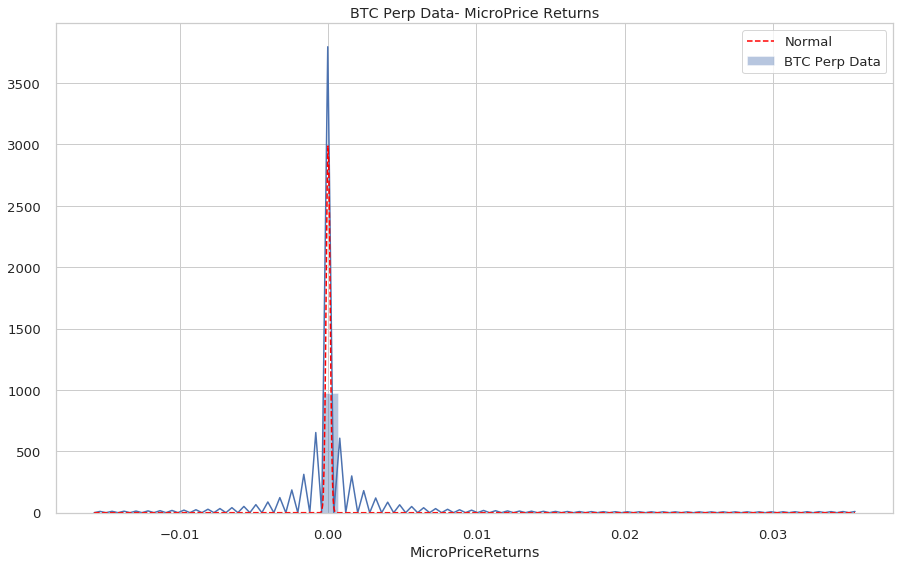

In [21]:
from scipy.stats import norm
x = np.linspace(np.min(df.MicroPriceReturns),np.max(df.MicroPriceReturns),1000)
y = norm.pdf(x, loc=np.mean(df.MicroPriceReturns), scale=np.std(df.MicroPriceReturns))    # for example

plt.figure(figsize=(15,9))
sns.light_palette("navy", reverse=True)
#sns.set_palette("husl")
sns.color_palette("PuBuGn_d")
sns.set_context("talk")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax=sns.distplot(df.MicroPriceReturns, label='BTC Perp Data')
plt.plot(x,y, color='red',linestyle='--',label='Normal')
ax.legend()
plt.title('BTC Perp Data- MicroPrice Returns')
ax.tick_params(right=False, top=False)

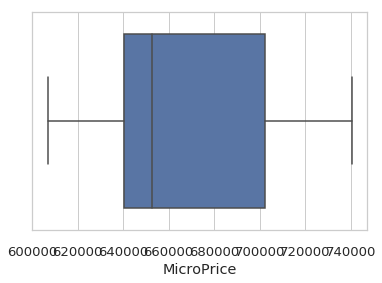

In [22]:
mad = mad_outlier(df.MicroPrice.values.reshape(-1,1))
_=sns.boxplot(df.loc[~mad].MicroPrice*100)

In [24]:

s1=df.bestAskSize
s2=df.bestBidSize
df['v']=pd.concat([s1, s2], axis=1).min(axis=1)
# np.min(df.bestAskSize, df.bestBidPrice)
df['dv']= df.v*df.MicroPrice

/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print('num ticks:', n_ticks)
print('volume ratio:', volume_ratio)
print('dollar ratio:', dollar_ratio)

('num ticks:', 27684849)
('volume ratio:', 444902.0)
('dollar ratio:', 2977671812.0)


In [26]:
tick_M = 100 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df, 'MicroPrice', tick_M)
tidx[:10]



  2%|▏         | 446555/27684849 [00:00<00:06, 4465543.61it/s]

('tick threshold:', 100)


100%|██████████| 27684849/27684849 [00:04<00:00, 6185720.49it/s]


[99, 199, 299, 399, 499, 599, 699, 799, 899, 999]

In [27]:


tick_df = tick_bar_df(df, 'MicroPrice', tick_M)
tick_df.shape



100%|██████████| 27684849/27684849 [00:04<00:00, 6178189.32it/s]


(276848, 14)

In [28]:
def select_sample_data(ref, sub, price_col, idx_1,idx_2):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = df[price_col].iloc[idx_1:idx_2]
    xtdf = sub[price_col].iloc[idx_1:idx_2]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=10000
xdf, xtdf = select_sample_data(df, tick_df, 'MicroPrice', idx_1,idx_2)

xdf.shape, xtdf.shape

((10000,), (10000,))

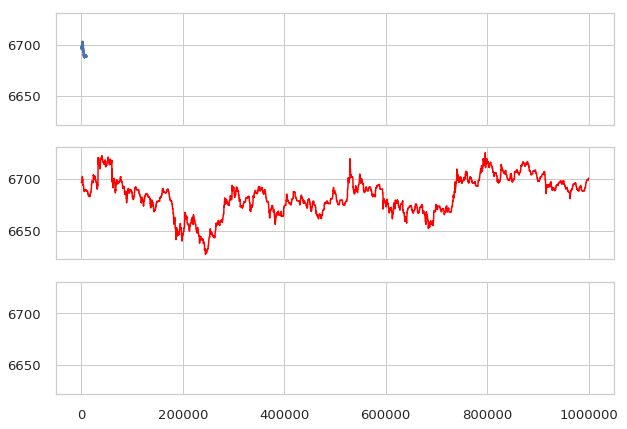

In [30]:
ref = xdf
sub =xtdf
f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
sns.lineplot(data=xdf,ax=axes[0], palette="tab10", linewidth=2.5)
sns.lineplot(data=xtdf,ax=axes[1],palette="tab25",color='red',linestyle='-' ,linewidth=1.5)

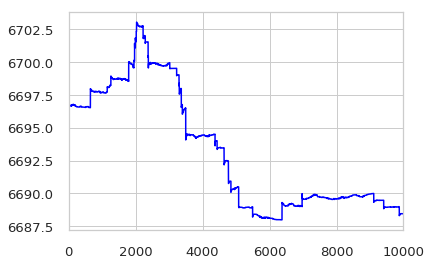

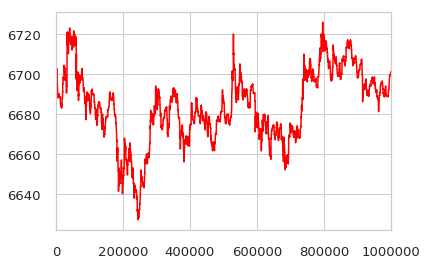

In [31]:
bar_type='tick bar'
# fig,axes=plt.subplots(3, figsize=(10,7))
ref=xdf
sub=xtdf
ref.plot(color='blue',label='price')
plt.show()
sub.plot(color='red',label=bar_type)
plt.show()


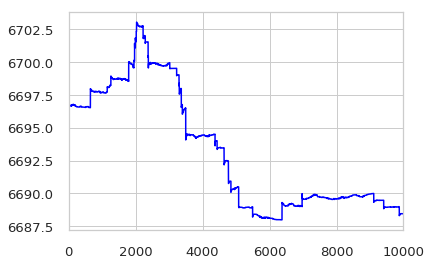

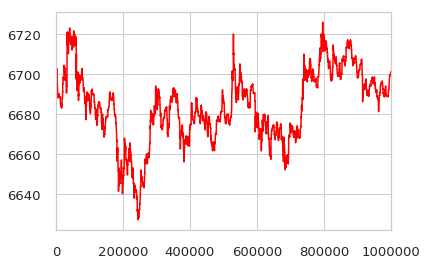

In [32]:
ax = ref.plot(color='blue',label='price')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.00f}'))
plt.show()
ax2 = sub.plot(color='red',label=bar_type)
num_ticks = 10

plt.show()

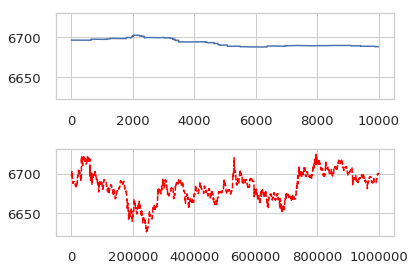

In [33]:

fig, axs = plt.subplots(2, 1,sharey=True)
axs[0].plot(ref)
axs[1].plot(sub, color= 'red',linestyle='--')
# axs[0].set_xlim(0, 2)

axs[0].grid(True)

for axs in axes:
    axs.set_xlabel('Common x-label')
    axs.set_ylabel('Common y-label')

fig.tight_layout()
plt.show()

/home/ak/Envs/research/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


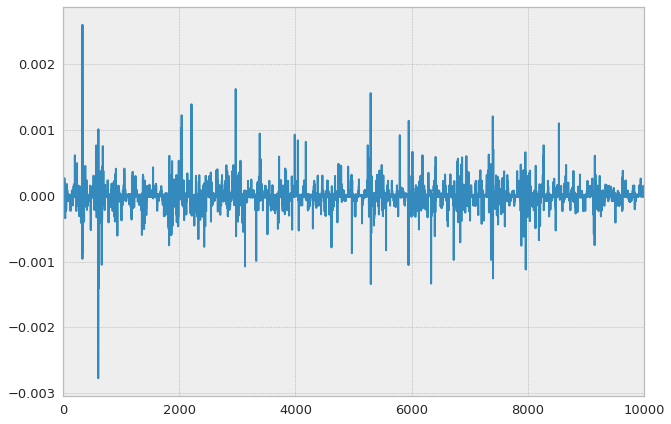

/home/ak/Envs/research/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


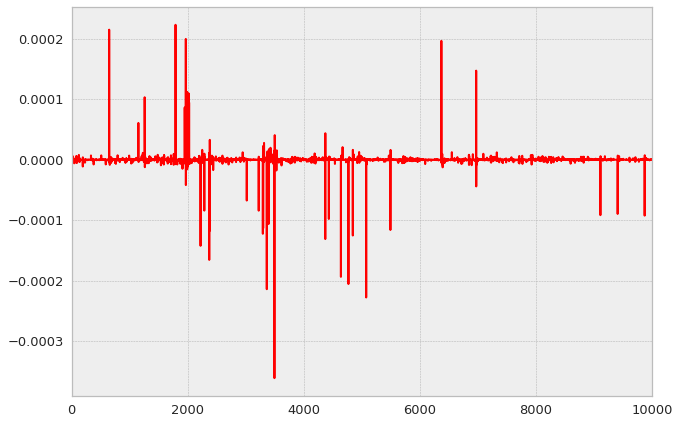

In [118]:

sub_returns =sub.pct_change().dropna()
ref_returns = ref.pct_change().dropna()

sns.tsplot(sub_returns)
plt.show()
sns.tsplot(ref_returns, color='red')
plt.show()

In [ ]:
# def autocorr(x):
#     n = x.size
#     norm = (x - np.mean(x))
#     result = np.correlate(norm, norm, mode='same')
#     acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
#     lag = np.abs(acorr).argmax() + 1
#     r = acorr[lag-1]        
#     if np.abs(r) > 0.5:
#         print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
#     else: 
#         print('Appears to be not autocorrelated')
#     return r, lag


In [35]:
df['SqrdReturns']=(df.MicroPriceReturns**2)*100

/home/ak/Envs/research/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


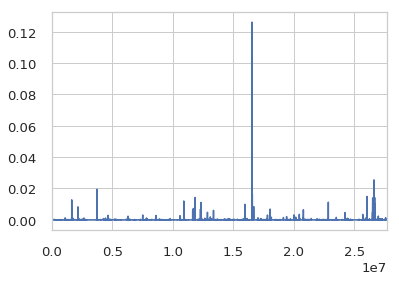

In [36]:
df.SqrdReturns.plot()

In [31]:
import statsmodels as sts
# Importing lag_plot
# from pandas import lag_plot
# from pandas import autocorrelation_plot


In [38]:
series = df.MicroPrice

# import pandas as pd
import datetools

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# # plot_acf(series)
# # plt.show()
# # # plot_pacf(series)
# # # plt.show()

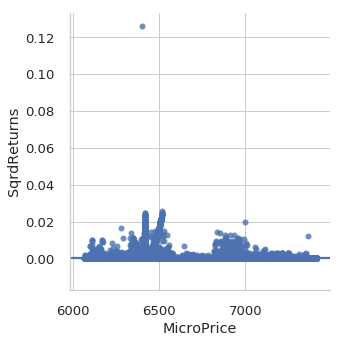

In [39]:
sns.lmplot(x='MicroPrice', y='SqrdReturns', data=df)
#do calculation using high and low

In [90]:
sample=df[:20000]

In [91]:
len(sample)

20000

In [93]:
fit_returns_discrete = powerlaw.Fit(sample.MicroPriceReturns, discrete=False) 
fitwolf = powerlaw.Fit(sample.MicroPriceReturns, discrete=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [94]:
df.shape

(27684849, 15)

In [95]:
data= sample.MicroPriceReturns
####
import powerlaw
fit = powerlaw.Fit(data)
fit.power_law.alpha
fit.power_law.sigma
fit.distribution_compare('power_law', 'exponential')

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


(958.9591031602828, 3.716010049035742e-17)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


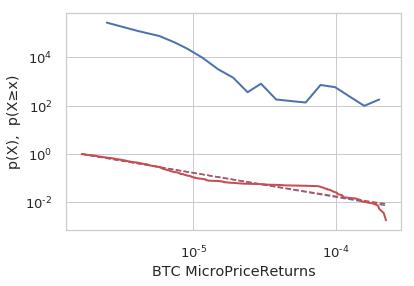

In [96]:
fit = powerlaw.Fit(data, discrete=True)
####
figCCDF = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)
fit.plot_ccdf(color='r', linewidth=2, ax=figCCDF)
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF)
####
figCCDF.set_ylabel(u"p(X),  p(X≥x)")
figCCDF.set_xlabel(r"BTC MicroPriceReturns")

figname = 'FigCCDF'

In [97]:
fit = powerlaw.Fit(data)
###
x, y = fit.cdf()
bin_edges, probability = fit.pdf()
y = fit.lognormal.cdf(data=[300,350])
y = fit.lognormal.pdf()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


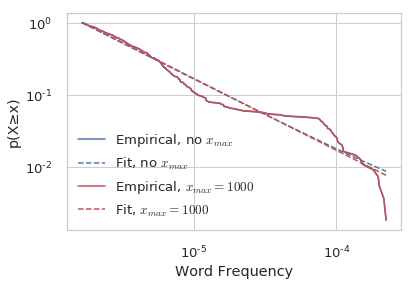

In [98]:
fit = powerlaw.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = powerlaw.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")
#x, y = powerlaw.ccdf(data, xmax=max(data))
#fig1.plot(x,y)
####
#FigCCDFmax.set_ylabel(r"$p(X\geq x)$")
FigCCDFmax.set_ylabel(u"p(X≥x)")
FigCCDFmax.set_xlabel(r"Word Frequency")
handles, labels = FigCCDFmax.get_legend_handles_labels()
leg = FigCCDFmax.legend(handles, labels, loc=3)
leg.draw_frame(False)

figname = 'FigCCDFmax'
# savefig(figname+'.eps', bbox_inches='tight')
#savefig(figname+'.tiff', bbox_inches='tight', dpi=300)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


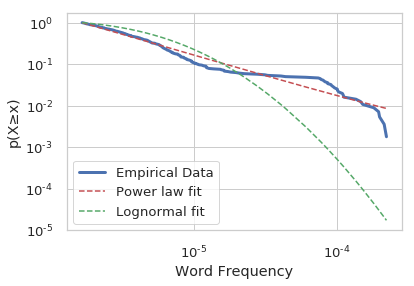

In [99]:
fit = powerlaw.Fit(data, discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Word Frequency")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)

In [100]:
df_crypto.columns.values

array(['Unnamed: 0', 'bestBidPrice', 'bestBidSize', 'bestAskPrice',
       'bestAskSize', 'timestamp', 'time', 'date', 'milliSeconds',
       'duration', 'MicroPrice', 'MicroPriceReturns'], dtype=object)

In [101]:
tick_M = 20 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df_crypto, 'MicroPrice', tick_M)
tidx[:10]


  2%|▏         | 434068/27684850 [00:00<00:06, 4340673.79it/s]

('tick threshold:', 20)


100%|██████████| 27684850/27684850 [00:04<00:00, 6111708.76it/s]


[19, 39, 59, 79, 99, 119, 139, 159, 179, 199]

In [102]:
crypto_tick_df = tick_bar_df(df_crypto, 'MicroPrice', tick_M)
crypto_tick_df.shape

100%|██████████| 27684850/27684850 [00:04<00:00, 6035402.26it/s]


(1384242, 12)

In [103]:
## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=1000000
# perp_xdf, perp_xtdf = select_sample_data(df_crypto, crypto_tick_df, 'MicroPrice', idx_1,idx_2)

# perp_xdf.shape, perp_xtdf.shape
crypto_tick_df.head(4)

,Unnamed: 0,bestBidPrice,bestBidSize,bestAskPrice,bestAskSize,timestamp,time,date,milliSeconds,duration,MicroPrice,MicroPriceReturns
19,20,6696.5,1148160.0,6697.0,367214.0,2018-08-26 13:21:40.332000+00:00,13:21:40.332000,2018-08-26,48100000.0,0.0,6696.621163,0.000000e+00
39,40,6696.5,1048660.0,6697.0,676364.0,2018-08-26 13:21:41.609000+00:00,13:21:41.609000,2018-08-26,48101000.0,0.0,6696.696045,0.000000e+00
59,60,6696.5,1223292.0,6697.0,472620.0,2018-08-26 13:21:42.555000+00:00,13:21:42.555000,2018-08-26,48102000.0,0.0,6696.639341,-1.226930e-11
79,80,6696.5,1217966.0,6697.0,695804.0,2018-08-26 13:21:43.964000+00:00,13:21:43.964000,2018-08-26,48103000.0,0.0,6696.681789,-6.827579e-08


In [83]:
dta_plain = sample.MicroPriceReturns

In [88]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

In [82]:
# data = perp_xdf

# sns.lineplot(data=perp_xdf, palette="tab10", linewidth=2.5)
# plt.show()
# sns.lineplot(data=perp_xtdf,palette="tab25",color='red',linestyle='-' ,linewidth=1.5)

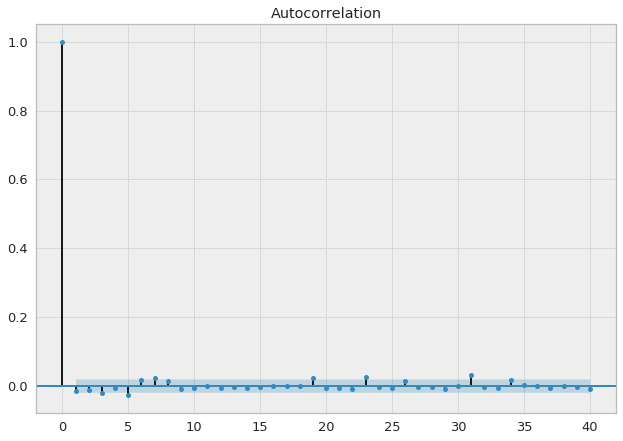

In [125]:
sm.graphics.tsa.plot_acf(ref_returns.values.squeeze(), lags=40)
plt.show()

In [143]:
def pacf_graph(df,title):
    sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=40)
    plt.title(title)
    plt.show()

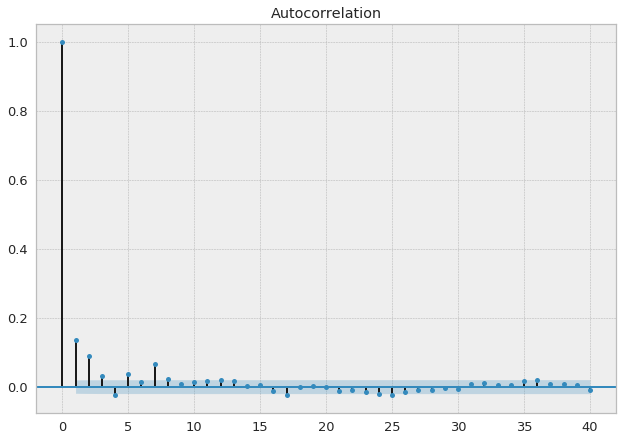

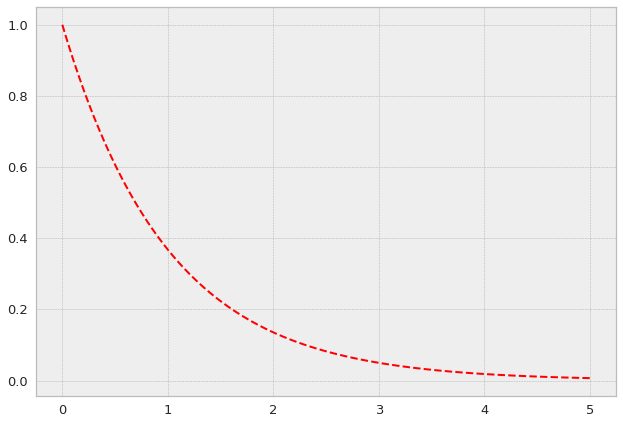

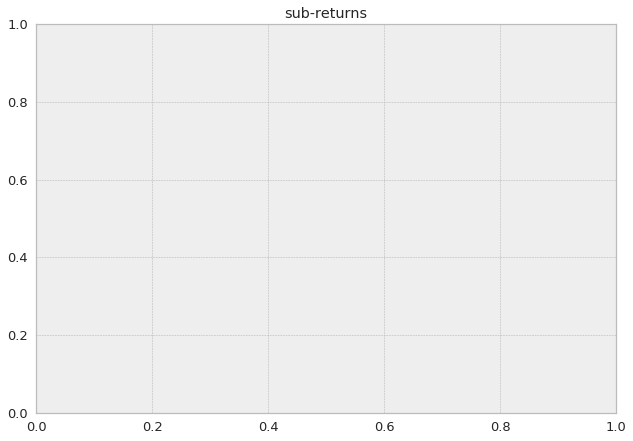

In [144]:
pacf_graph(sub_returns,'sub-returns')

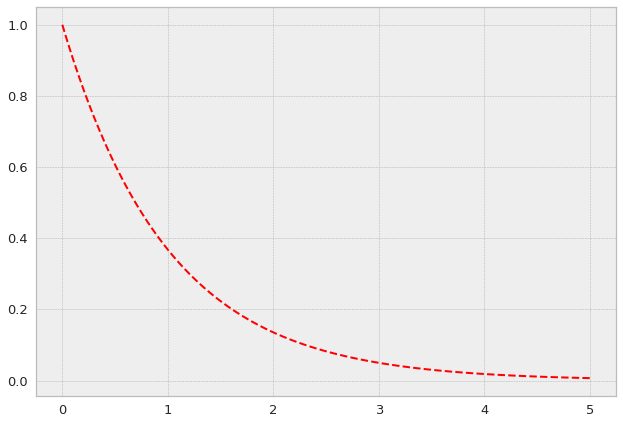

In [142]:
def expo_decay():
    x = np.linspace(0, 5, 100)
    y = np.exp(x)
    plt.figure()
    plt.plot(x, np.exp(-x), color='red',linestyle='--')
#     plt.xlabel('$x$')
#     plt.ylabel('$-\exp(-x)$')

    plt.show()
expo_decay()

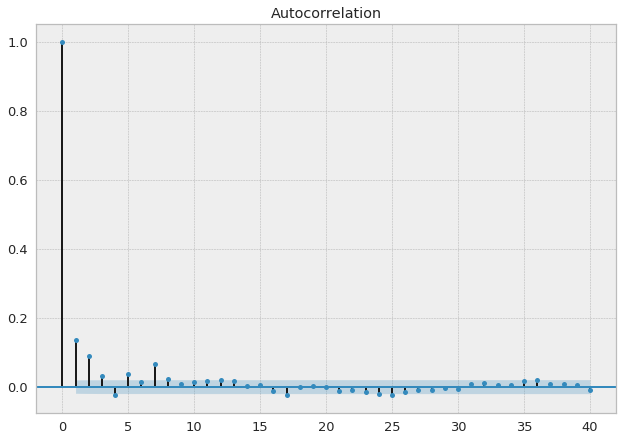

In [128]:
fig = tsaplots.plot_acf(sub_returns.values, lags=40)